# Emaitzen analisia: metriken kalkulua

In [1]:
# Datu fitxategiak irakurtzeko / irudikatzeko
import numpy as np
import pandas as pd

# Manage files and folders:
import os

# Plotting
import matplotlib.pyplot as plt
import scienceplots

# Figure features
plt.style.use(['science', 'ieee', 'vibrant'])#, 'grid'

plt.rcParams.update({
    "font.family": "Palatino" # Laneko testuarekin bat etortzeko.
})

C:\Users\beatb\AppData\Local\Temp\ipykernel_3932\2362350089.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Konbinazioak bi dira oraingoan

Bi konbinazio probatuko ditut:
- B: Soluzioan: NVT - Hutsean: NVT/Non Periodic
- D: Soluzioan: NPT - Hutsean: NVT/Non Periodic

Artxiboen bide izenak:
- Soluzioan NVT: 
 `alchemical_tutoriala/outputs_NVT/cyclopentanol/result_files/measurements_solvated_cyclopentanol.npy`
- Soluzioan NPT: 
 `alchemical_tutoriala/outputs_NPT/cyclopentanol/result_files/measurements_solvated_cyclopentanol.npy`
- Hutsean NVT/Non Periodic: 
 `alchemical_tutoriala/outputs_NVT/cyclopentanol/result_files/measurements_vacuum_cyclopentanol.npy`
 `alchemical_tutoriala/outputs_NPT/cyclopentanol/result_files/measurements_vacuum_cyclopentanol.npy`

## OpenMM-ko unit eta Quantity erabili behar ez izateko egindako aldaketak

In [2]:
temperature = 300 # K
kT = 2.494338785445972 # kJoule/mole

def convert_kJ_to_kcal(kJ):
    kcal = kJ * 0.239006
    return kcal

## Erabiliko ditudan funtzioak

In [2]:
# Energiaren kalkulurako:
def FEP_forward(U_kln):
    '''FEP forward ekuazioaren inplementazioa'''
    temperature = 300 # K
    kT = 2.494338785445972 # kJoule/mole

    # 16. bikotearekin kasuan, kontuz, ezin dugu s+1 hartu.
    nlambda = U_kln.shape[0]
    niterations = U_kln.shape[2]
    u_diff = np.zeros((nlambda-1,niterations)) #-1, 16. bikotera ez iristeko.
    #print(U_kln[0,0,-1],U_kln[0,1,-1])
    for k in range(0,nlambda-1):
        u_diff[k,:] = U_kln[k,k+1,:]-U_kln[k,k,:]

    exp = np.exp(-u_diff/kT)
    return np.sum((-kT)*np.log(np.mean(exp, axis=1)))  # Value in kJ/mol.

def solvatation_free_energy_forward(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    '''
    Forward. Return value given in kcal/mol.
    '''
    deltaG_solvated = FEP_forward(np.load(OUTPUT_PATH_solvated+f'{molecule_name}/result_files/measurements_solvated_{molecule_name}.npy'))
    deltaG_vacuum = FEP_forward(np.load(OUTPUT_PATH_vacuum+f'{molecule_name}/result_files/measurements_vacuum_{molecule_name}.npy'))

    return (deltaG_vacuum - deltaG_solvated)*0.239006 # kJ/mol -> kcal/mol

def FEP_backward(U_kln):
    '''FEP backward ekuazioaren inplementazioa'''
    # B --> A, S* = {B, I_n, ..., I_2, I_1, A}
    temperature = 300 # K
    kT = 2.494338785445972 # kJoule/mole

    # 16. bikotearekin kasuan, kontuz, ezin dugu s+1 hartu.
    nlambda = U_kln.shape[0]
    niterations = U_kln.shape[2]
    u_diff = np.zeros((nlambda-1,niterations)) #-1, 16. bikotera ez iristeko. Indizeak: 0,1,...,14. Elementu kopurua: 15
    
    #for k in range(0,nlambda-1): forward
    for k in range(nlambda-1, 0, -1): #backward. s+1 = k-1. range-> 15,14,13,12,11,...,1
        u_diff[k-1,:] = U_kln[k,k,:]-U_kln[k,k-1,:]

    exp = np.exp(u_diff/kT) #backward (+)
    return np.sum((kT)*np.log(np.mean(exp, axis=1)))  # Value in kJ/mol. #backward (+)

def solvatation_free_energy_back(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    '''
    Backwatd. Return value given in kcal/mol
    '''
    deltaG_solvated = FEP_backward(np.load(OUTPUT_PATH_solvated+f'{molecule_name}/result_files/measurements_solvated_{molecule_name}.npy'))
    deltaG_vacuum = FEP_backward(np.load(OUTPUT_PATH_vacuum+f'{molecule_name}/result_files/measurements_vacuum_{molecule_name}.npy'))

    return (deltaG_vacuum - deltaG_solvated)*0.239006 # kJ/mol -> kcal/mol

def BAR_iteration(U_F, U_R, C):
    '''A function that when zeroed is equivalent to the solution of the Bennett acceptance ratio.
    Check BARzero in pymbar.

    Parameters
    ----------
    U_F : np.ndarray
        Energy differences computed in the forward direction (U_B-U_A).
    U_R : np.ndarray
        Energy differences computed in the reverse direction (U_A-U_B).
    C : float
        This value will tend to the desired value of the free energy difference as the iterations are performed.
        It is our current guess.

    Returns
    -------
    float 
    '''
    num = np.sum(1/(1+np.exp(U_F-C)) )
    denom = np.sum(1/(1+np.exp(-(-U_R-C))) )
    return np.log(num/denom)

def BAR(U_F, U_R, DeltaA=0.0, maximum_iterations=500, relative_tolerance=1.0e-12,):
    '''Compute free energy difference using the Bennett acceptance ratio (BAR) method.
    The energy difference is computed only between TWO STATES.

    Parameters
    ----------
    U_F : np.ndarray
        Energy differences computed in the forward direction (U_B-U_A).
    U_R : np.ndarray
        Energy differences computed in the reverse direction (U_A-U_B).
    DeltaA : float, optional, default=0.0
        It is our initial guess for the free energy difference.
    maximum_iterations : int, optional, default=500
        Can be set to limit the maximum number of iterations performed.
    relative_tolerance : float, optional, default=1E-12
        Can be set to determine the relative tolerance convergence criteria (default 1.0e-12).    

    Returns
    -------
    DeltaA : float
        Free energy difference. It needs to be multiplied with kBT in order to get the correct dimensions.

    Notes
    -----
    Garrantzitsua da U_F eta U_R-ren kalkulua noranzko egokian egitea! 
    '''

    for i in range(maximum_iterations):
        DeltaAOld = DeltaA
        DeltaA -= BAR_iteration(U_F, U_R, DeltaAOld)

        if DeltaA == 0.0:
            # The free energy difference appears to be zero.
            break

        elif i>0 and (np.abs((DeltaA - DeltaAOld) / DeltaA) < relative_tolerance):
            #print("Convergence has been reached.")
            break

    else:
        print("Maximum number of iterations has been reached")


    return DeltaA

def BAR_free_energy(U_kln):
    '''Compute free energy difference using the Bennett acceptance ratio (BAR) method.'''
    temperature = 300 # K
    kT = 2.494338785445972 # kJoule/mole

    # Get an array containing U_F for each step of lambda.
    # 16. bikotearekin kasuan, kontuz, ezin dugu s+1 hartu.
    nlambda = U_kln.shape[0]
    niterations = U_kln.shape[2]
    u_diff_F = np.zeros((nlambda-1,niterations)) #-1, 16. bikotera ez iristeko.
    u_diff_R = np.zeros((nlambda-1,niterations)) #-1, 16. bikotera ez iristeko. Indizeak: 0,1,...,14. Elementu kopurua: 15

    for k in range(0,nlambda-1):
        u_diff_F[k,:] = U_kln[k,k+1,:]-U_kln[k,k,:]
    for k in range(1,nlambda):
        u_diff_R[k-1,:] = U_kln[k,k,:]-U_kln[k,k-1,:] #Gero BAR funtzioan - zeinu bat beharko dugu, B->A behar dugulako bertan.

    DeltaG = 0.0
    for step in range(0,nlambda-1):
        DeltaG += BAR(u_diff_F[step,:]/kT, -u_diff_R[step,:]/kT)*kT
        #DeltaG += bar.BAR(u_diff_F[step,:]/kT, -u_diff_R[step,:]/kT)[0]*kT

    return DeltaG # Value in kJ/mol.

def solvatation_free_energy_BAR(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    '''
    Return value given in kcal/mol
    '''
    deltaG_solvated = BAR_free_energy(np.load(OUTPUT_PATH_solvated+f'{molecule_name}/result_files/measurements_solvated_{molecule_name}.npy'))
    deltaG_vacuum = BAR_free_energy(np.load(OUTPUT_PATH_vacuum+f'{molecule_name}/result_files/measurements_vacuum_{molecule_name}.npy'))

    return (deltaG_vacuum - deltaG_solvated)*0.239006 # kJ/mol -> kcal/mol

def solvatation_free_energy(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    forward = solvatation_free_energy_forward(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)
    backward = solvatation_free_energy_back(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)
    bar = solvatation_free_energy_BAR(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)
    return forward, backward, bar

def free_energy_std(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    # Teknika honek bootstraping du izena.
    U_kln_solv = np.load(OUTPUT_PATH_solvated+f'{molecule_name}/result_files/measurements_solvated_{molecule_name}.npy')
    U_kln_vac = np.load(OUTPUT_PATH_vacuum+f'{molecule_name}/result_files/measurements_vacuum_{molecule_name}.npy')

    temperature = 300 # K
    kT = 2.494338785445972 # kJoule/mole 
    niterations = U_kln_solv.shape[2]

    M = 100 # Konbergentzia hobea lortzeko moldatu.
    deltaG_vac = dict()
    deltaG_vac['forward'] = np.zeros(M)
    deltaG_vac['backward'] = np.zeros(M)
    deltaG_vac['BAR'] = np.zeros(M)
    deltaG_solv = dict()
    deltaG_solv['forward'] = np.zeros(M)
    deltaG_solv['backward'] = np.zeros(M)
    deltaG_solv['BAR'] = np.zeros(M)

    np.random.seed()
    
    for i in range(M):
        # Ausazko indizeak sortu eta U_kln lagindu ausazko indizeak erabiliz.
        random_indices = np.random.choice(niterations, niterations, replace=True) # Sample WITH replacement
        U_kln_solv_sampled = U_kln_solv[:,:,random_indices]
        random_indices = np.random.choice(niterations, niterations, replace=True) # Sample WITH replacement
        U_kln_vac_sampled = U_kln_vac[:,:,random_indices]

        # Solvated energy:
        #deltaG['BAR'][i] = (BAR_free_energy(U_kln_vac_sampled) - BAR_free_energy(U_kln_solv_sampled)) * 0.239006 # kJ/mol -> kcal/mol
        #deltaG['forward'][i] = (FEP_forward(U_kln_vac_sampled) - FEP_forward(U_kln_solv_sampled)) * 0.239006 # kJ/mol -> kcal/mol
        #deltaG['backward'][i]= (FEP_backward(U_kln_vac_sampled) - FEP_backward(U_kln_solv_sampled)) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_vac['BAR'][i] = BAR_free_energy(U_kln_vac_sampled) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_vac['forward'][i] = FEP_forward(U_kln_vac_sampled) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_vac['backward'][i]= FEP_backward(U_kln_vac_sampled) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_solv['BAR'][i] = BAR_free_energy(U_kln_solv_sampled) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_solv['forward'][i] = FEP_forward(U_kln_solv_sampled) * 0.239006 # kJ/mol -> kcal/mol
        deltaG_solv['backward'][i]= FEP_backward(U_kln_solv_sampled) * 0.239006 # kJ/mol -> kcal/mol

    deltaG_stats = dict()
    deltaG_stats['forward'] = {'mean': np.mean(deltaG_vac['forward'])-np.mean(deltaG_solv['forward']), 'std': np.std(deltaG_vac['forward'])+np.std(deltaG_solv['forward'])}
    deltaG_stats['backward'] = {'mean': np.mean(deltaG_vac['backward'])-np.mean(deltaG_solv['backward']), 'std': np.std(deltaG_vac['backward'])+np.std(deltaG_solv['backward'])}
    deltaG_stats['BAR'] = {'mean': np.mean(deltaG_vac['BAR'])-np.mean(deltaG_solv['BAR']), 'std': np.std(deltaG_vac['BAR'])+np.std(deltaG_solv['BAR'])}

    return deltaG_stats
        

In [3]:
free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', 'neopentane')

{'forward': {'mean': 2.4883470586646093, 'std': 0.12897568750362162},
 'backward': {'mean': 2.7134150629659115, 'std': 0.03864206813456264},
 'BAR': {'mean': 2.6405547473413113, 'std': 0.03211933990856241}}

In [410]:
free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', 'neopentane')

{'forward': {'mean': 2.5116945623791893, 'std': 0.12455651489042549},
 'backward': {'mean': 2.719162562599215, 'std': 0.04898962804309549},
 'BAR': {'mean': 2.644147397448589, 'std': 0.03622580865560105}}

### Metriken kalkulurako funtzioak

Mean Absolute Error (MAE):
$$
MAE = \frac{1}{N}\sum_i^N \left|\, dG_i^\text{kalkulatua} - dG_i^\text{esperimentala} \,\right|
$$
Mean Squared Error (MSE):
$$
MAE = \frac{1}{N}\sum_i^N \left( dG_i^\text{kalkulatua} - dG_i^\text{esperimentala} \right)^2
$$
Pearson Correlation Coefficient (PCC):
$$
r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}
$$

In [3]:
# Kendall tau
from scipy.stats import kendalltau

def calc_tau_scipy(data_dict, comb_key, molecule_names):
    X = [data_dict[molecule_name][comb_key] for molecule_name in molecule_names]
    Y = [data_dict[molecule_name]['0_experimental_value'] for molecule_name in molecule_names]

    tau, _ = kendalltau(X,Y)
    return(tau)

def calc_tau(data_dict, comb_key, molecule_names):
    x = [data_dict[molecule_name][comb_key] for molecule_name in molecule_names]
    y = [data_dict[molecule_name]['0_experimental_value'] for molecule_name in molecule_names]

    n = len(y)
    concordant, discordant = 0,0

    for i in range(n-1):
        for j in range(i+1,n):
            if (x[i]<x[j] and y[i]<y[j]) or (x[i]>x[j] and y[i]>y[j]):
                concordant +=1
            else:
                discordant += 1
    
    numerator = concordant - discordant
    denominator = n*(n-1)/2
    return numerator/denominator

def calc_PCC(data_dict, comb_key, molecule_names):
    '''
    data_dict : data dictionary containing all the data calculated in the simulations
    comb_key : identifier of the combination of ensembles used in the specifical calculation whose result we want to analyze.
    return PCC
    '''
    x_bar = 0 # Simulation values
    y_bar = 0 # Experimental values

    for molecule_name in molecule_names:
        x_bar += data_dict[molecule_name][comb_key]
        y_bar += data_dict[molecule_name]['0_experimental_value']

    x_bar /= len(molecule_names)
    y_bar /= len(molecule_names)

    # Compute 3 Sums: r_xy = S1/sqrt(S2*S3)
    S1,S2,S3 = 0,0,0

    for molecule_name in molecule_names:
        S1 += (data_dict[molecule_name][comb_key]-x_bar)*(data_dict[molecule_name]['0_experimental_value']-y_bar)
        S2 += (data_dict[molecule_name][comb_key]-x_bar)**2
        S3 += (data_dict[molecule_name]['0_experimental_value']-y_bar)**2
        

    return S1 / np.sqrt(S2*S3)

def calc_MAE(data_dict, comb_key, molecule_names):
    '''
    data_dict : data dictionary containing all the data calculated in the simulations
    comb_key : identifier of the combination of ensembles used in the specifical calculation whose result we want to analyze.
    return MAE : Mean Absolute Error of the provided data, with respect to the experimental values.
    '''
    MAE = 0 # Sum
    for molecule_name in molecule_names:
        MAE += np.abs(data_dict[molecule_name]['0_experimental_value']-data_dict[molecule_name][comb_key])
    return MAE / len(molecule_names)

def calc_MSE(data_dict, comb_key, molecule_names):
    '''
    data_dict : data dictionary containing all the data calculated in the simulations
    comb_key : identifier of the combination of ensembles used in the specifical calculation whose result we want to analyze.
    return MSE : Mean Squared Error of the provided data, with respect to the experimental values.
    '''
    MSE = 0 # Sum
    for molecule_name in molecule_names:
        MSE += (data_dict[molecule_name]['0_experimental_value']-data_dict[molecule_name][comb_key])**2
    return MSE / len(molecule_names)

## 1. txandako grafikoak

Lau konbinazio probatuko ditut:
- A: Soluzioan: NVT - Hutsean: NVT/Periodic
- B: Soluzioan: NVT - Hutsean: NVT/Non Periodic
- C: Soluzioan: NPT - Hutsean: NVT/Periodic
- D: Soluzioan: NPT - Hutsean: NVT/Non Periodic

Artxiboen bide izenak:
- Soluzioan NVT: 
 `outputs_zaharrak/outputs_NVT_periodic/cyclopentanol/result_files/measurements_solvated_cyclopentanol.npy`
- Soluzioan NPT: 
 `outputs_zaharrak/outputs_NPT/cyclopentanol/result_files/measurements_solvated_cyclopentanol.npy`
- Hutsean NVT/Periodic: 
 `outputs_zaharrak/outputs_NVT_periodic/cyclopentanol/result_files/measurements_vacuum_cyclopentanol.npy`
- Hutsean NVT/Non Periodic: 
 `outputs_zaharrak/outputs_NVT_non_periodic/cyclopentanol/result_files/measurements_vacuum_cyclopentanol.npy`

*Molekulen zerrenda*:
1. 1,4-dioxane
2. 1-amino-4-hydroxy-9,10-anthracenedione
3. 2-bromo-2-methyl-propane
4. [(2S)-butan-2-yl]-nitrate
5. 3-methylbutan-2-one
6. 3-phenylpropan-1-ol
7. but-1-ene
8. cyclopentanol
9. heptan-4-one

In [7]:
solvated_NVT = './outputs_zaharrak/outputs_NVT_periodic/'
solvated_NPT = './outputs_zaharrak/outputs_NPT/'
vacuum_NVT_periodic = './outputs_zaharrak/outputs_NVT_periodic/'
vacuum_NVT_non_periodic = './outputs_zaharrak/outputs_NVT_non_periodic/'

# I will use tuples to specify the combinations: (key, solvated_output_directory, vacuum_output_directory)
combinations = [('A_NVT_NVTp', solvated_NVT, vacuum_NVT_periodic),
                ('B_NVT_NVTnp', solvated_NVT, vacuum_NVT_non_periodic),
                ('C_NPT_NVTp', solvated_NPT, vacuum_NVT_periodic),
                ('D_NPT_NVTnp', solvated_NPT, vacuum_NVT_non_periodic)]

molecule_names = '''1,4-dioxane
1-amino-4-hydroxy-9,10-anthracenedione
2-bromo-2-methyl-propane
[(2S)-butan-2-yl]-nitrate
3-methylbutan-2-one
3-phenylpropan-1-ol
but-1-ene
cyclopentanol
heptan-4-one'''.split()

# Create the dictionary to store all the data:
# The structure will be: data_dict[estimator]={molecule_name: {0_experimental_value: value, B_NVT_NVTnp: value, D_NPT_NVTnp: value}}
data_dict = dict()


# Create the dictionary to store all the data.
# Estimators: forward, backward, BAR
forward_dict = dict()
backward_dict = dict()
bar_dict = dict()

# Fill the dictionary with the experimental values.
for molecule_name in molecule_names:
    forward_dict[molecule_name] = dict()
    backward_dict[molecule_name] = dict()
    bar_dict[molecule_name] = dict()

data_dict['forward'] = forward_dict
data_dict['backward'] = backward_dict
data_dict['BAR'] = bar_dict

# Load experimental values:
df = pd.read_csv('balio_esperimental_zaharrak.csv')
df.loc[df['name'] == '[(2S)-butan-2-yl] nitrate', 'name']='[(2S)-butan-2-yl]-nitrate'

for i in range(len(df)):
    data_dict['forward'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"]}
    data_dict['backward'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"]}
    data_dict['BAR'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"]}

# Simulazioetako emaitzekin sortutako datu egiturak bete.
# Remember that all the energy units are kcal/mol.
for (comb_key, OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum) in combinations:
    for molecule_name in list(df.name):
        fw_energy, bw_energy, bar_energy = solvatation_free_energy(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)
        data_dict['forward'][molecule_name][comb_key] = round(float(fw_energy),4)
        data_dict['backward'][molecule_name][comb_key] = round(float(bw_energy),4)
        data_dict['BAR'][molecule_name][comb_key] = round(float(bar_energy),4)

In [424]:
pd.DataFrame(data_dict['forward'])

1,4-dioxane  1-amino-4-hydroxy-9,10-anthracenedione  \
0_experimental_value      -5.0600                                 -9.5300   
A_NVT_NVTp                -5.2306                                -13.4750   
B_NVT_NVTnp               -5.1583                                -13.4042   
C_NPT_NVTp                -3.8136                                 -9.7670   
D_NPT_NVTnp               -3.7413                                 -9.6962   

                      2-bromo-2-methyl-propane  [(2S)-butan-2-yl]-nitrate  \
0_experimental_value                    0.8400                    -1.8200   
A_NVT_NVTp                             -0.5814                    -2.2860   
B_NVT_NVTnp                            -0.5879                    -2.2828   
C_NPT_NVTp                              0.8208                    -0.3594   
D_NPT_NVTnp                             0.8144                    -0.3562   

                      3-methylbutan-2-one  3-phenylpropan-1-ol  but-1-ene  \
0_experimental_value              -3.2400              -6.9200     1.3800   
A_NVT_NVTp                        -4.5455              -7.5587     1.5511   
B_NVT_NVTnp                       -4.5354              -7.6103     1.5501   
C_NPT_NVTp                        -3.2259              -5.0234     2.7603   
D_NPT_NVTnp                       -3.2157              -5.0750     2.7593   

                      cyclopentanol  heptan-4-one  
0_experimental_value        -5.4900       -2.9200  
A_NVT_NVTp                  -5.0371       -4.9191  
B_NVT_NVTnp                 -5.0436       -4.9202  
C_NPT_NVTp                  -3.8924       -2.5798  
D_NPT_NVTnp                 -3.8989       -2.5809

In [9]:
# Metriken kalkulua:
metrics_dict = dict()

# Datu egitura hutsa sortu, eta balio esperimentalak sartu.
# Estimators: forward, backward, BAR
metrics_dict['forward'] = dict()
metrics_dict['backward'] = dict()
metrics_dict['BAR'] = dict()

molecule_names = list(df.name)
for (comb_key, _, __) in combinations:
    metrics_dict['forward'][comb_key] = {'MAE' : calc_MAE(data_dict['forward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['forward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['forward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['forward'], comb_key, molecule_names)}
    metrics_dict['backward'][comb_key] = {'MAE' : calc_MAE(data_dict['backward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['backward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['backward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['backward'], comb_key, molecule_names)}
    metrics_dict['BAR'][comb_key] = {'MAE' : calc_MAE(data_dict['BAR'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['BAR'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['BAR'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['BAR'], comb_key, molecule_names)}


In [10]:
pd.DataFrame(metrics_dict['BAR'])

A_NVT_NVTp  B_NVT_NVTnp  C_NPT_NVTp  D_NPT_NVTnp
MAE    1.067067     1.060156    0.927100     0.914289
MSE    2.116530     2.113026    1.367116     1.328744
PCC    0.955373     0.956513    0.976926     0.977607
tau    0.888889     0.888889    0.944444     0.944444

In [11]:
combinations

[('A_NVT_NVTp',
  './outputs_zaharrak/outputs_NVT_periodic/',
  './outputs_zaharrak/outputs_NVT_periodic/'),
 ('B_NVT_NVTnp',
  './outputs_zaharrak/outputs_NVT_periodic/',
  './outputs_zaharrak/outputs_NVT_non_periodic/'),
 ('C_NPT_NVTp',
  './outputs_zaharrak/outputs_NPT/',
  './outputs_zaharrak/outputs_NVT_periodic/'),
 ('D_NPT_NVTnp',
  './outputs_zaharrak/outputs_NPT/',
  './outputs_zaharrak/outputs_NVT_non_periodic/')]

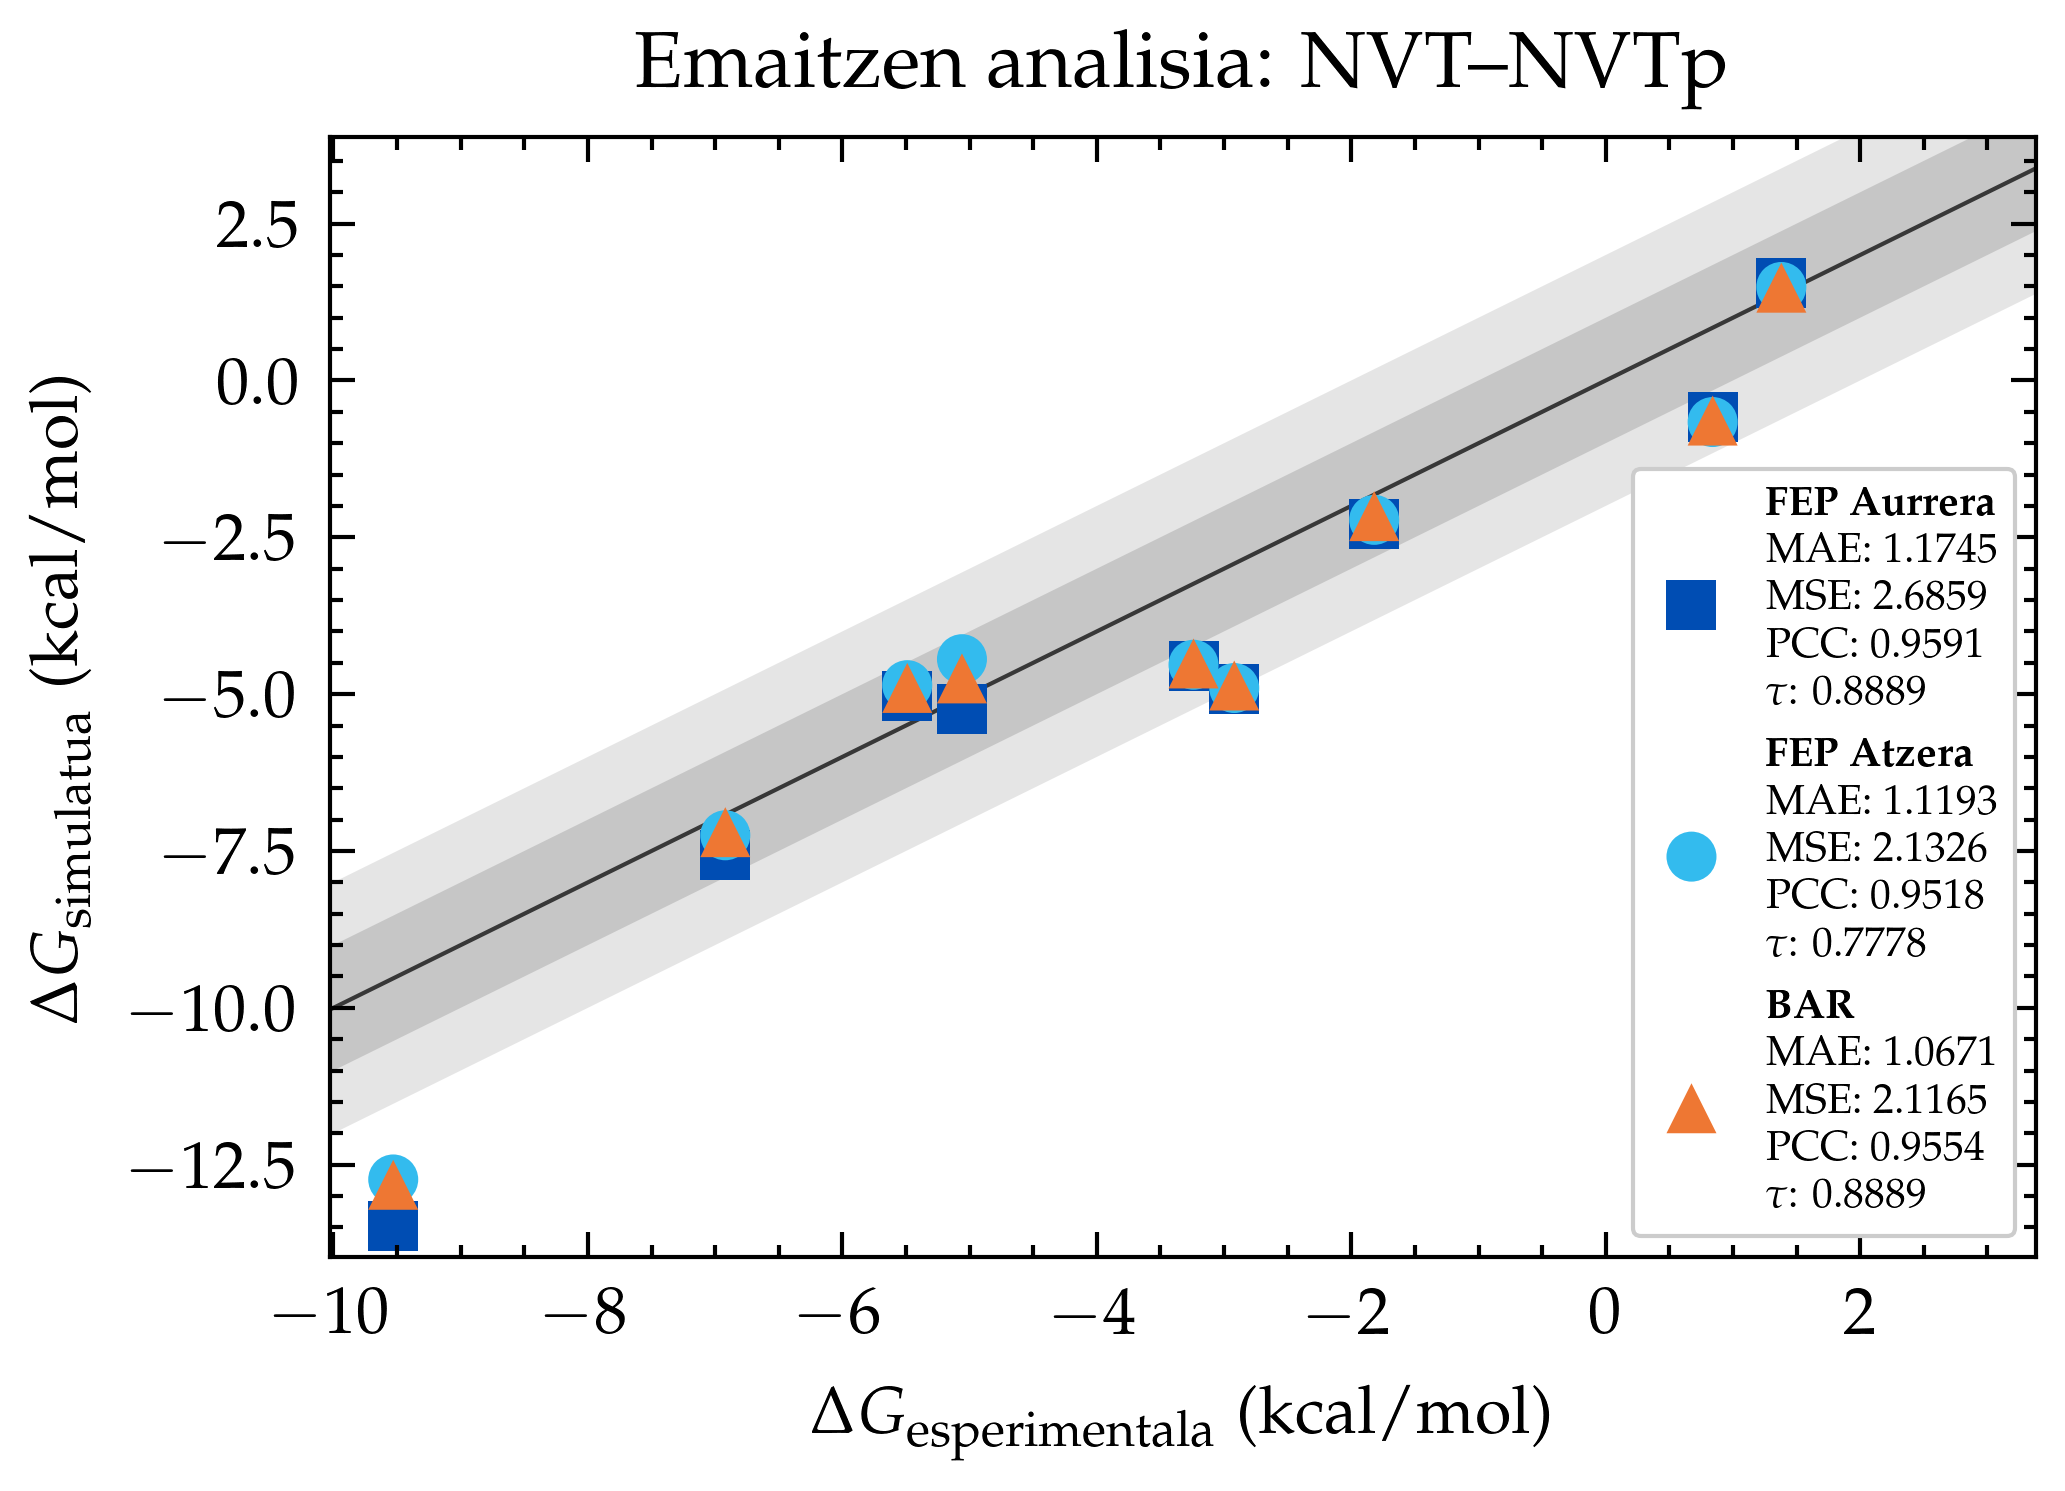

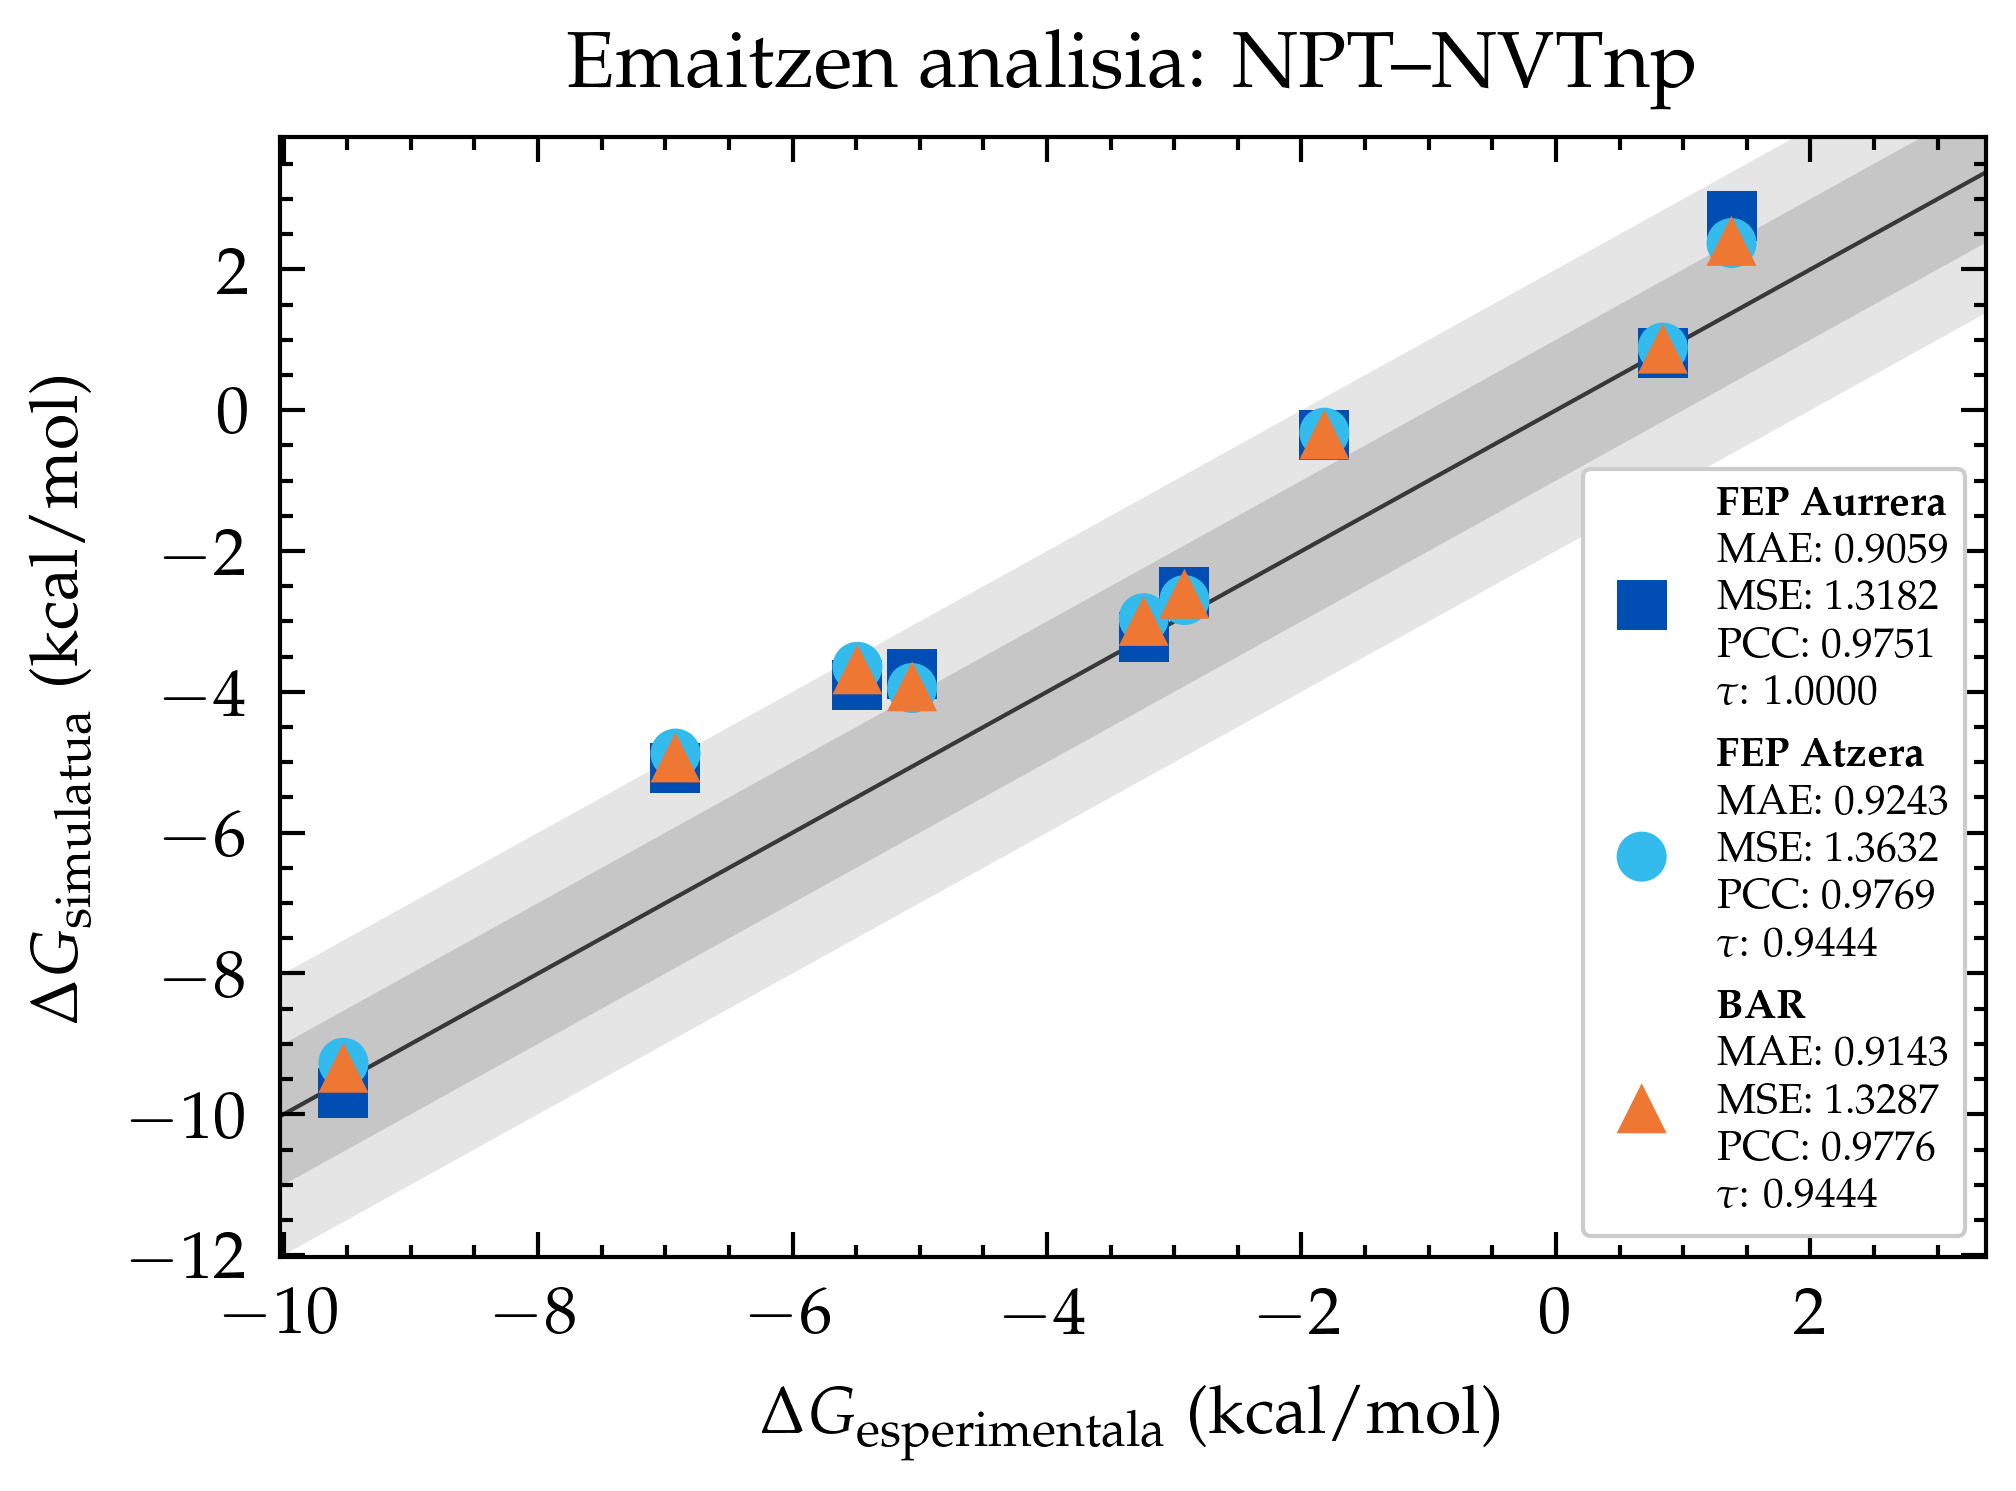

In [17]:
# Konbinazioen irudiak:
OUTPUT_PATH = 'outputs/outputs_metrikak/zaharrak/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

plot_combination_fbbar(data_dict, metrics_dict, combinations[0][0], legend_font_size=5).savefig(OUTPUT_PATH+f"Metrikak_NVT_NVTp.pdf")
plot_combination_fbbar(data_dict, metrics_dict, combinations[3][0], legend_font_size=5).savefig(OUTPUT_PATH+f"Metrikak_NPT_NVTnp.pdf")

### FEP-ekin kalkulatuta, lau konbinazioen metriken taula

In [427]:
#Forward:
df = pd.DataFrame(metrics_dict['forward'])
df = df.rename(columns=lambda x: x[2:].replace('_','--'))

df = df.round(4)
df = df.map(lambda x: f"${x}$")
display(df)

latex_table = df.to_latex(index=True, escape=False)
print('Forward:')
print(latex_table)

#Backward:
df = pd.DataFrame(metrics_dict['backward'])
df = df.rename(columns=lambda x: x[2:].replace('_','--'))

df = df.round(4)
df = df.map(lambda x: f"${x}$")
display(df)

latex_table = df.to_latex(index=True, escape=False)
print('Backward:')
print(latex_table)

NVT--NVTp NVT--NVTnp NPT--NVTp NPT--NVTnp
MAE  $1.1745$   $1.1628$  $0.9102$   $0.9059$
MSE  $2.6859$   $2.6284$  $1.3238$   $1.3182$
PCC  $0.9591$   $0.9595$  $0.9744$   $0.9751$
tau  $0.8889$   $0.8889$     $1.0$      $1.0$

Forward:
\begin{tabular}{lllll}
\toprule
 & NVT--NVTp & NVT--NVTnp & NPT--NVTp & NPT--NVTnp \\
\midrule
MAE & $1.1745$ & $1.1628$ & $0.9102$ & $0.9059$ \\
MSE & $2.6859$ & $2.6284$ & $1.3238$ & $1.3182$ \\
PCC & $0.9591$ & $0.9595$ & $0.9744$ & $0.9751$ \\
tau & $0.8889$ & $0.8889$ & $1.0$ & $1.0$ \\
\bottomrule
\end{tabular}



NVT--NVTp NVT--NVTnp NPT--NVTp NPT--NVTnp
MAE  $1.1193$   $1.0945$  $0.9456$   $0.9243$
MSE  $2.1326$   $2.1144$  $1.4135$   $1.3632$
PCC  $0.9518$   $0.9539$  $0.9764$   $0.9769$
tau  $0.7778$   $0.8333$  $0.9444$   $0.9444$

Backward:
\begin{tabular}{lllll}
\toprule
 & NVT--NVTp & NVT--NVTnp & NPT--NVTp & NPT--NVTnp \\
\midrule
MAE & $1.1193$ & $1.0945$ & $0.9456$ & $0.9243$ \\
MSE & $2.1326$ & $2.1144$ & $1.4135$ & $1.3632$ \\
PCC & $0.9518$ & $0.9539$ & $0.9764$ & $0.9769$ \\
tau & $0.7778$ & $0.8333$ & $0.9444$ & $0.9444$ \\
\bottomrule
\end{tabular}



### BAR-ekin kalkulatuta, lau konbinazioen metriken taula

In [184]:
df = pd.DataFrame(metrics_dict['BAR'])
df = df.rename(columns=lambda x: x[2:].replace('_','--'))

df = df.round(4)
df = df.map(lambda x: f"${x}$")
display(df)

latex_table = df.to_latex(index=True, escape=False)
print(latex_table)


NVT-NVTp NVT-NVTnp  NPT-NVTp NPT-NVTnp
MAE  $1.0671$  $1.0602$  $0.9271$  $0.9143$
MSE  $2.1165$   $2.113$  $1.3671$  $1.3287$
PCC  $0.9554$  $0.9565$  $0.9769$  $0.9776$
tau  $0.8889$  $0.8889$  $0.9444$  $0.9444$

\begin{tabular}{lllll}
\toprule
 & NVT-NVTp & NVT-NVTnp & NPT-NVTp & NPT-NVTnp \\
\midrule
MAE & $1.0671$ & $1.0602$ & $0.9271$ & $0.9143$ \\
MSE & $2.1165$ & $2.113$ & $1.3671$ & $1.3287$ \\
PCC & $0.9554$ & $0.9565$ & $0.9769$ & $0.9776$ \\
tau & $0.8889$ & $0.8889$ & $0.9444$ & $0.9444$ \\
\bottomrule
\end{tabular}



## Konparaketak: NPT vs NVT eta NVTnp vs NVTp

In [13]:
 def plot_konparaketa(data_dict, comb_key_X, comb_key_Y, xlabel, ylabel, title='', fig_size=(3.5, 2.625)):
    X = []      # X -> balio esperimentalak
    Y = []      # Y -> kalkulatutako balioak

    for molecule_name in molecule_names:
        X.append(data_dict['BAR'][molecule_name][comb_key_X])
        Y.append(data_dict['BAR'][molecule_name][comb_key_Y])

    fig, ax = plt.subplots(figsize=fig_size)
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = set(X+Y+list(X_range)).union({-12})
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(xlabel+r' (kcal/mol)')
    ax.set_ylabel(ylabel+r' (kcal/mol)')
    ax.set_title(f"Emaitzen analisia: {title}")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)

    ax.scatter(X, Y, marker='o', color='C0', zorder=1, edgecolor='none')

    fig.tight_layout()
    return fig

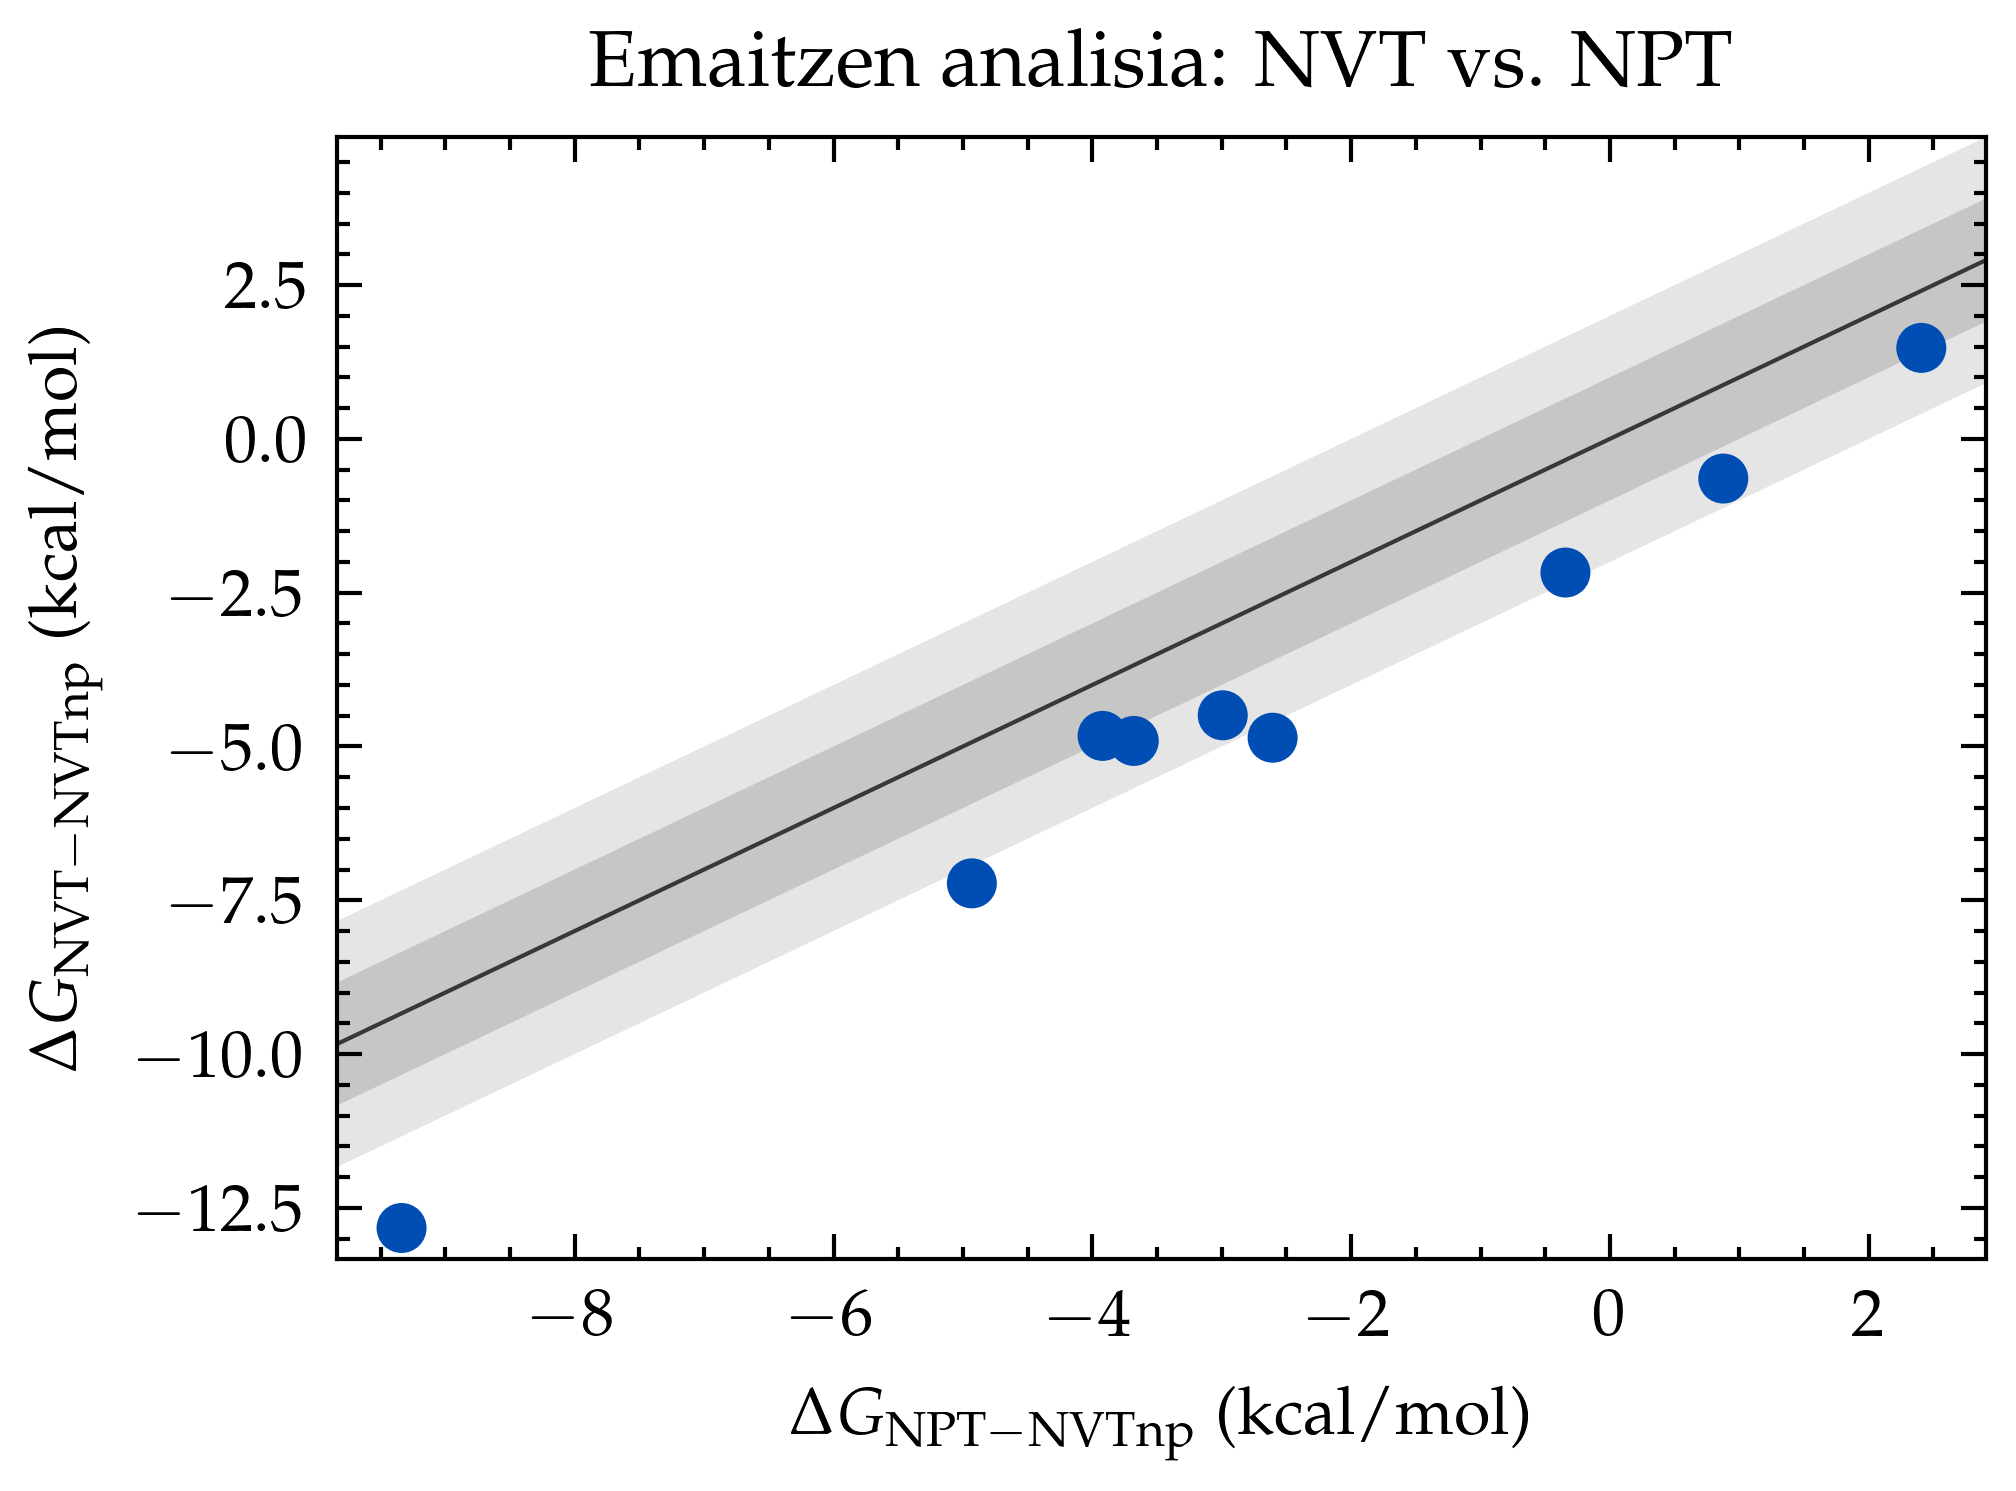

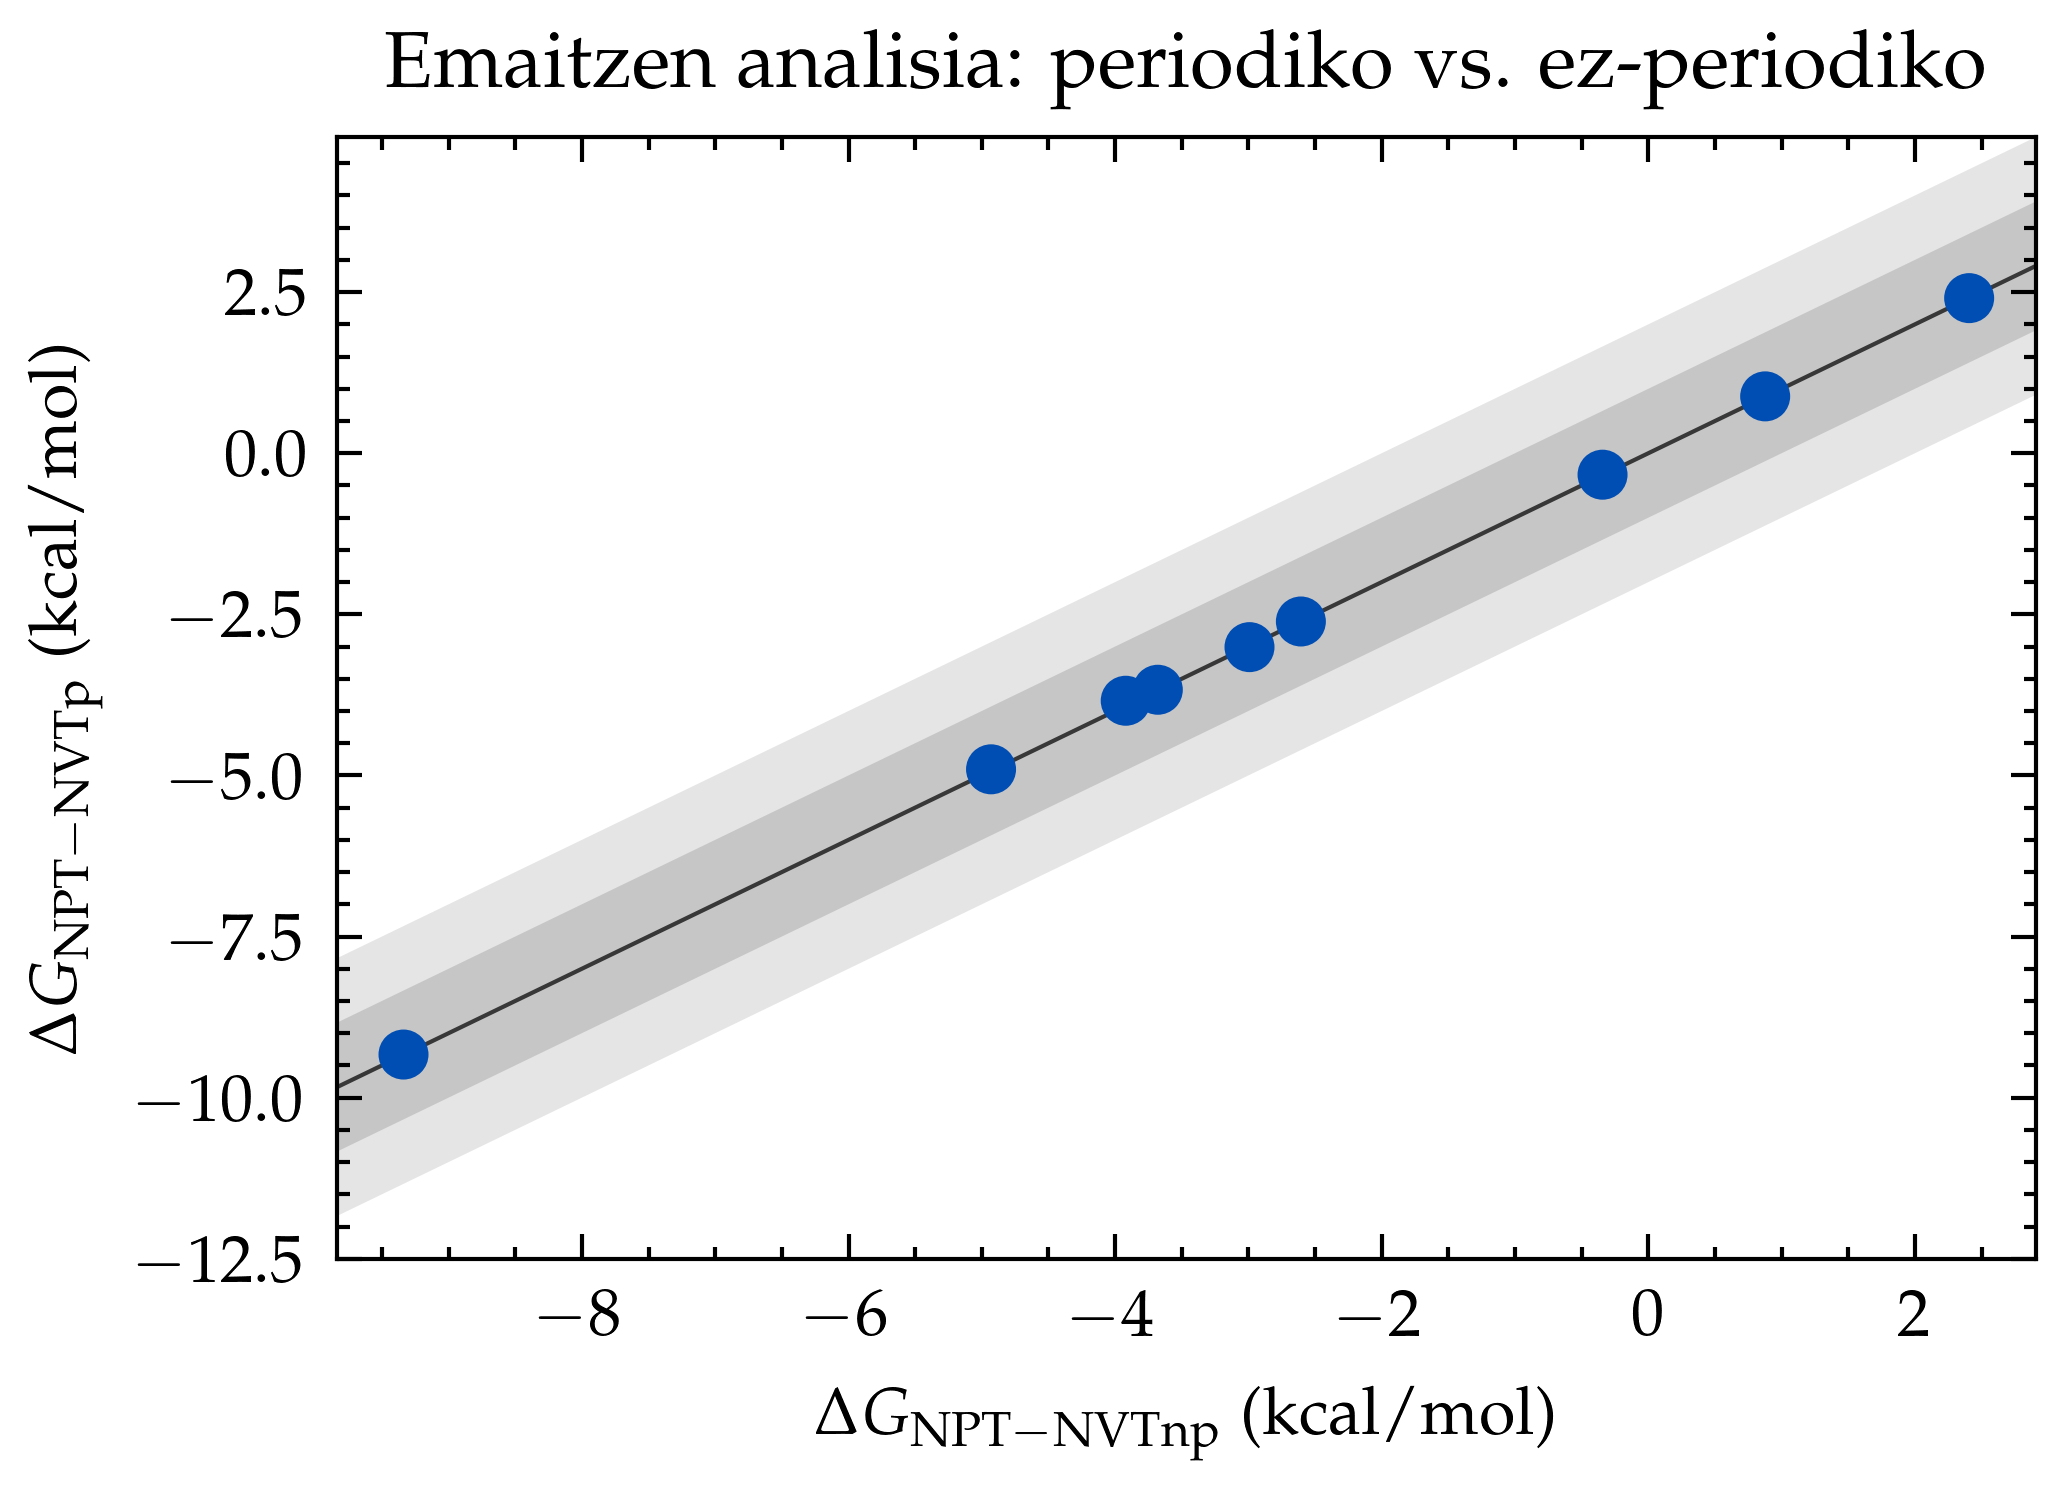

In [14]:
OUTPUT_PATH = 'outputs/outputs_metrikak/zaharrak/'

xlabel = r'$\Delta G_{\mathrm{NPT-NVTnp}}$'
ylabel = r'$\Delta G_{\mathrm{NVT-NVTnp}}$'

plot_konparaketa(data_dict, 'D_NPT_NVTnp', 'B_NVT_NVTnp', xlabel, ylabel, title=r'NVT vs. NPT').savefig(OUTPUT_PATH+f"Metrikak_NVT_vs_NPT.pdf")

xlabel = r'$\Delta G_{\mathrm{NPT-NVTnp}}$'
ylabel = r'$\Delta G_{\mathrm{NPT-NVTp}}$'

plot_konparaketa(data_dict, 'D_NPT_NVTnp', 'C_NPT_NVTp',  xlabel, ylabel, title=r'periodiko vs. ez-periodiko').savefig(OUTPUT_PATH+f"Metrikak_p_vs_np.pdf")

Agian argigarriagoa izan daitekeelako, beste grafiko bat egingo da konparaketarako, kalkulatua vs esperimentala, eta bi modutan kalkulatutakoak jarriko dira: NVT-NVTnp eta NPT-NVTnp.

In [230]:
combinations

[('A_NVT_NVTp',
  './outputs_zaharrak/outputs_NVT_periodic/',
  './outputs_zaharrak/outputs_NVT_periodic/'),
 ('B_NVT_NVTnp',
  './outputs_zaharrak/outputs_NVT_periodic/',
  './outputs_zaharrak/outputs_NVT_non_periodic/'),
 ('C_NPT_NVTp',
  './outputs_zaharrak/outputs_NPT/',
  './outputs_zaharrak/outputs_NVT_periodic/'),
 ('D_NPT_NVTnp',
  './outputs_zaharrak/outputs_NPT/',
  './outputs_zaharrak/outputs_NVT_non_periodic/')]

In [247]:
def plot_konparaketa_extra(data_dict):
    comb_key_A, comb_key_B = 'D_NPT_NVTnp', 'B_NVT_NVTnp'

    X = []      # X -> balio esperimentalak
    Y_A = []    # Y -> kalkulatutako balioak
    Y_B = []    # Y -> kalkulatutako balioak

    for molecule_name in molecule_names:
        X.append(data_dict['BAR'][molecule_name]['0_experimental_value'])
        Y_A.append(data_dict['BAR'][molecule_name][comb_key_A])
        Y_B.append(data_dict['BAR'][molecule_name][comb_key_B])

    fig, ax = plt.subplots(figsize=(3.5, 2.625))
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = set(Y_A+Y_B+list(X_range))
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen analisia: NPT eta NVT")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)
    
    legend_A = f"{comb_key_A[2:].replace('_','--')}"
    legend_B = f"{comb_key_B[2:].replace('_','--')}"
    
    ax.scatter(X, Y_A, label=legend_A, marker='o', color='C0', zorder=1, edgecolor='none')
    ax.scatter(X, Y_B, label=legend_B, marker='s', color='C1', zorder=1, edgecolor='none') 

    legend = ax.legend(frameon=True)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig


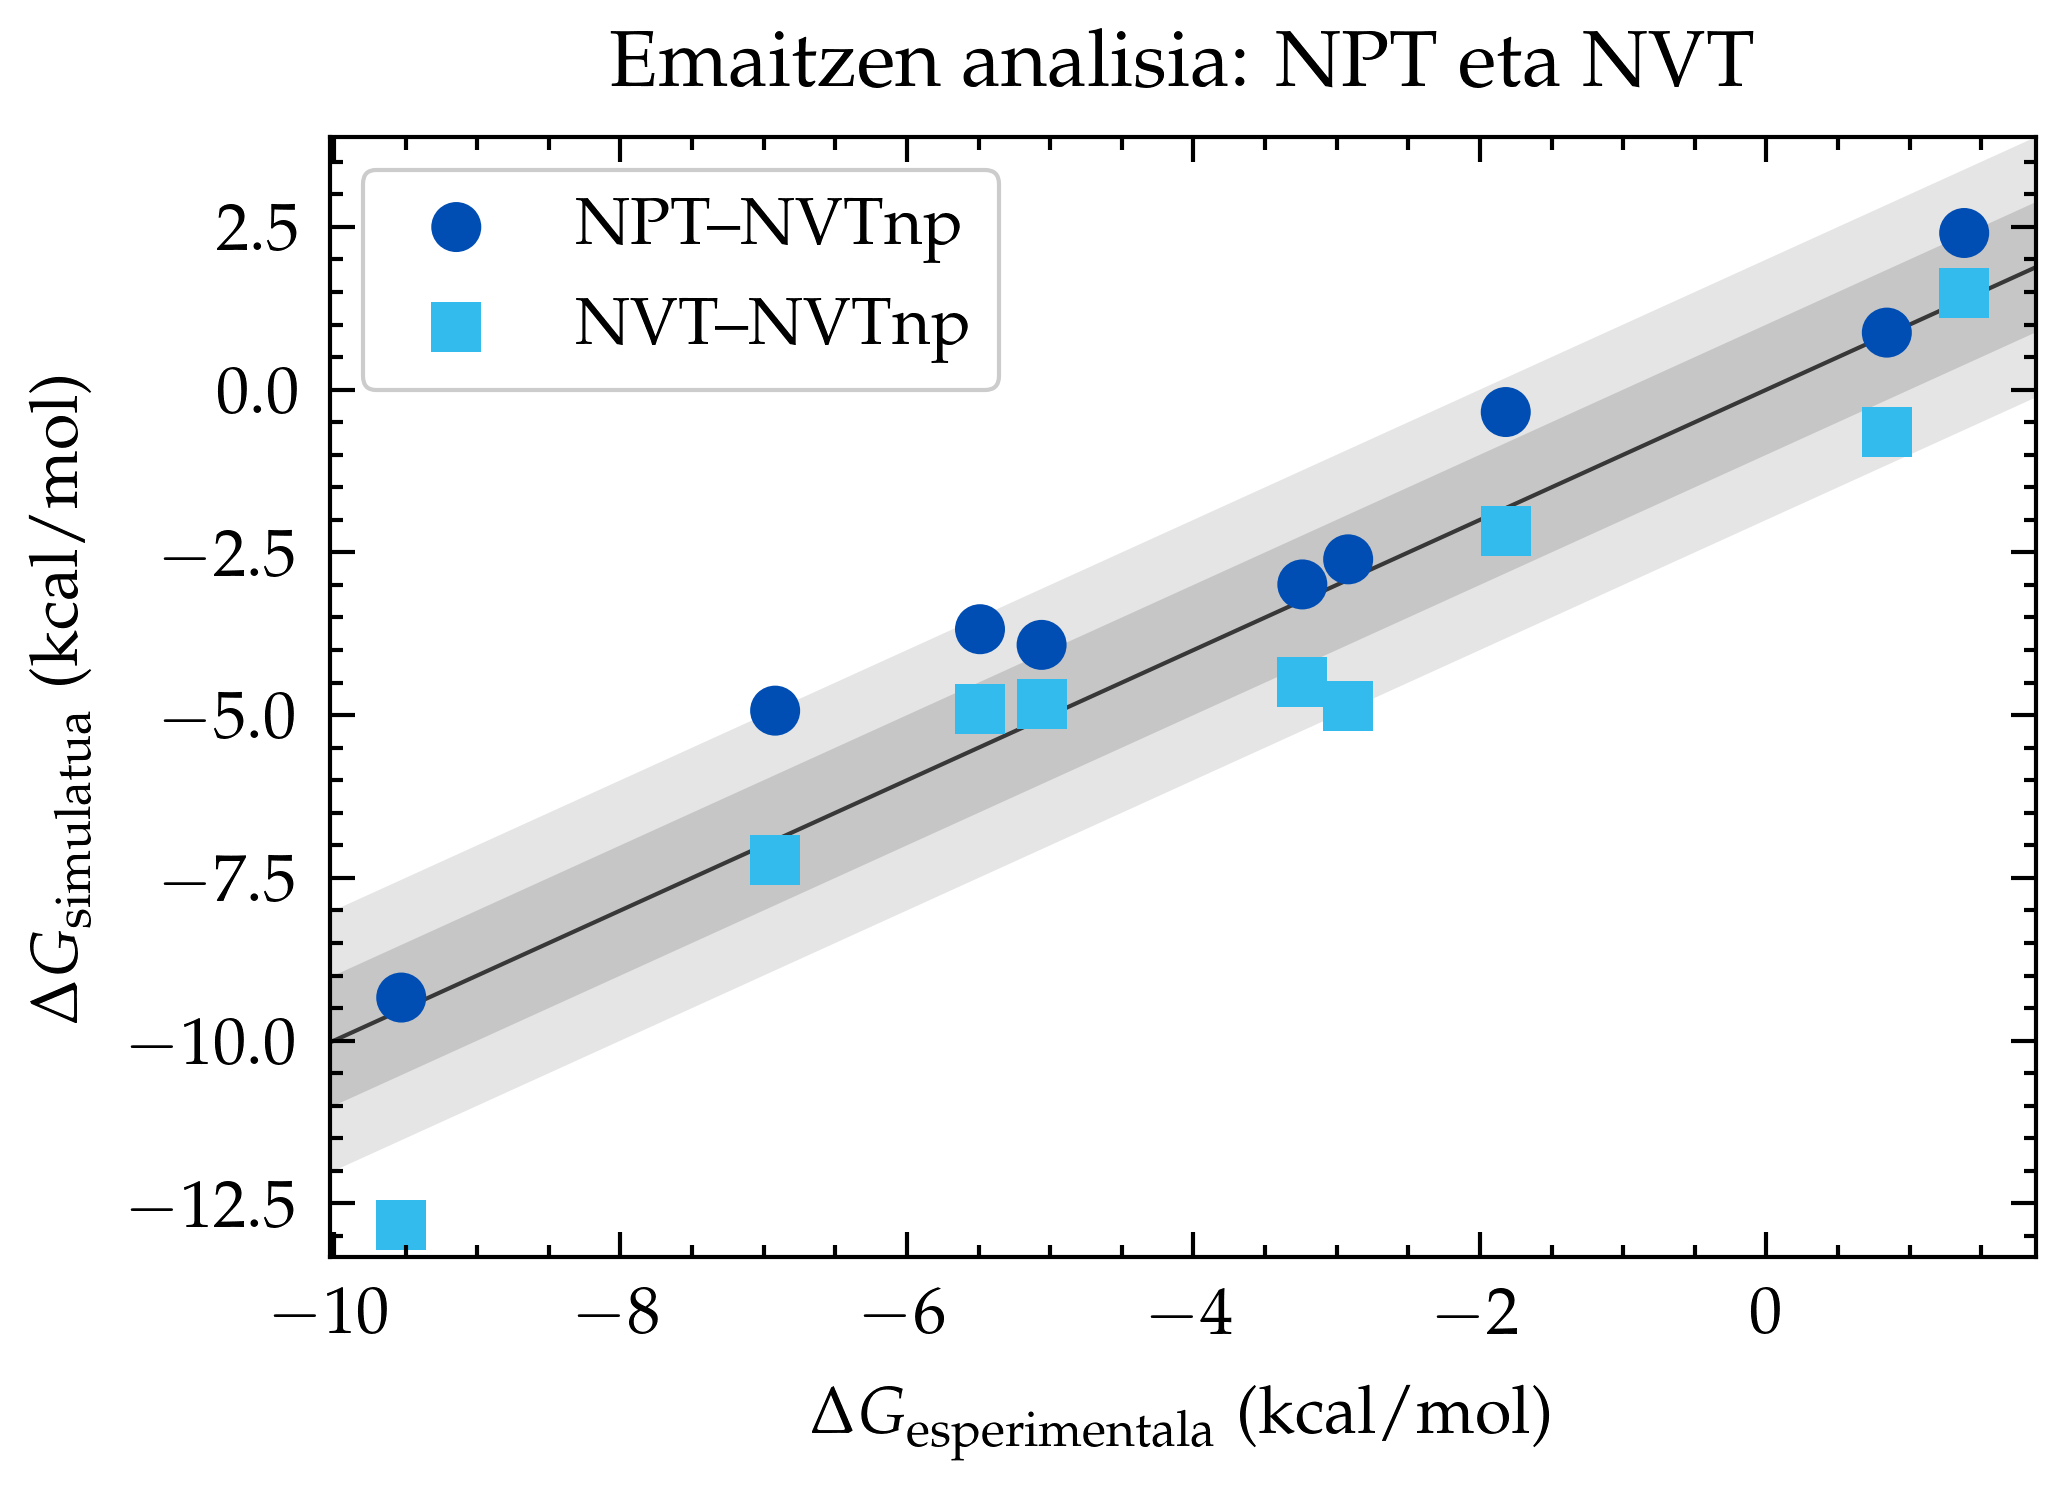

In [248]:
OUTPUT_PATH = 'outputs/outputs_metrikak/zaharrak/'

plot_konparaketa_extra(data_dict).savefig(OUTPUT_PATH+f"Metrikak_NVT_vs_NPT_extra.pdf")

## Txanda osoaren molekulen zerrenda

In [4]:
# Get molecules 
molecules_df = pd.read_csv('./balio_esperimental_berriak.csv')

#Zuzenketa batzuk izenetan (hutsuneak kendu):
molecules_df.loc[molecules_df['name'] == 'methyl cyclopropanecarboxylate', 'name']='methyl_cyclopropanecarboxylate'
molecules_df.loc[molecules_df['name'] == 'dimethyl sulfate', 'name']='dimethyl_sulfate'
molecules_df.loc[molecules_df['name'] == 'butyric acid', 'name']='butyric_acid'

erraza_df = molecules_df[molecules_df.group=='Erraza']
zaila_df = molecules_df[molecules_df.group=='Zaila']

print('Errazak:', '------------', *list(erraza_df.name), sep='\n', end=2*'\n')
print('Zailak:', '------------', *list(zaila_df.name), sep='\n')

Errazak:
------------
neopentane
dibenzo-p-dioxin
cyclohexane
ethoxybenzene
propan-1-ol
1,4-dimethylpiperazine
methyl_cyclopropanecarboxylate
ethylene
methanamine
3-chloroprop-1-ene
bromoform
endrin

Zailak:
------------
flurbiprofen
ibuprofen
ketoprofen
2-N-ethyl-6-(methylsulfanyl)-4-N-(propan-2-yl)-1,3,5-triazine-2,4-diamine
dimethyl_sulfate
chlorpyrifos
butyric_acid
(2Z)-3,7-dimethylocta-2,6-dien-1-ol


In [5]:
molecules_df

name  \
0                                          neopentane   
1                                        flurbiprofen   
2                                    dibenzo-p-dioxin   
3                                           ibuprofen   
4                                          ketoprofen   
5                                         cyclohexane   
6                                       ethoxybenzene   
7   2-N-ethyl-6-(methylsulfanyl)-4-N-(propan-2-yl)...   
8                                         propan-1-ol   
9                              1,4-dimethylpiperazine   
10                     methyl_cyclopropanecarboxylate   
11                                   dimethyl_sulfate   
12                                           ethylene   
13                                        methanamine   
14                                 3-chloroprop-1-ene   
15                                       chlorpyrifos   
16                                          bromoform   
17                                             endrin   
18                                       butyric_acid   
19                (2Z)-3,7-dimethylocta-2,6-dien-1-ol   

    experimental value (kcal/mol)  experimental uncertainty (kcal/mol)  \
0                            2.51                                 0.60   
1                           -8.42                                 0.16   
2                           -3.15                                 0.10   
3                           -7.00                                 0.64   
4                          -10.78                                 0.18   
5                            1.23                                 0.60   
6                           -2.22                                 0.60   
7                           -7.65                                 0.45   
8                           -4.85                                 0.60   
9                           -7.58                                 0.60   
10                          -4.10                                 0.60   
11                          -5.10                                 0.60   
12                           1.28                                 0.60   
13                          -4.55                                 0.60   
14                          -0.57                                 0.60   
15                          -5.04                                 0.21   
16                          -2.13                                 0.60   
17                          -4.82                                 0.10   
18                          -6.35                                 0.60   
19                          -4.78                                 0.25   

    rotatable bonds   group  
0                 0  Erraza  
1                 3   Zaila  
2                 0  Erraza  
3                 4   Zaila  
4                 4   Zaila  
5                 0  Erraza  
6                 2  Erraza  
7                 5   Zaila  
8                 1  Erraza  
9                 0  Erraza  
10                1  Erraza  
11                2   Zaila  
12                0  Erraza  
13                0  Erraza  
14                1  Erraza  
15                6   Zaila  
16                0  Erraza  
17                0  Erraza  
18                2   Zaila  
19                4   Zaila

### 1. txandan simulatutako molekulen zerrenda:
```
1,4-dioxane
1-amino-4-hydroxy-9,10-anthracenedione
2-bromo-2-methyl-propane
[(2S)-butan-2-yl]-nitrate
3-methylbutan-2-one
3-phenylpropan-1-ol
but-1-ene
cyclopentanol
heptan-4-one
```

In [6]:
# Eskuz gehitu:
molecules_df = pd.read_csv('./balio_esperimental_zaharrak.csv')
molecules_df.loc[molecules_df['name'] == '[(2S)-butan-2-yl] nitrate', 'name']='[(2S)-butan-2-yl]-nitrate'

erraza_old_df = molecules_df[molecules_df.group=='Erraza']
molecules_df

name  experimental value (kcal/mol)  \
0                             1,4-dioxane                          -5.06   
1               [(2S)-butan-2-yl]-nitrate                          -1.82   
2                               but-1-ene                           1.38   
3                           cyclopentanol                          -5.49   
4                     3-methylbutan-2-one                          -3.24   
5                            heptan-4-one                          -2.92   
6                     3-phenylpropan-1-ol                          -6.92   
7                2-bromo-2-methyl-propane                           0.84   
8  1-amino-4-hydroxy-9,10-anthracenedione                          -9.53   

   experimental uncertainty (kcal/mol)   group  
0                                 0.60  Erraza  
1                                 0.10  Erraza  
2                                 0.60  Erraza  
3                                 0.60  Erraza  
4                                 0.60  Erraza  
5                                 0.60  Erraza  
6                                 0.60  Erraza  
7                                 0.60  Erraza  
8                                 0.28  Erraza

In [7]:
# Errazen dataframeak elkartu:
erraza_df = pd.concat([erraza_df, erraza_old_df])
erraza_df.reset_index(drop=True, inplace=True)
erraza_df


name  experimental value (kcal/mol)  \
0                               neopentane                           2.51   
1                         dibenzo-p-dioxin                          -3.15   
2                              cyclohexane                           1.23   
3                            ethoxybenzene                          -2.22   
4                              propan-1-ol                          -4.85   
5                   1,4-dimethylpiperazine                          -7.58   
6           methyl_cyclopropanecarboxylate                          -4.10   
7                                 ethylene                           1.28   
8                              methanamine                          -4.55   
9                       3-chloroprop-1-ene                          -0.57   
10                               bromoform                          -2.13   
11                                  endrin                          -4.82   
12                             1,4-dioxane                          -5.06   
13               [(2S)-butan-2-yl]-nitrate                          -1.82   
14                               but-1-ene                           1.38   
15                           cyclopentanol                          -5.49   
16                     3-methylbutan-2-one                          -3.24   
17                            heptan-4-one                          -2.92   
18                     3-phenylpropan-1-ol                          -6.92   
19                2-bromo-2-methyl-propane                           0.84   
20  1-amino-4-hydroxy-9,10-anthracenedione                          -9.53   

    experimental uncertainty (kcal/mol)  rotatable bonds   group  
0                                  0.60              0.0  Erraza  
1                                  0.10              0.0  Erraza  
2                                  0.60              0.0  Erraza  
3                                  0.60              2.0  Erraza  
4                                  0.60              1.0  Erraza  
5                                  0.60              0.0  Erraza  
6                                  0.60              1.0  Erraza  
7                                  0.60              0.0  Erraza  
8                                  0.60              0.0  Erraza  
9                                  0.60              1.0  Erraza  
10                                 0.60              0.0  Erraza  
11                                 0.10              0.0  Erraza  
12                                 0.60              NaN  Erraza  
13                                 0.10              NaN  Erraza  
14                                 0.60              NaN  Erraza  
15                                 0.60              NaN  Erraza  
16                                 0.60              NaN  Erraza  
17                                 0.60              NaN  Erraza  
18                                 0.60              NaN  Erraza  
19                                 0.60              NaN  Erraza  
20                                 0.28              NaN  Erraza

In [8]:
# Guztira erabilitako molekula kopurua:
print('Errazak:', len(erraza_df))
print('Zailak:', len(zaila_df))
print('Totala:', len(erraza_df)+len(zaila_df))

Errazak: 21
Zailak: 8
Totala: 29


### Informazio guztia eskuragarri izateko datu egitura egokia sortu

In [9]:
solvated_NVT = './outputs/outputs_NVT/'
solvated_NPT = './outputs/outputs_NPT/'

# I will use tuples to specify the combinations: (key, solvated_output_directory, vacuum_output_directory)
combinations = [('B_NVT_NVTnp', solvated_NVT, solvated_NVT),
                ('D_NPT_NVTnp', solvated_NPT, solvated_NPT)]

# The structure will be: data_dict[estimator]={molecule_name: {0_experimental_value: value, B_NVT_NVTnp: value, D_NPT_NVTnp: value}}
data_dict_erraza = dict()
data_dict_zaila = dict()

# Datu egitura hutsa sortu, eta balio esperimentalak sartu.
for data_dict in (data_dict_erraza, data_dict_zaila):
    # Create the dictionary to store all the data.
    # Estimators: forward, backward, BAR
    forward_dict = dict()
    backward_dict = dict()
    bar_dict = dict()

    if data_dict == data_dict_erraza:
        df = erraza_df
    else:
        df = zaila_df

    for molecule_name in list(df.name):
        forward_dict[molecule_name] = dict()
        backward_dict[molecule_name] = dict()
        bar_dict[molecule_name] = dict()

    data_dict['forward'] = forward_dict
    data_dict['backward'] = backward_dict
    data_dict['BAR'] = bar_dict

    for i in range(len(df)):
        data_dict['forward'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"], "0_experimental uncertainty": df.iloc[i]["experimental uncertainty (kcal/mol)"]}
        data_dict['backward'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"], "0_experimental uncertainty": df.iloc[i]["experimental uncertainty (kcal/mol)"]}
        data_dict['BAR'][df.iloc[i]["name"]]={"0_experimental_value" : df.iloc[i]["experimental value (kcal/mol)"], "0_experimental uncertainty": df.iloc[i]["experimental uncertainty (kcal/mol)"]}

# Simulazioetako emaitzekin sortutako datu egiturak bete.
# Remember that all the energy units are kcal/mol.
for data_dict in (data_dict_erraza, data_dict_zaila):
    for (comb_key, OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum) in combinations:
        if data_dict == data_dict_erraza:
            df = erraza_df
        else:
            df = zaila_df
        for molecule_name in list(df.name):
            fw_energy, bw_energy, bar_energy = solvatation_free_energy(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)
            data_dict['forward'][molecule_name][comb_key] = round(float(fw_energy),4)
            data_dict['backward'][molecule_name][comb_key] = round(float(bw_energy),4)
            data_dict['BAR'][molecule_name][comb_key] = round(float(bar_energy),4)

## Molekula errazak

In [9]:
pd.DataFrame(data_dict_erraza['forward'])

neopentane  dibenzo-p-dioxin  cyclohexane  \
0_experimental_value            2.5100           -3.1500       1.2300   
0_experimental uncertainty      0.6000            0.1000       0.6000   
B_NVT_NVTnp                     1.1754           -5.9353       0.0592   
D_NPT_NVTnp                     2.5202           -2.9504       1.3641   

                            ethoxybenzene  propan-1-ol  \
0_experimental_value              -2.2200      -4.8500   
0_experimental uncertainty         0.6000       0.6000   
B_NVT_NVTnp                       -4.4180      -3.4851   
D_NPT_NVTnp                       -2.2749      -2.6887   

                            1,4-dimethylpiperazine  \
0_experimental_value                       -7.5800   
0_experimental uncertainty                  0.6000   
B_NVT_NVTnp                               -11.3368   
D_NPT_NVTnp                                -9.6444   

                            methyl_cyclopropanecarboxylate  ethylene  \
0_experimental_value                               -4.1000    1.2800   
0_experimental uncertainty                          0.6000    0.6000   
B_NVT_NVTnp                                        -5.1859    1.8530   
D_NPT_NVTnp                                        -4.1964    2.3557   

                            methanamine  3-chloroprop-1-ene  ...  endrin  \
0_experimental_value            -4.5500             -0.5700  ... -4.8200   
0_experimental uncertainty       0.6000              0.6000  ...  0.1000   
B_NVT_NVTnp                     -3.1570              0.0376  ... -8.8218   
D_NPT_NVTnp                     -2.6521              1.0868  ... -4.7954   

                            1,4-dioxane  [(2S)-butan-2-yl]-nitrate  but-1-ene  \
0_experimental_value            -5.0600                    -1.8200     1.3800   
0_experimental uncertainty       0.6000                     0.1000     0.6000   
B_NVT_NVTnp                     -4.9920                    -2.2646     1.4209   
D_NPT_NVTnp                     -4.6825                    -0.6070     2.2259   

                            cyclopentanol  3-methylbutan-2-one  heptan-4-one  \
0_experimental_value              -5.4900              -3.2400       -2.9200   
0_experimental uncertainty         0.6000               0.6000        0.6000   
B_NVT_NVTnp                       -4.9197              -4.8348       -4.3872   
D_NPT_NVTnp                       -3.3774              -2.7559       -2.7751   

                            3-phenylpropan-1-ol  2-bromo-2-methyl-propane  \
0_experimental_value                    -6.9200                    0.8400   
0_experimental uncertainty               0.6000                    0.6000   
B_NVT_NVTnp                             -6.8514                   -0.3450   
D_NPT_NVTnp                             -4.9424                    0.8732   

                            1-amino-4-hydroxy-9,10-anthracenedione  
0_experimental_value                                       -9.5300  
0_experimental uncertainty                                  0.2800  
B_NVT_NVTnp                                               -13.5490  
D_NPT_NVTnp                                               -10.1108  

[4 rows x 21 columns]

In [10]:
pd.DataFrame(data_dict_erraza['backward'])

neopentane  dibenzo-p-dioxin  cyclohexane  \
0_experimental_value            2.5100           -3.1500       1.2300   
0_experimental uncertainty      0.6000            0.1000       0.6000   
B_NVT_NVTnp                     1.1926           -5.4411       0.2279   
D_NPT_NVTnp                     2.7156           -2.7685       1.5072   

                            ethoxybenzene  propan-1-ol  \
0_experimental_value              -2.2200      -4.8500   
0_experimental uncertainty         0.6000       0.6000   
B_NVT_NVTnp                       -4.0404      -3.4546   
D_NPT_NVTnp                       -1.9171      -2.6555   

                            1,4-dimethylpiperazine  \
0_experimental_value                       -7.5800   
0_experimental uncertainty                  0.6000   
B_NVT_NVTnp                               -11.0623   
D_NPT_NVTnp                                -9.5488   

                            methyl_cyclopropanecarboxylate  ethylene  \
0_experimental_value                               -4.1000    1.2800   
0_experimental uncertainty                          0.6000    0.6000   
B_NVT_NVTnp                                        -5.3446    1.8952   
D_NPT_NVTnp                                        -3.9800    2.4007   

                            methanamine  3-chloroprop-1-ene  ...  endrin  \
0_experimental_value            -4.5500             -0.5700  ... -4.8200   
0_experimental uncertainty       0.6000              0.6000  ...  0.1000   
B_NVT_NVTnp                     -3.0750              0.1474  ... -8.6731   
D_NPT_NVTnp                     -2.5041              1.2482  ... -3.8305   

                            1,4-dioxane  [(2S)-butan-2-yl]-nitrate  but-1-ene  \
0_experimental_value            -5.0600                    -1.8200     1.3800   
0_experimental uncertainty       0.6000                     0.1000     0.6000   
B_NVT_NVTnp                     -4.9277                    -1.9851     1.5506   
D_NPT_NVTnp                     -4.7736                    -0.2732     2.3738   

                            cyclopentanol  3-methylbutan-2-one  heptan-4-one  \
0_experimental_value              -5.4900              -3.2400       -2.9200   
0_experimental uncertainty         0.6000               0.6000        0.6000   
B_NVT_NVTnp                       -4.6305              -4.5763       -4.8091   
D_NPT_NVTnp                       -3.3604              -2.8020       -2.4967   

                            3-phenylpropan-1-ol  2-bromo-2-methyl-propane  \
0_experimental_value                    -6.9200                    0.8400   
0_experimental uncertainty               0.6000                    0.6000   
B_NVT_NVTnp                             -7.0841                   -0.4729   
D_NPT_NVTnp                             -5.0439                    0.8841   

                            1-amino-4-hydroxy-9,10-anthracenedione  
0_experimental_value                                       -9.5300  
0_experimental uncertainty                                  0.2800  
B_NVT_NVTnp                                               -12.6110  
D_NPT_NVTnp                                                -9.5068  

[4 rows x 21 columns]

In [10]:
pd.DataFrame(data_dict_erraza['BAR'])

neopentane  dibenzo-p-dioxin  cyclohexane  \
0_experimental_value            2.5100           -3.1500       1.2300   
0_experimental uncertainty      0.6000            0.1000       0.6000   
B_NVT_NVTnp                     1.1476           -5.5577       0.1805   
D_NPT_NVTnp                     2.6420           -2.9035       1.5187   

                            ethoxybenzene  propan-1-ol  \
0_experimental_value              -2.2200      -4.8500   
0_experimental uncertainty         0.6000       0.6000   
B_NVT_NVTnp                       -4.0467      -3.4875   
D_NPT_NVTnp                       -1.9705      -2.6634   

                            1,4-dimethylpiperazine  \
0_experimental_value                       -7.5800   
0_experimental uncertainty                  0.6000   
B_NVT_NVTnp                               -11.1525   
D_NPT_NVTnp                                -9.6339   

                            methyl_cyclopropanecarboxylate  ethylene  \
0_experimental_value                               -4.1000    1.2800   
0_experimental uncertainty                          0.6000    0.6000   
B_NVT_NVTnp                                        -5.3907    1.9003   
D_NPT_NVTnp                                        -3.9840    2.3969   

                            methanamine  3-chloroprop-1-ene  ...  endrin  \
0_experimental_value            -4.5500             -0.5700  ... -4.8200   
0_experimental uncertainty       0.6000              0.6000  ...  0.1000   
B_NVT_NVTnp                     -3.0906              0.1583  ... -8.8771   
D_NPT_NVTnp                     -2.5691              1.2219  ... -3.9475   

                            1,4-dioxane  [(2S)-butan-2-yl]-nitrate  but-1-ene  \
0_experimental_value            -5.0600                    -1.8200     1.3800   
0_experimental uncertainty       0.6000                     0.1000     0.6000   
B_NVT_NVTnp                     -5.0674                    -2.0619     1.4544   
D_NPT_NVTnp                     -4.7177                    -0.3228     2.3509   

                            cyclopentanol  3-methylbutan-2-one  heptan-4-one  \
0_experimental_value              -5.4900              -3.2400       -2.9200   
0_experimental uncertainty         0.6000               0.6000        0.6000   
B_NVT_NVTnp                       -4.6586              -4.5654       -4.8915   
D_NPT_NVTnp                       -3.3296              -2.9608       -2.6048   

                            3-phenylpropan-1-ol  2-bromo-2-methyl-propane  \
0_experimental_value                    -6.9200                    0.8400   
0_experimental uncertainty               0.6000                    0.6000   
B_NVT_NVTnp                             -7.2011                   -0.5298   
D_NPT_NVTnp                             -4.9660                    0.8644   

                            1-amino-4-hydroxy-9,10-anthracenedione  
0_experimental_value                                       -9.5300  
0_experimental uncertainty                                  0.2800  
B_NVT_NVTnp                                               -12.8963  
D_NPT_NVTnp                                                -9.3661  

[4 rows x 21 columns]

### Konbergentziaren analisia



In [11]:
# FEP ekuazioaren inplementazioa:
def convergence(max_iters, U_kln):

    # FEP_forward
    # FEP_backward
    # BAR_free_energy
    return BAR_free_energy(U_kln[:,:,0:max_iters])

def solvatation_free_energy_convergence(max_iters, OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    '''
    Return value given in kcal/mol, depending on the quantity of iterations
    '''
    deltaG_solvated = convergence(max_iters, np.load(OUTPUT_PATH_solvated+f'{molecule_name}/result_files/measurements_solvated_{molecule_name}.npy'))
    deltaG_vacuum = convergence(max_iters, np.load(OUTPUT_PATH_vacuum+f'{molecule_name}/result_files/measurements_vacuum_{molecule_name}.npy'))

    return (deltaG_vacuum - deltaG_solvated)*0.239006 # kJ/mol -> kcal/mol

def generate_convergence_data(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name):
    # Save info in dictionary. {niters : energy_value}
    convergence_dic = dict()
    iters = [i for i in range(2,5000,100)]
    iters.append(5000)

    for max_iters in iters:
        convergence_dic[max_iters] = solvatation_free_energy_convergence(max_iters-1, OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule_name)

        
    return convergence_dic

In [11]:
OUTPUT_PATH_solvated = './outputs/outputs_NPT/'
OUTPUT_PATH_vacuum = './outputs/outputs_NVT/'

molecule_names = data_dict_full['BAR'].keys()
conv_dict = dict()
for molecule in molecule_names:
    conv_dict[molecule] = generate_convergence_data(OUTPUT_PATH_solvated, OUTPUT_PATH_vacuum, molecule)

Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has been reached
Maximum number of iterations has b

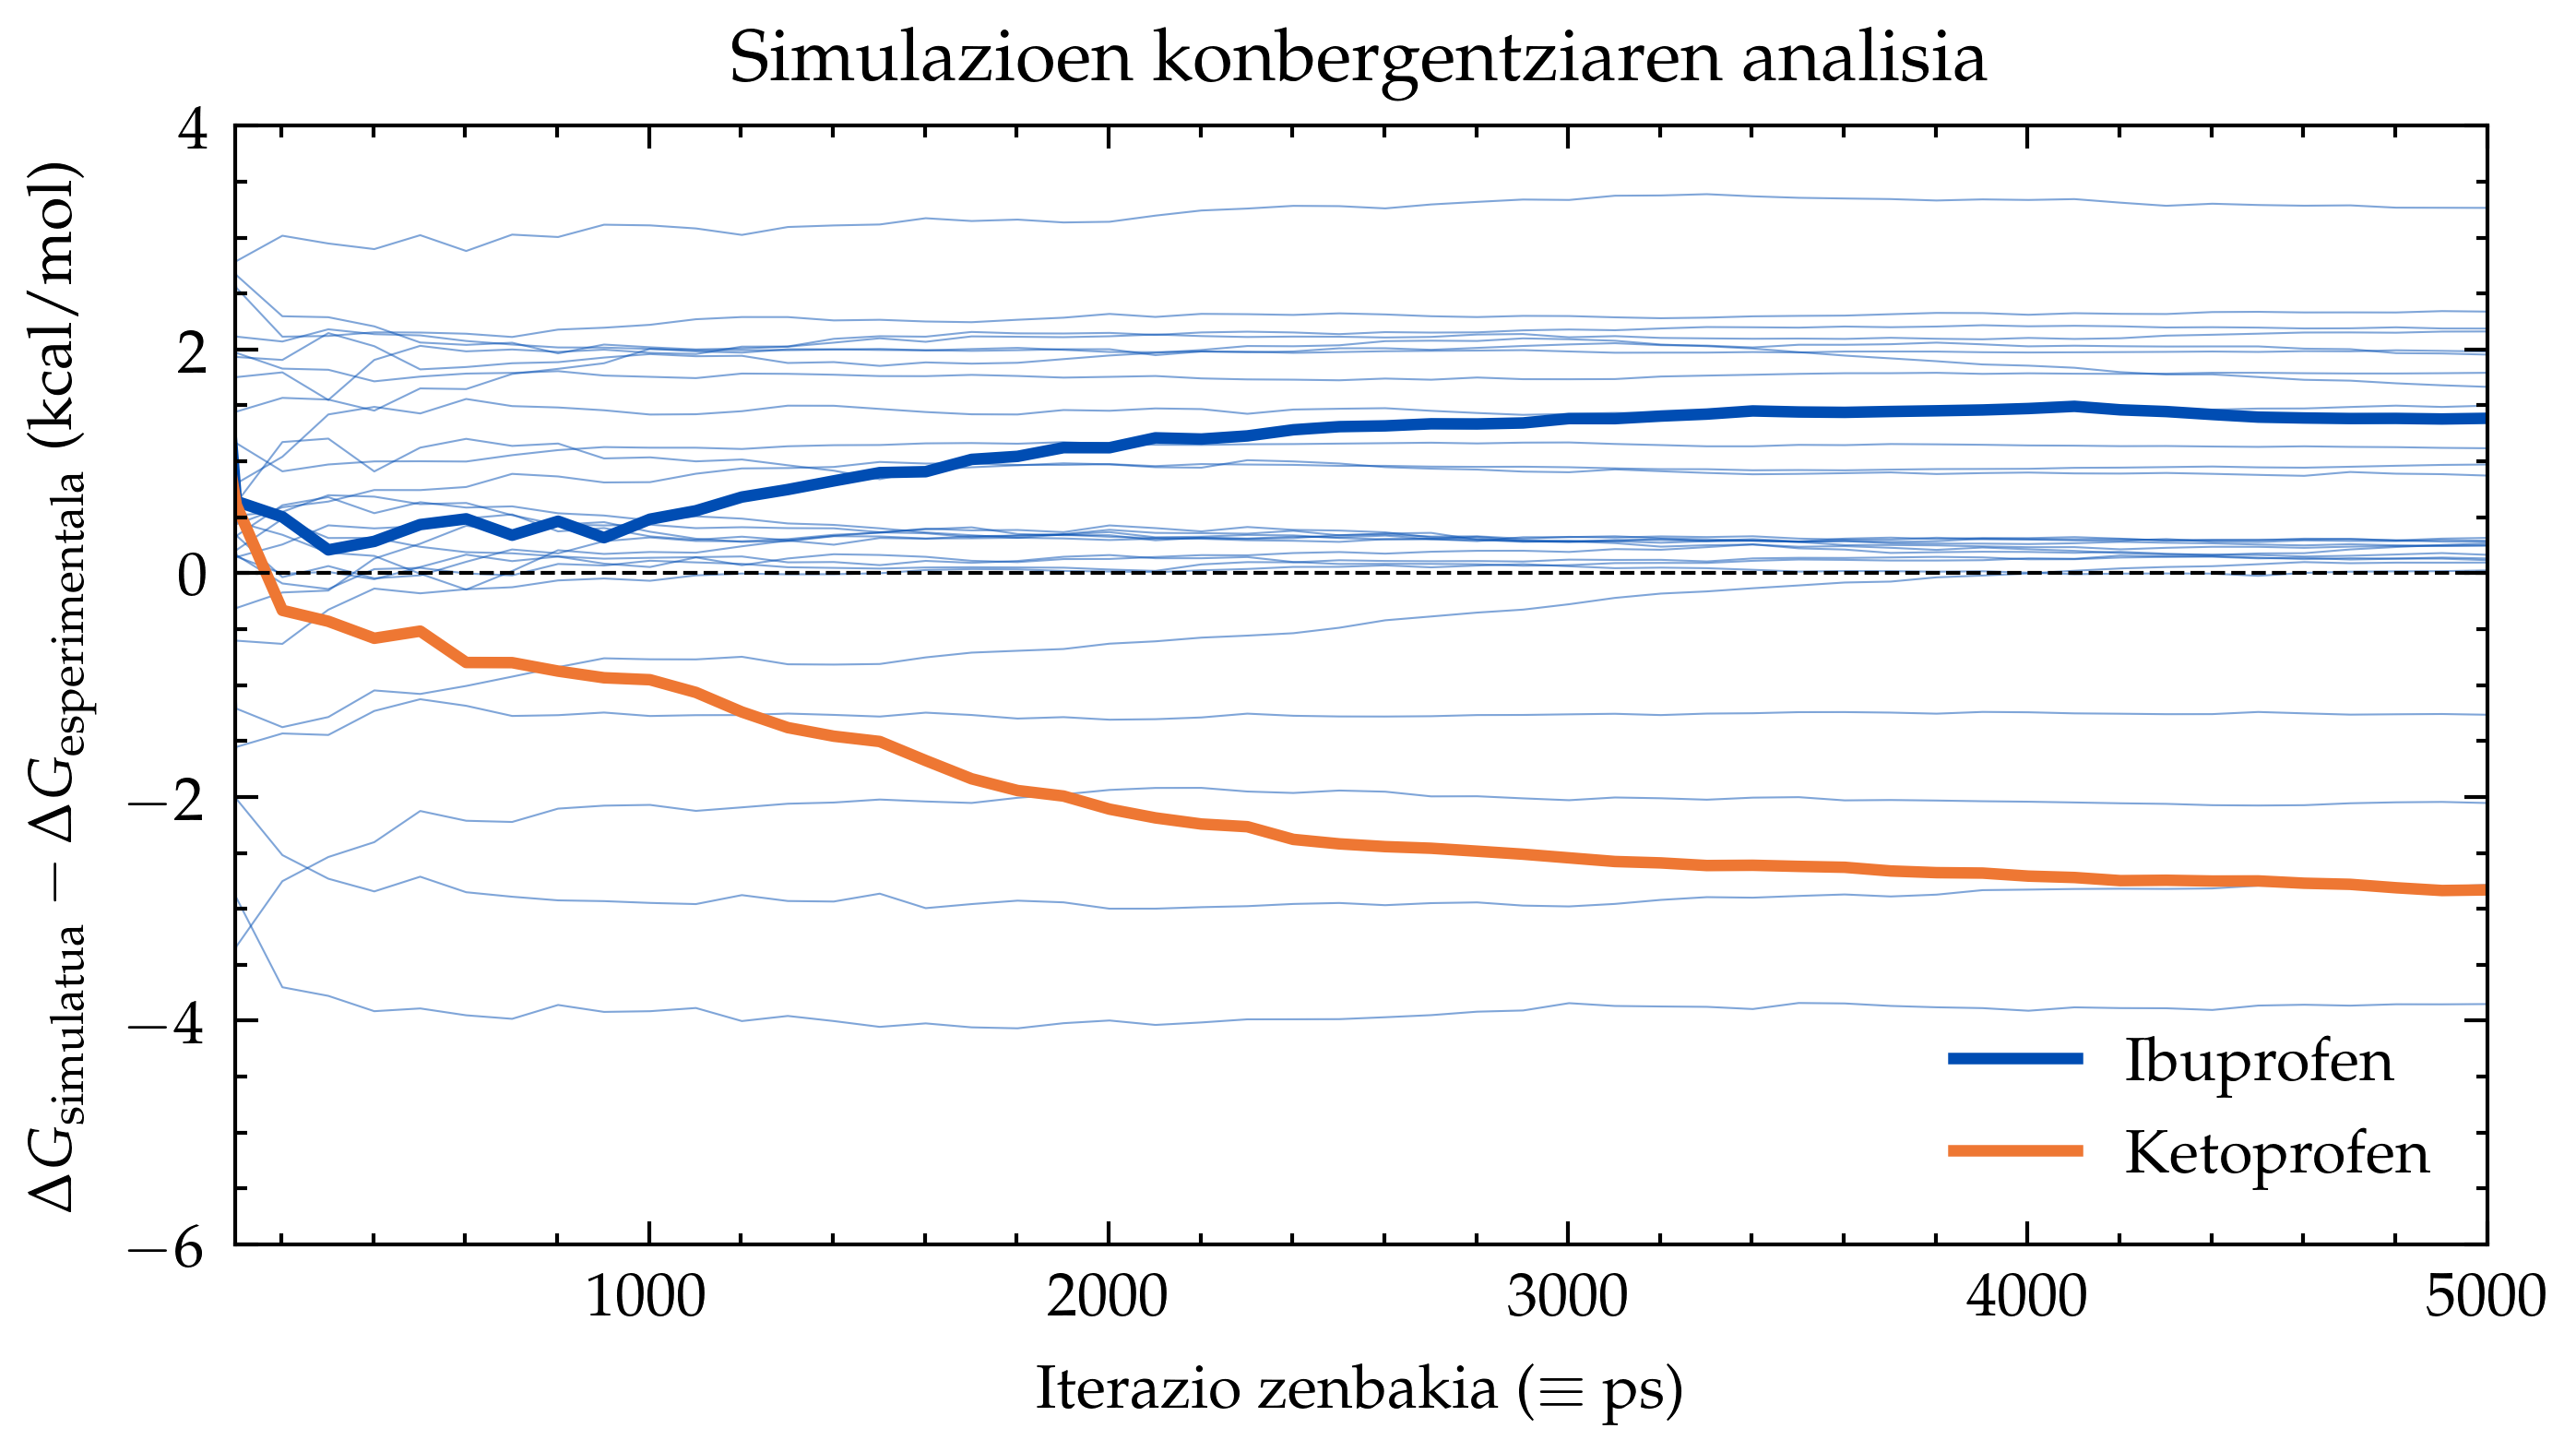

In [28]:
fig, ax = plt.subplots(figsize=(1.5*3.5, 2.625))

for molecule_name, convergence_data in conv_dict.items():
    x = list(convergence_data.keys())
    y = list(convergence_data.values())-data_dict_full['BAR'][molecule_name]['0_experimental_value']*np.ones(len(x))
    if molecule_name == 'ibuprofen':
        plt.plot(x, y, label=f'{molecule_name}'.capitalize(), ls='-', color='C0', zorder=1, linewidth=1.5)
    elif molecule_name == 'ketoprofen':
        plt.plot(x, y, label=f'{molecule_name}'.capitalize(), ls='-', color='C2', zorder=1, linewidth=1.5)
    else:
        plt.plot(x, y,  color='C0', linewidth=0.25, zorder=0,  alpha=0.5)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at converged values

plt.xlabel(r"Iterazio zenbakia ($\equiv$ ps)")
plt.ylabel(r"$\Delta G_\text{simulatua}-\Delta G_\text{esperimentala}$ (kcal/mol)")
plt.title(r"Simulazioen konbergentziaren analisia")
plt.legend()

plt.xlim([100,5000])
plt.ylim([-6,4])

plt.savefig('outputs/outputs_metrikak/konbergentzia_analisia_1.pdf')

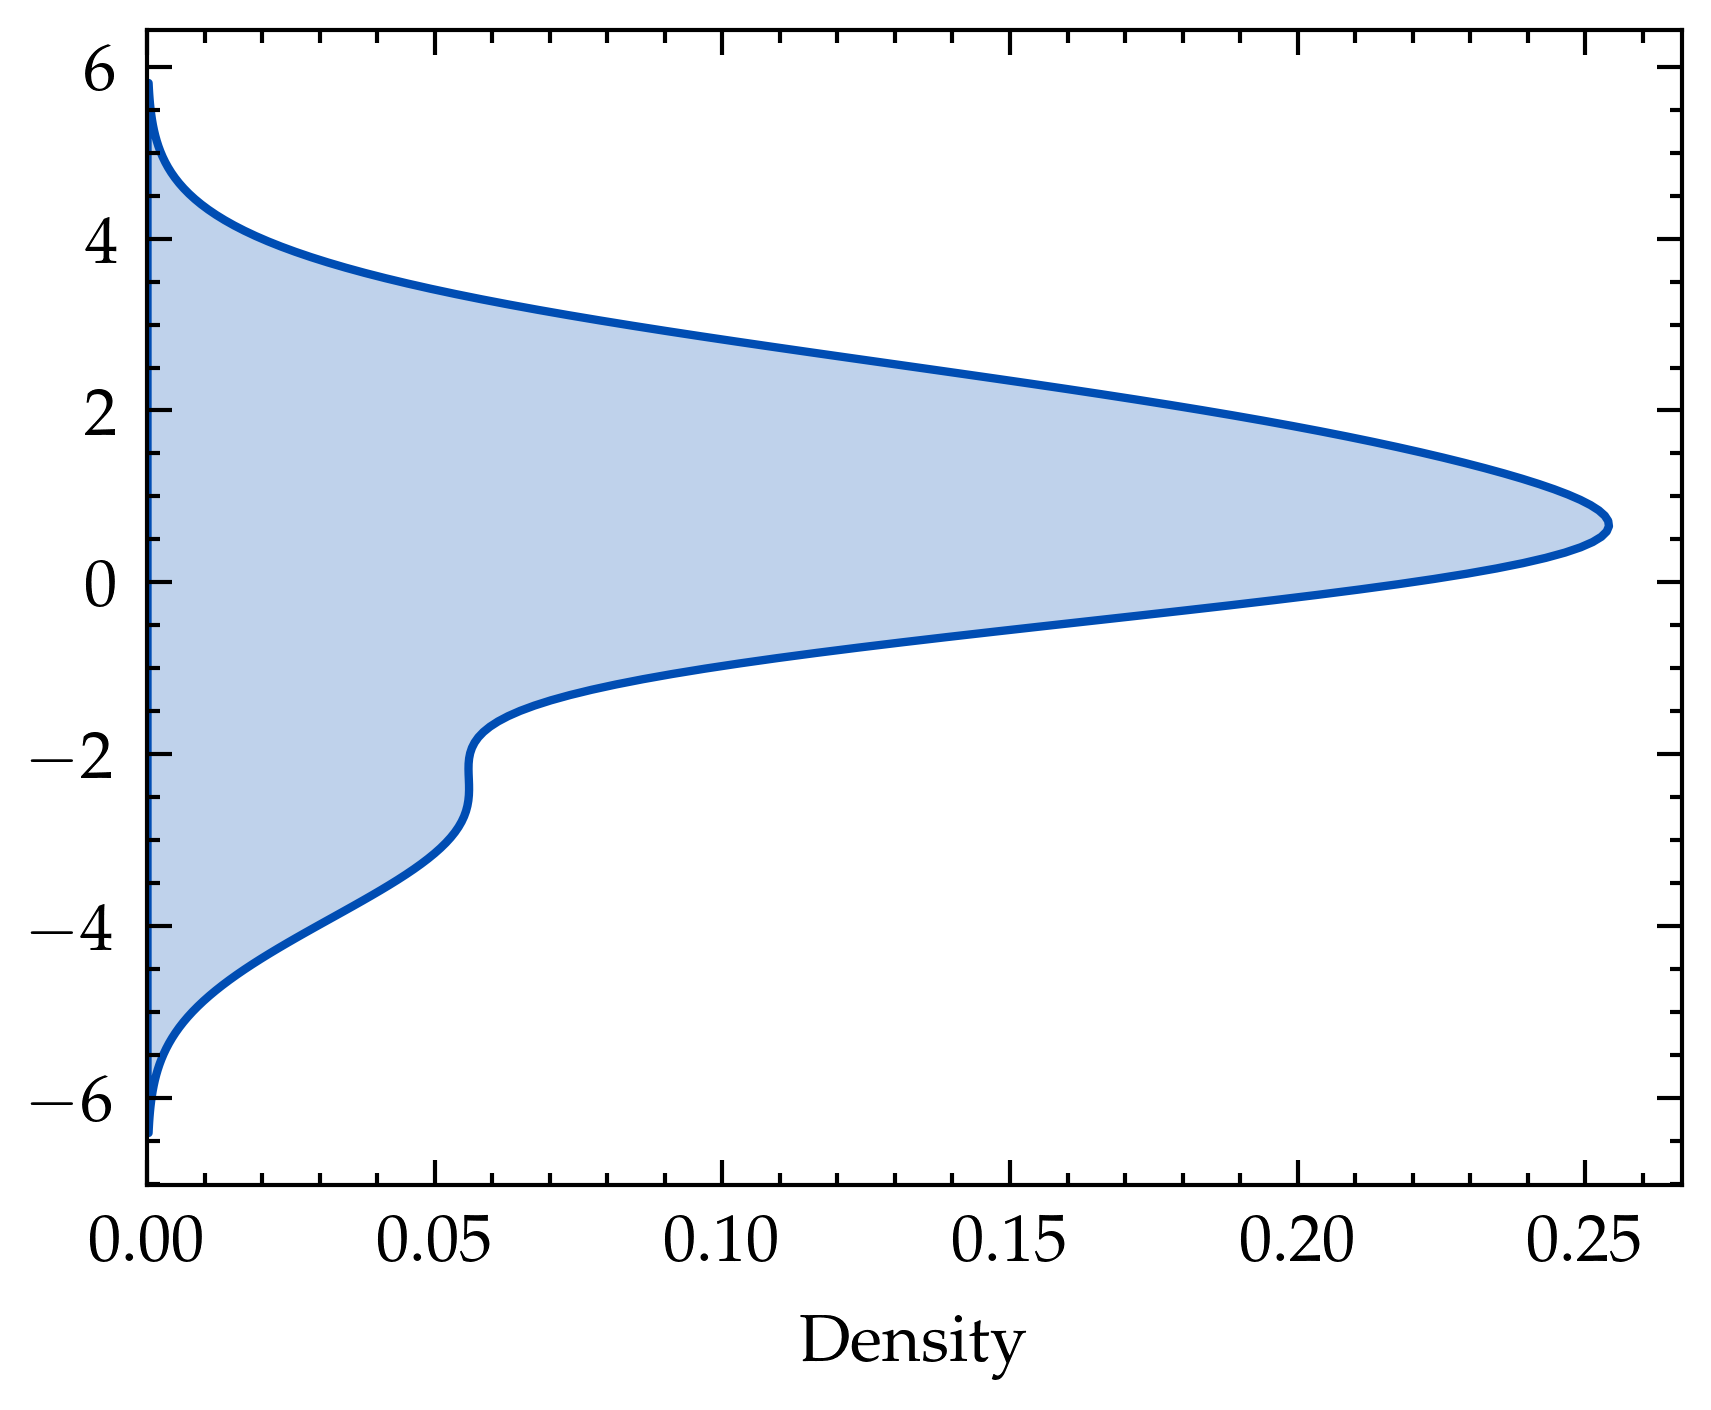

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

final_values = []

for molecule_name, convergence_data in conv_dict.items():
    final_values.append(convergence_data[max(convergence_data.keys())]-data_dict_full['BAR'][molecule_name]['0_experimental_value'])

sns.kdeplot(y=final_values, color='C0', fill=True)
plt.savefig('outputs/outputs_metrikak/konbergentzia_analisia_2.pdf')


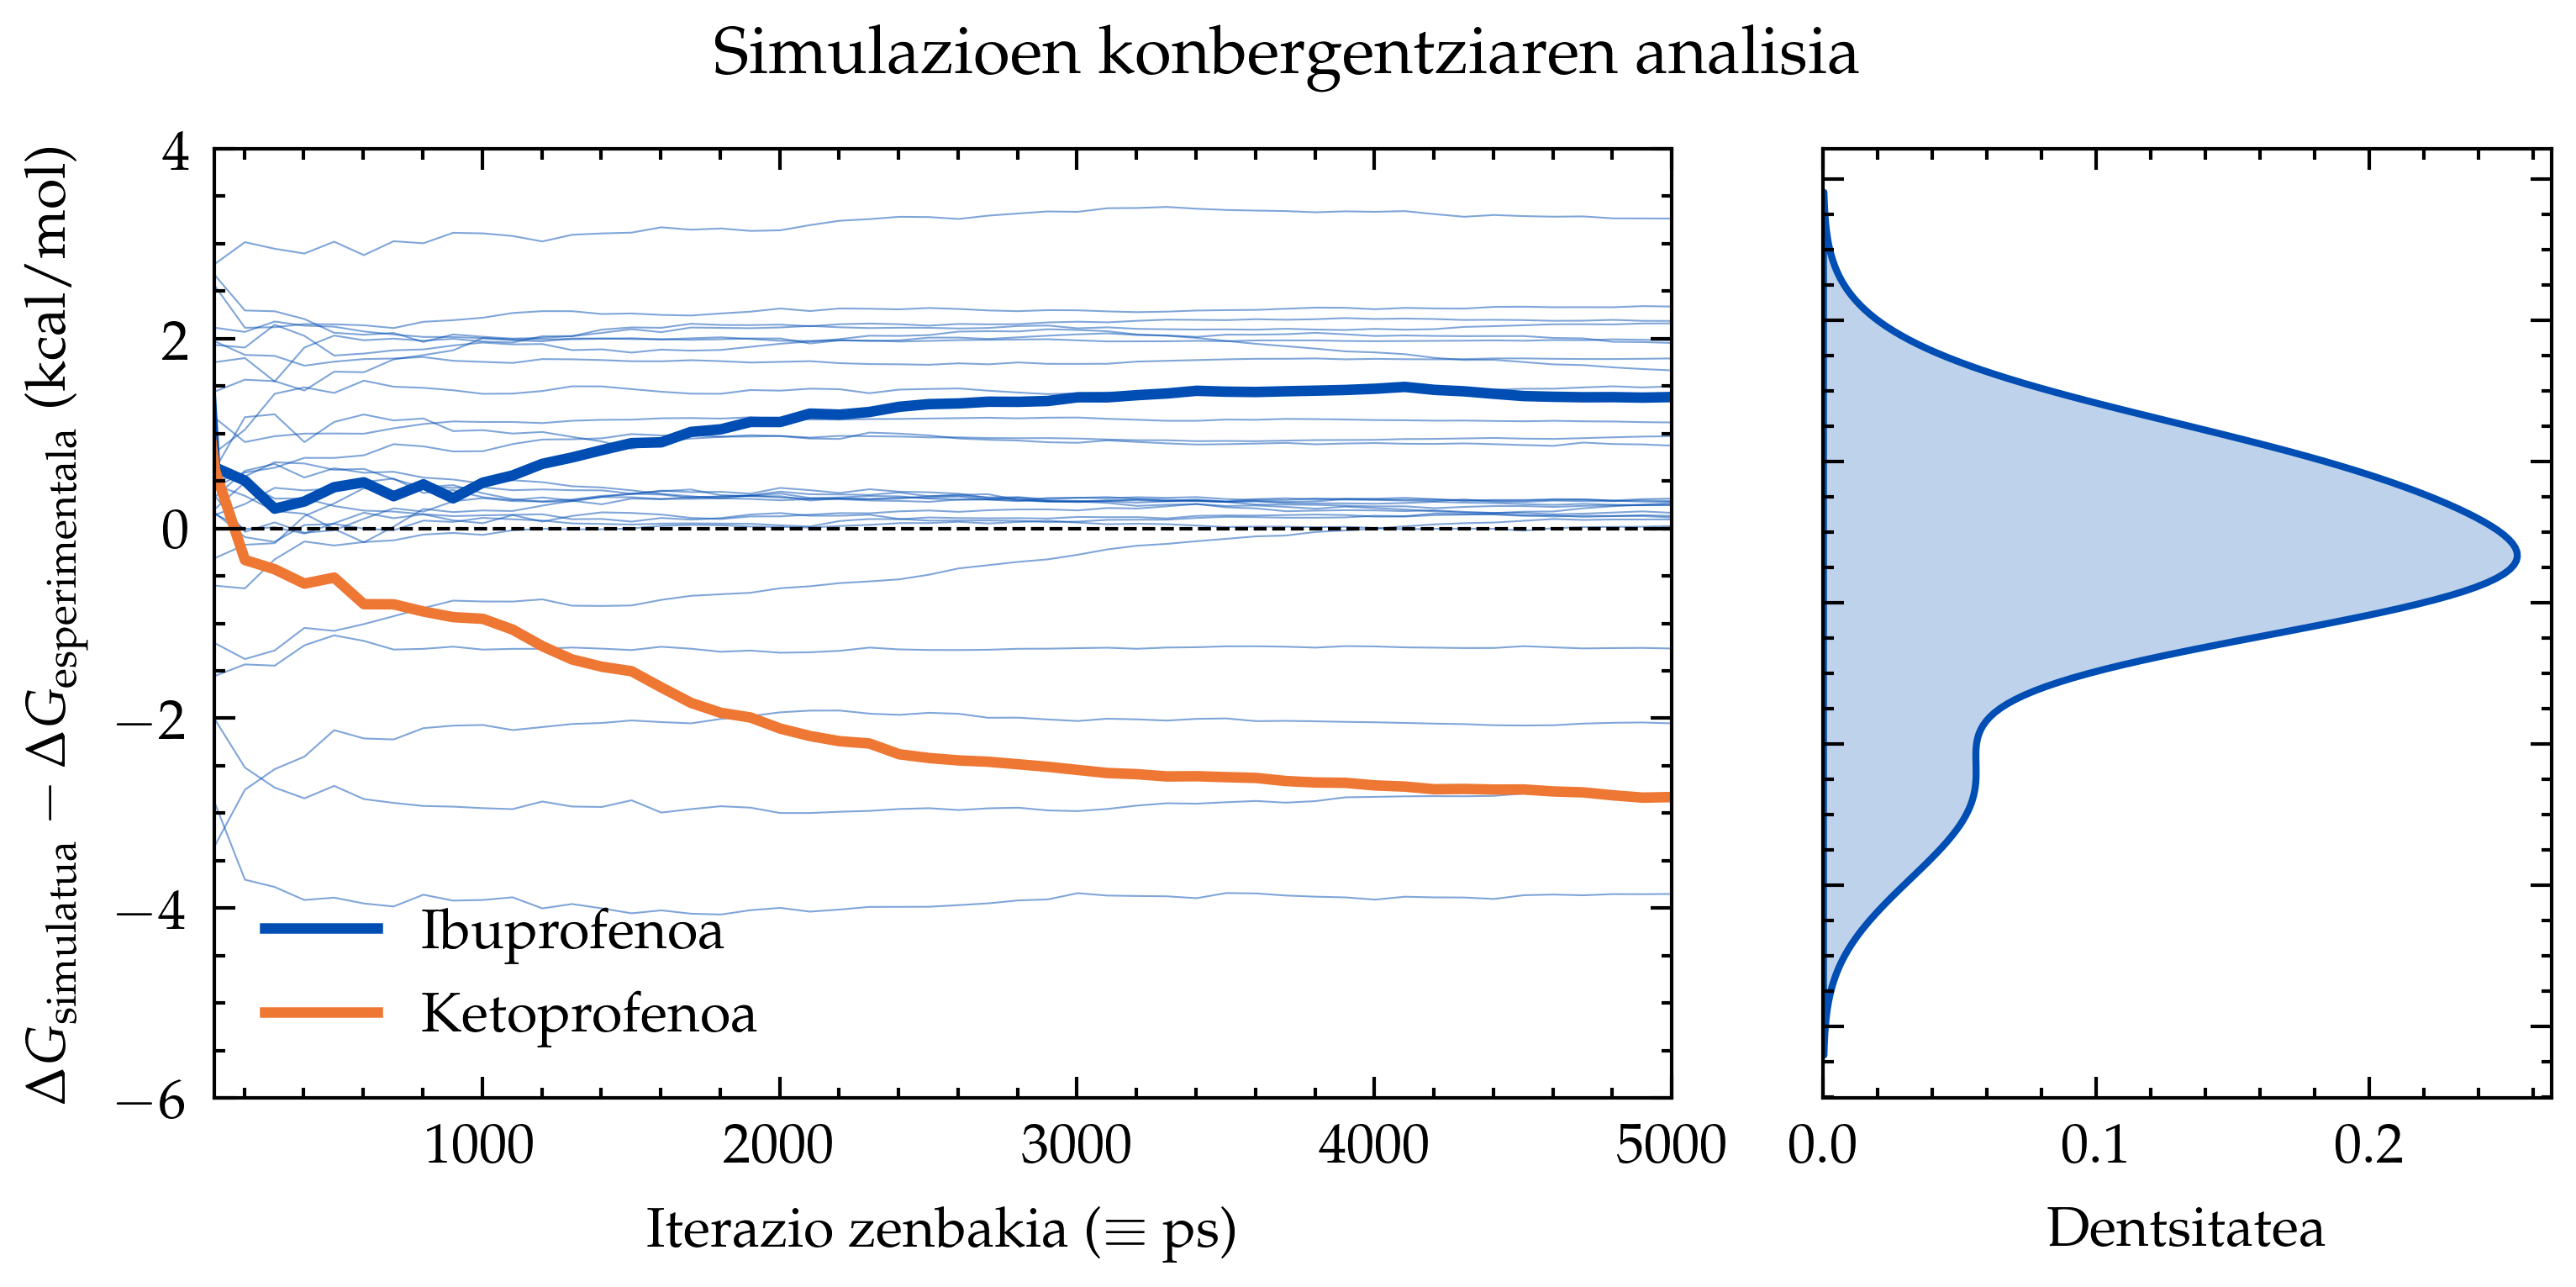

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 1x2 grid for the subplots
fig = plt.figure(figsize=(1.5*3.5, 2.625))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Create the first subplot
ax1 = plt.subplot(gs[0])
for molecule_name, convergence_data in conv_dict.items():
    x = list(convergence_data.keys())
    y = list(convergence_data.values())-data_dict_full['BAR'][molecule_name]['0_experimental_value']*np.ones(len(x))
    if molecule_name == 'ibuprofen':
        ax1.plot(x, y, label='Ibuprofenoa', color='C0', linewidth=1.5, zorder=1)
    elif molecule_name == 'ketoprofen':
        ax1.plot(x, y, label=f'Ketoprofenoa', color='C2', linewidth=1.5, zorder=1)
    else:
        ax1.plot(x, y,  color='C0', linewidth=0.25, zorder=0,  alpha=0.5)

ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at converged values

ax1.set_xlabel(r"Iterazio zenbakia ($\equiv$ ps)")
ax1.set_ylabel(r"$\Delta G_\text{simulatua}-\Delta G_\text{esperimentala}$ (kcal/mol)")
ax1.set_title(r" ")
ax1.legend()

ax1.set_xlim([100,5000])
ax1.set_ylim([-6,4])

# Create the second subplot
ax2 = plt.subplot(gs[1])
#ax2.set_title('Second Subplot')
ax2.set_xlabel('Dentsitatea')
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax2.set_yticklabels([])
sns.kdeplot(y=final_values, color='C0', fill=True)

plt.tight_layout()
plt.suptitle("Simulazioen konbergentziaren analisia")


plt.savefig('outputs/outputs_metrikak/konbergentzia_analisia.pdf')


### Metriken balio numerikoak kalkulatu

In [10]:
metrics_dict_erraza = dict()
metrics_dict_zaila = dict()

# Datu egitura hutsa sortu, eta balio esperimentalak sartu.
for metrics_dict in (metrics_dict_erraza, metrics_dict_zaila):
    # Create the dictionary to store all the data.
    # Estimators: forward, backward, BAR
    metrics_dict['forward'] = dict()
    metrics_dict['backward'] = dict()
    metrics_dict['BAR'] = dict()

    if metrics_dict == metrics_dict_erraza:
        df = erraza_df
        data_dict = data_dict_erraza
    else:
        df = zaila_df
        data_dict = data_dict_zaila
    molecule_names = list(df.name)
    for (comb_key, _, __) in combinations:
        metrics_dict['forward'][comb_key] = {'MAE' : calc_MAE(data_dict['forward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['forward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['forward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['forward'], comb_key, molecule_names)}
        metrics_dict['backward'][comb_key] = {'MAE' : calc_MAE(data_dict['backward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['backward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['backward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['backward'], comb_key, molecule_names)}
        metrics_dict['BAR'][comb_key] = {'MAE' : calc_MAE(data_dict['BAR'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict['BAR'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict['BAR'], comb_key, molecule_names), 'tau' : calc_tau(data_dict['BAR'], comb_key, molecule_names)}


In [11]:
metrics_dict_erraza['forward'], metrics_dict_erraza['backward'], metrics_dict_erraza['BAR']

({'B_NVT_NVTnp': {'MAE': 1.469957142857143,
   'MSE': 3.6015690404761904,
   'PCC': 0.9175370963618531,
   'tau': 0.7428571428571429},
  'D_NPT_NVTnp': {'MAE': 0.9235190476190477,
   'MSE': 1.5647823890476191,
   'PCC': 0.9516375416024123,
   'tau': 0.8285714285714286}},
 {'B_NVT_NVTnp': {'MAE': 1.4061761904761905,
   'MSE': 3.033438391904762,
   'PCC': 0.9216998806345498,
   'tau': 0.7333333333333333},
  'D_NPT_NVTnp': {'MAE': 1.0290142857142859,
   'MSE': 1.7405738823809525,
   'PCC': 0.9543711802108589,
   'tau': 0.8571428571428571}},
 {'B_NVT_NVTnp': {'MAE': 1.448709523809524,
   'MSE': 3.287995072857143,
   'PCC': 0.9199195221369478,
   'tau': 0.7333333333333333},
  'D_NPT_NVTnp': {'MAE': 1.0038857142857143,
   'MSE': 1.7067478704761905,
   'PCC': 0.9528095490230852,
   'tau': 0.8476190476190476}})

## Emaitzak irudikatzeko kodea

In [12]:
OUTPUT_PATH = 'outputs/outputs_metrikak/'
os.makedirs(OUTPUT_PATH+'errazak/', exist_ok=True)
os.makedirs(OUTPUT_PATH+'zailak/', exist_ok=True)

def plot_combination(data_dict, metrics_dict, comb_key):
    comb_key_0 = 'B_NVT_NVTnp' # Erreferentziazko konfigurazioa

    X = []      # X -> balio esperimentalak
    Y_0 = []    # Y -> kalkulatutako balioak, erreferentzia
    Y = []      # Y -> kalkulatutako balioak

    for molecule_name in molecule_names:
        X.append(data_dict[molecule_name]['0_experimental_value'])
        Y_0.append(data_dict[molecule_name][comb_key_0])
        Y.append(data_dict[molecule_name][comb_key])

    fig, ax = plt.subplots(figsize=(1.25*3.5, 1.25*2.625))
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = set(Y_0+Y+list(X_range))
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen analisia: {comb_key[2:].replace('_','--')}")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)
    
    legend_0 = f"{comb_key_0[2:]}\nMAE: {metrics_dict[comb_key_0]['MAE']:>8.4f}\nMSE: {metrics_dict[comb_key_0]['MSE']:>8.4f}\nPCC:  {metrics_dict[comb_key_0]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict[comb_key_0]['tau']:>8.4f}"
    legend_1 = f"{comb_key[2:]}\nMAE: {metrics_dict[comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict[comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict[comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict[comb_key]['tau']:>8.4f}"
    
    ax.scatter(X, Y_0, label=legend_0, color='C0', zorder=1, edgecolor='none')
    ax.scatter(X, Y, label=legend_1, marker='s', color='C1', zorder=1, edgecolor='none') 

    legend = ax.legend(loc=4,frameon=True)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig
    #fig.savefig("NVTn lortutako emaitzen analisia.png", dpi=400)
    #plt.close()   


def plot_combination_fbbar(data_dict, metrics_dict, comb_key, fig_size=(3.5, 2.625), legend_font_size=6):
    X = []      # X -> balio esperimentalak
    Y_0 = []    # Y -> kalkulatutako balioak, erreferentzia
    Y = []      # Y -> kalkulatutako balioak
    Y_BAR = []      # Y -> kalkulatutako balioak

    for molecule_name in molecule_names:
        X.append(data_dict['forward'][molecule_name]['0_experimental_value'])
        Y_0.append(data_dict['forward'][molecule_name][comb_key])
        Y.append(data_dict['backward'][molecule_name][comb_key])
        Y_BAR.append(data_dict['BAR'][molecule_name][comb_key])

    #fig, ax = plt.subplots(figsize=(1.4*3.5, 1.4*2.625))
    fig, ax = plt.subplots(figsize=fig_size)
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+2])
    y_all = set(Y_0+Y+Y_BAR+list(X_range))
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen analisia: {comb_key[2:].replace('_','--')}")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)
    
    legend_0 = r"\textbf{FEP Aurrera}"+f"\nMAE: {metrics_dict['forward'][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict['forward'][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict['forward'][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict['forward'][comb_key]['tau']:>8.4f}"
    legend_1 = r"\textbf{FEP Atzera}"+f"\nMAE: {metrics_dict['backward'][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict['backward'][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict['backward'][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict['backward'][comb_key]['tau']:>8.4f}"
    legend_2 = r"\textbf{BAR}"+f"\nMAE: {metrics_dict['BAR'][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict['BAR'][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict['BAR'][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict['BAR'][comb_key]['tau']:>8.4f}"
    

    ax.scatter(X, Y_0, label=legend_0, marker='s', color='C0', zorder=1, edgecolor='none')
    ax.scatter(X, Y, label=legend_1, marker='o', color='C1',  zorder=2,  edgecolor='none') 
    ax.scatter(X, Y_BAR,  label=legend_2, marker='^', color='C2', zorder=3, edgecolor='none') 

    #ax.legend()
    #ax.legend(loc=4)
    legend = ax.legend(frameon=True, loc=4, fontsize=legend_font_size)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig


### Molekula errazak

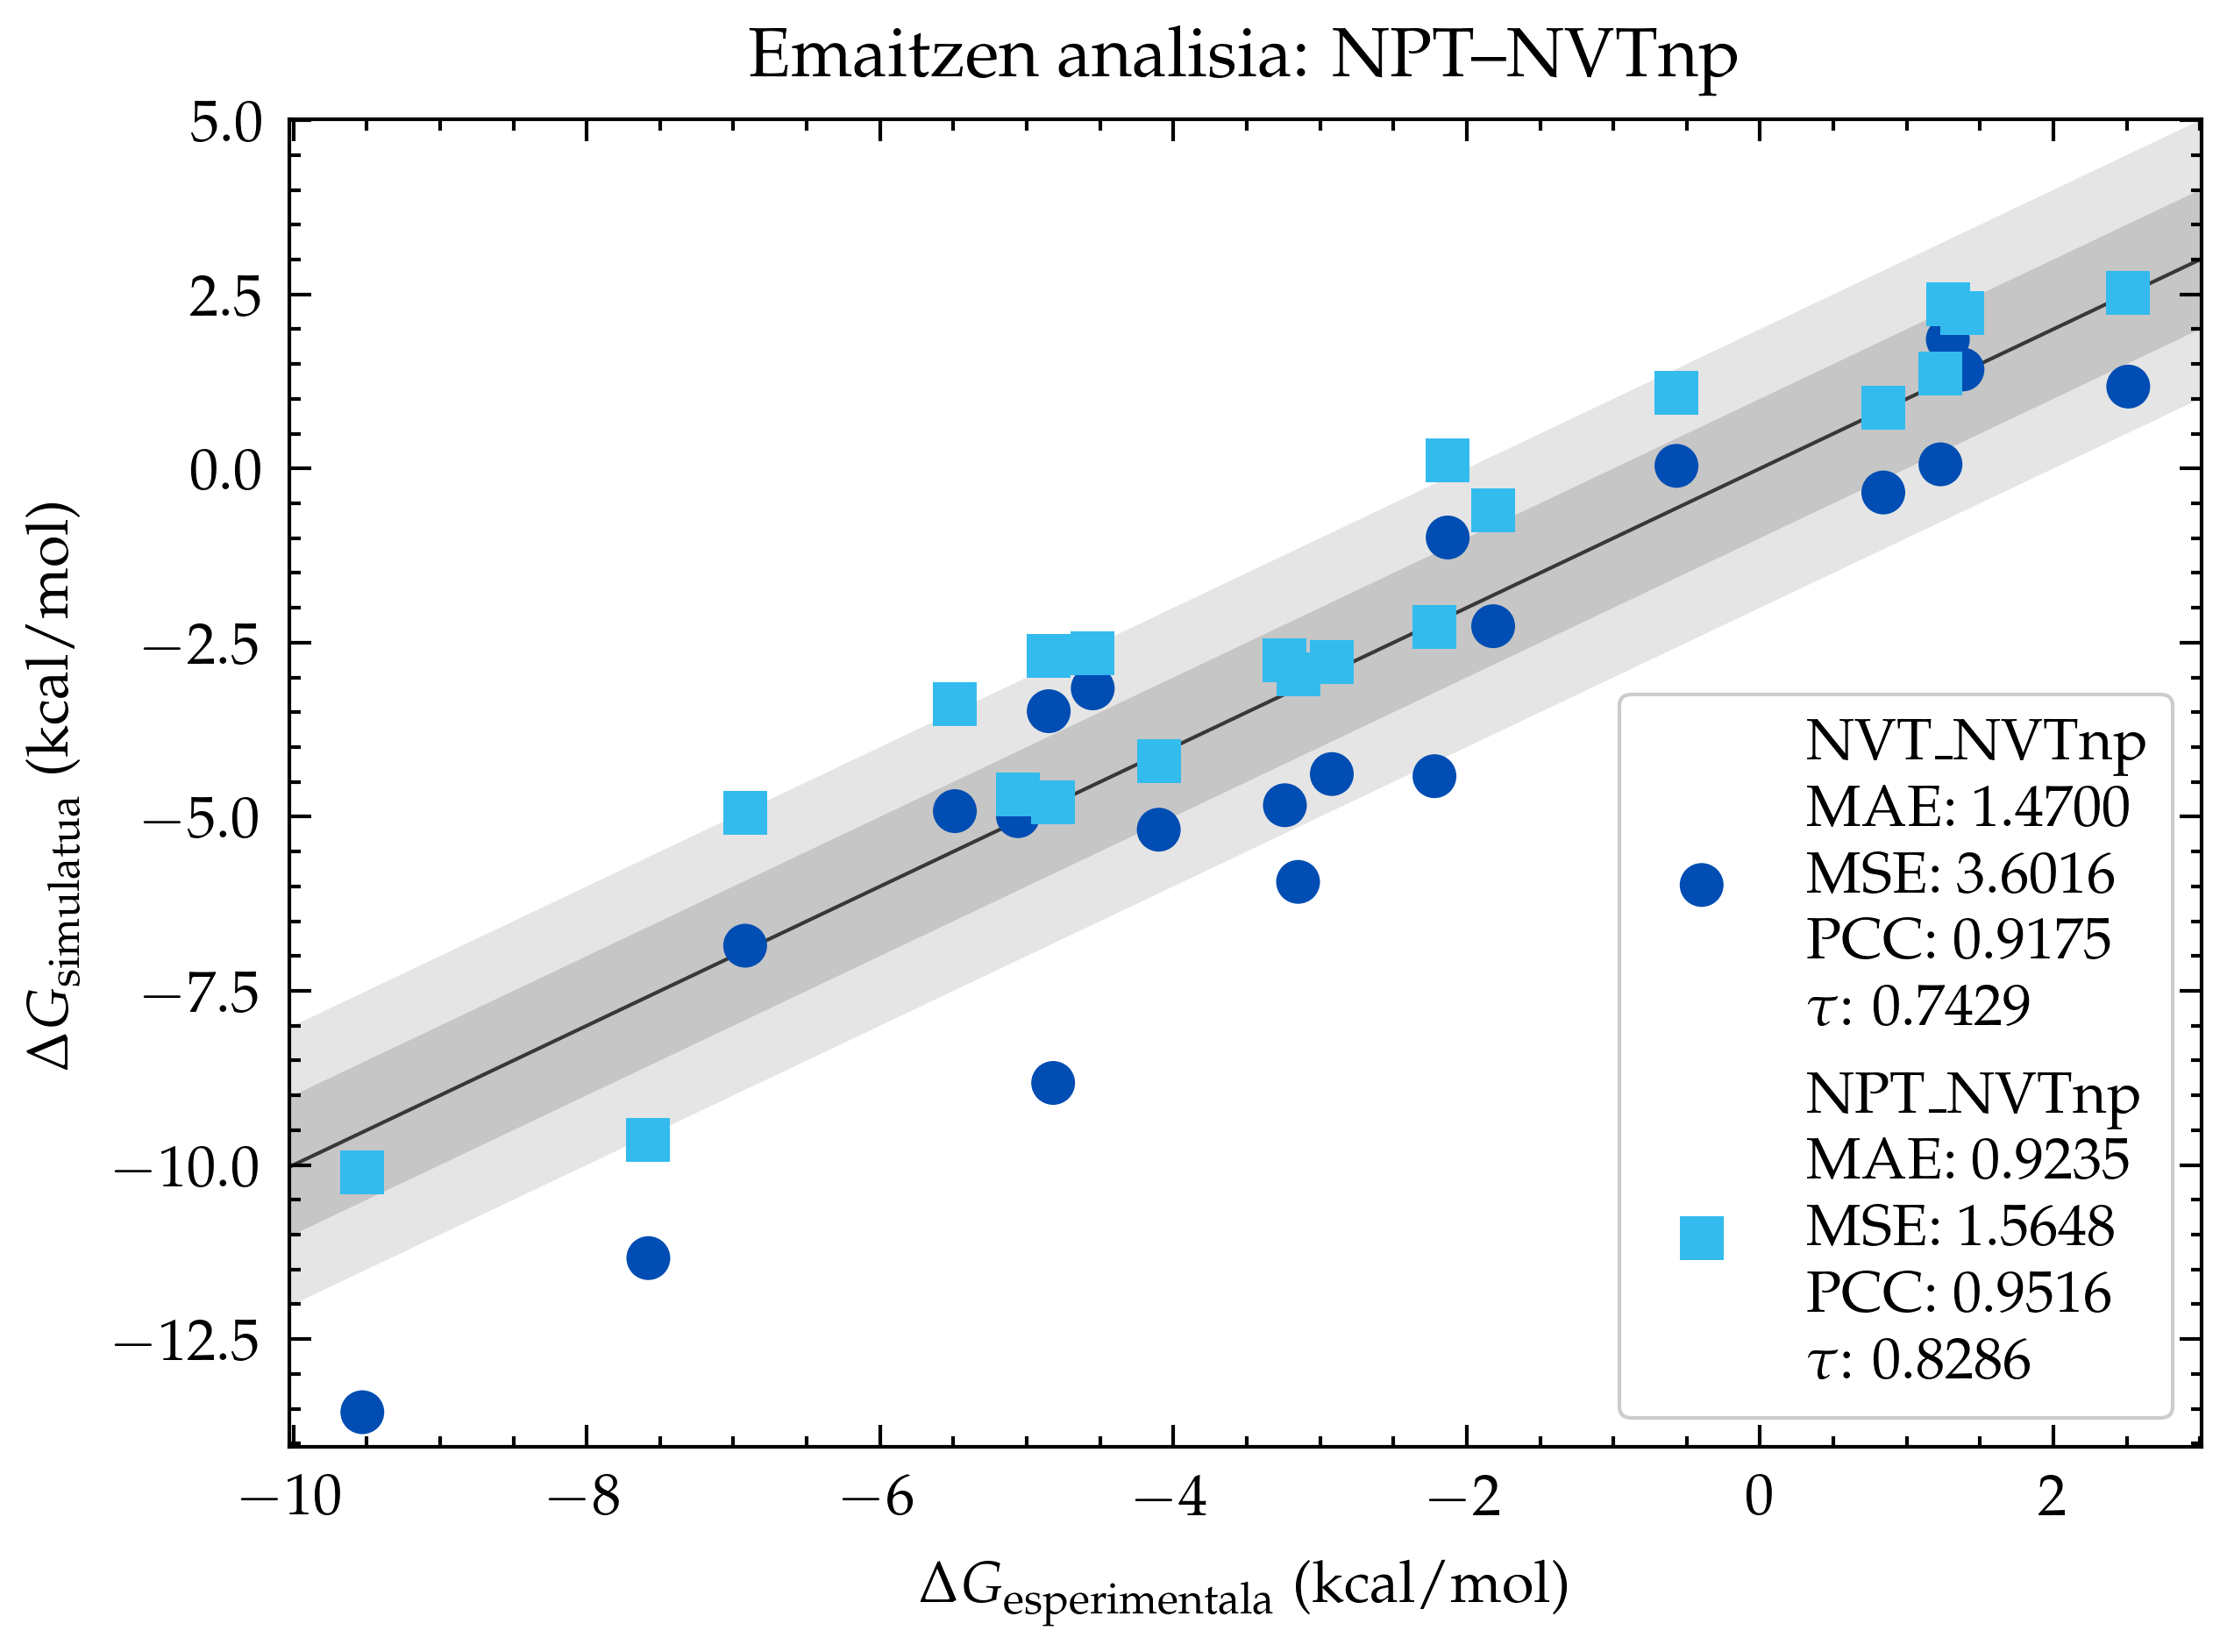

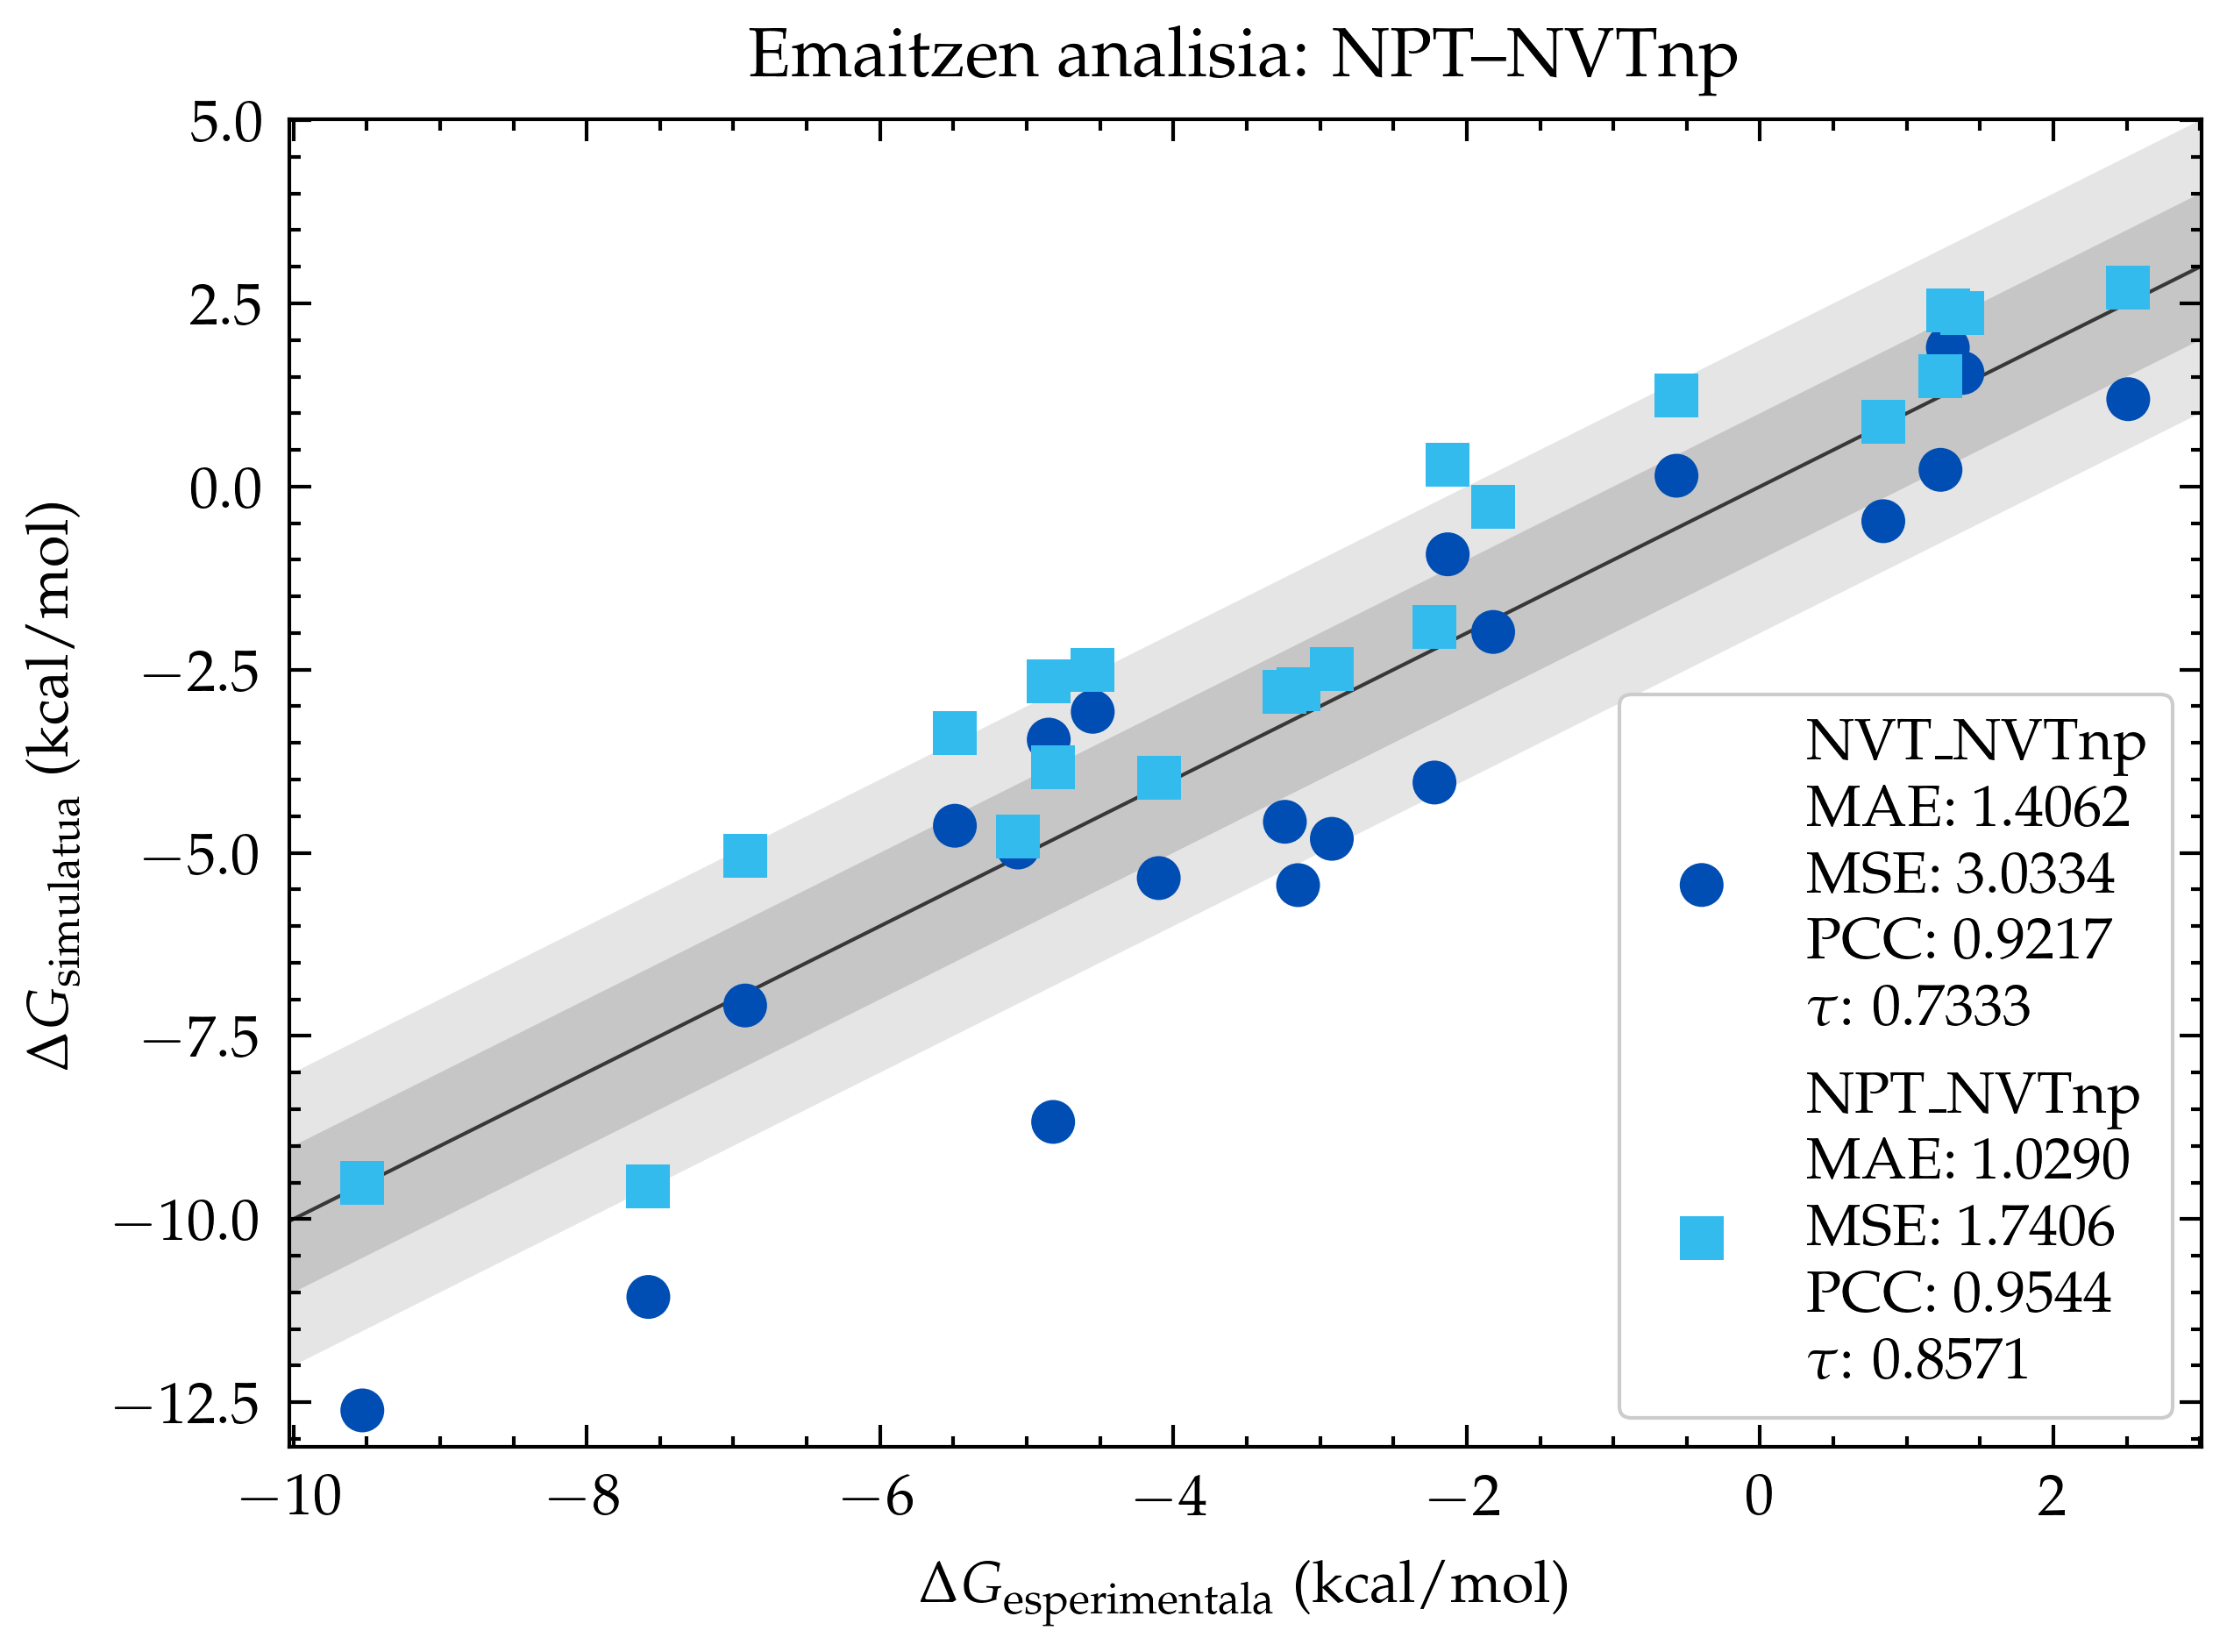

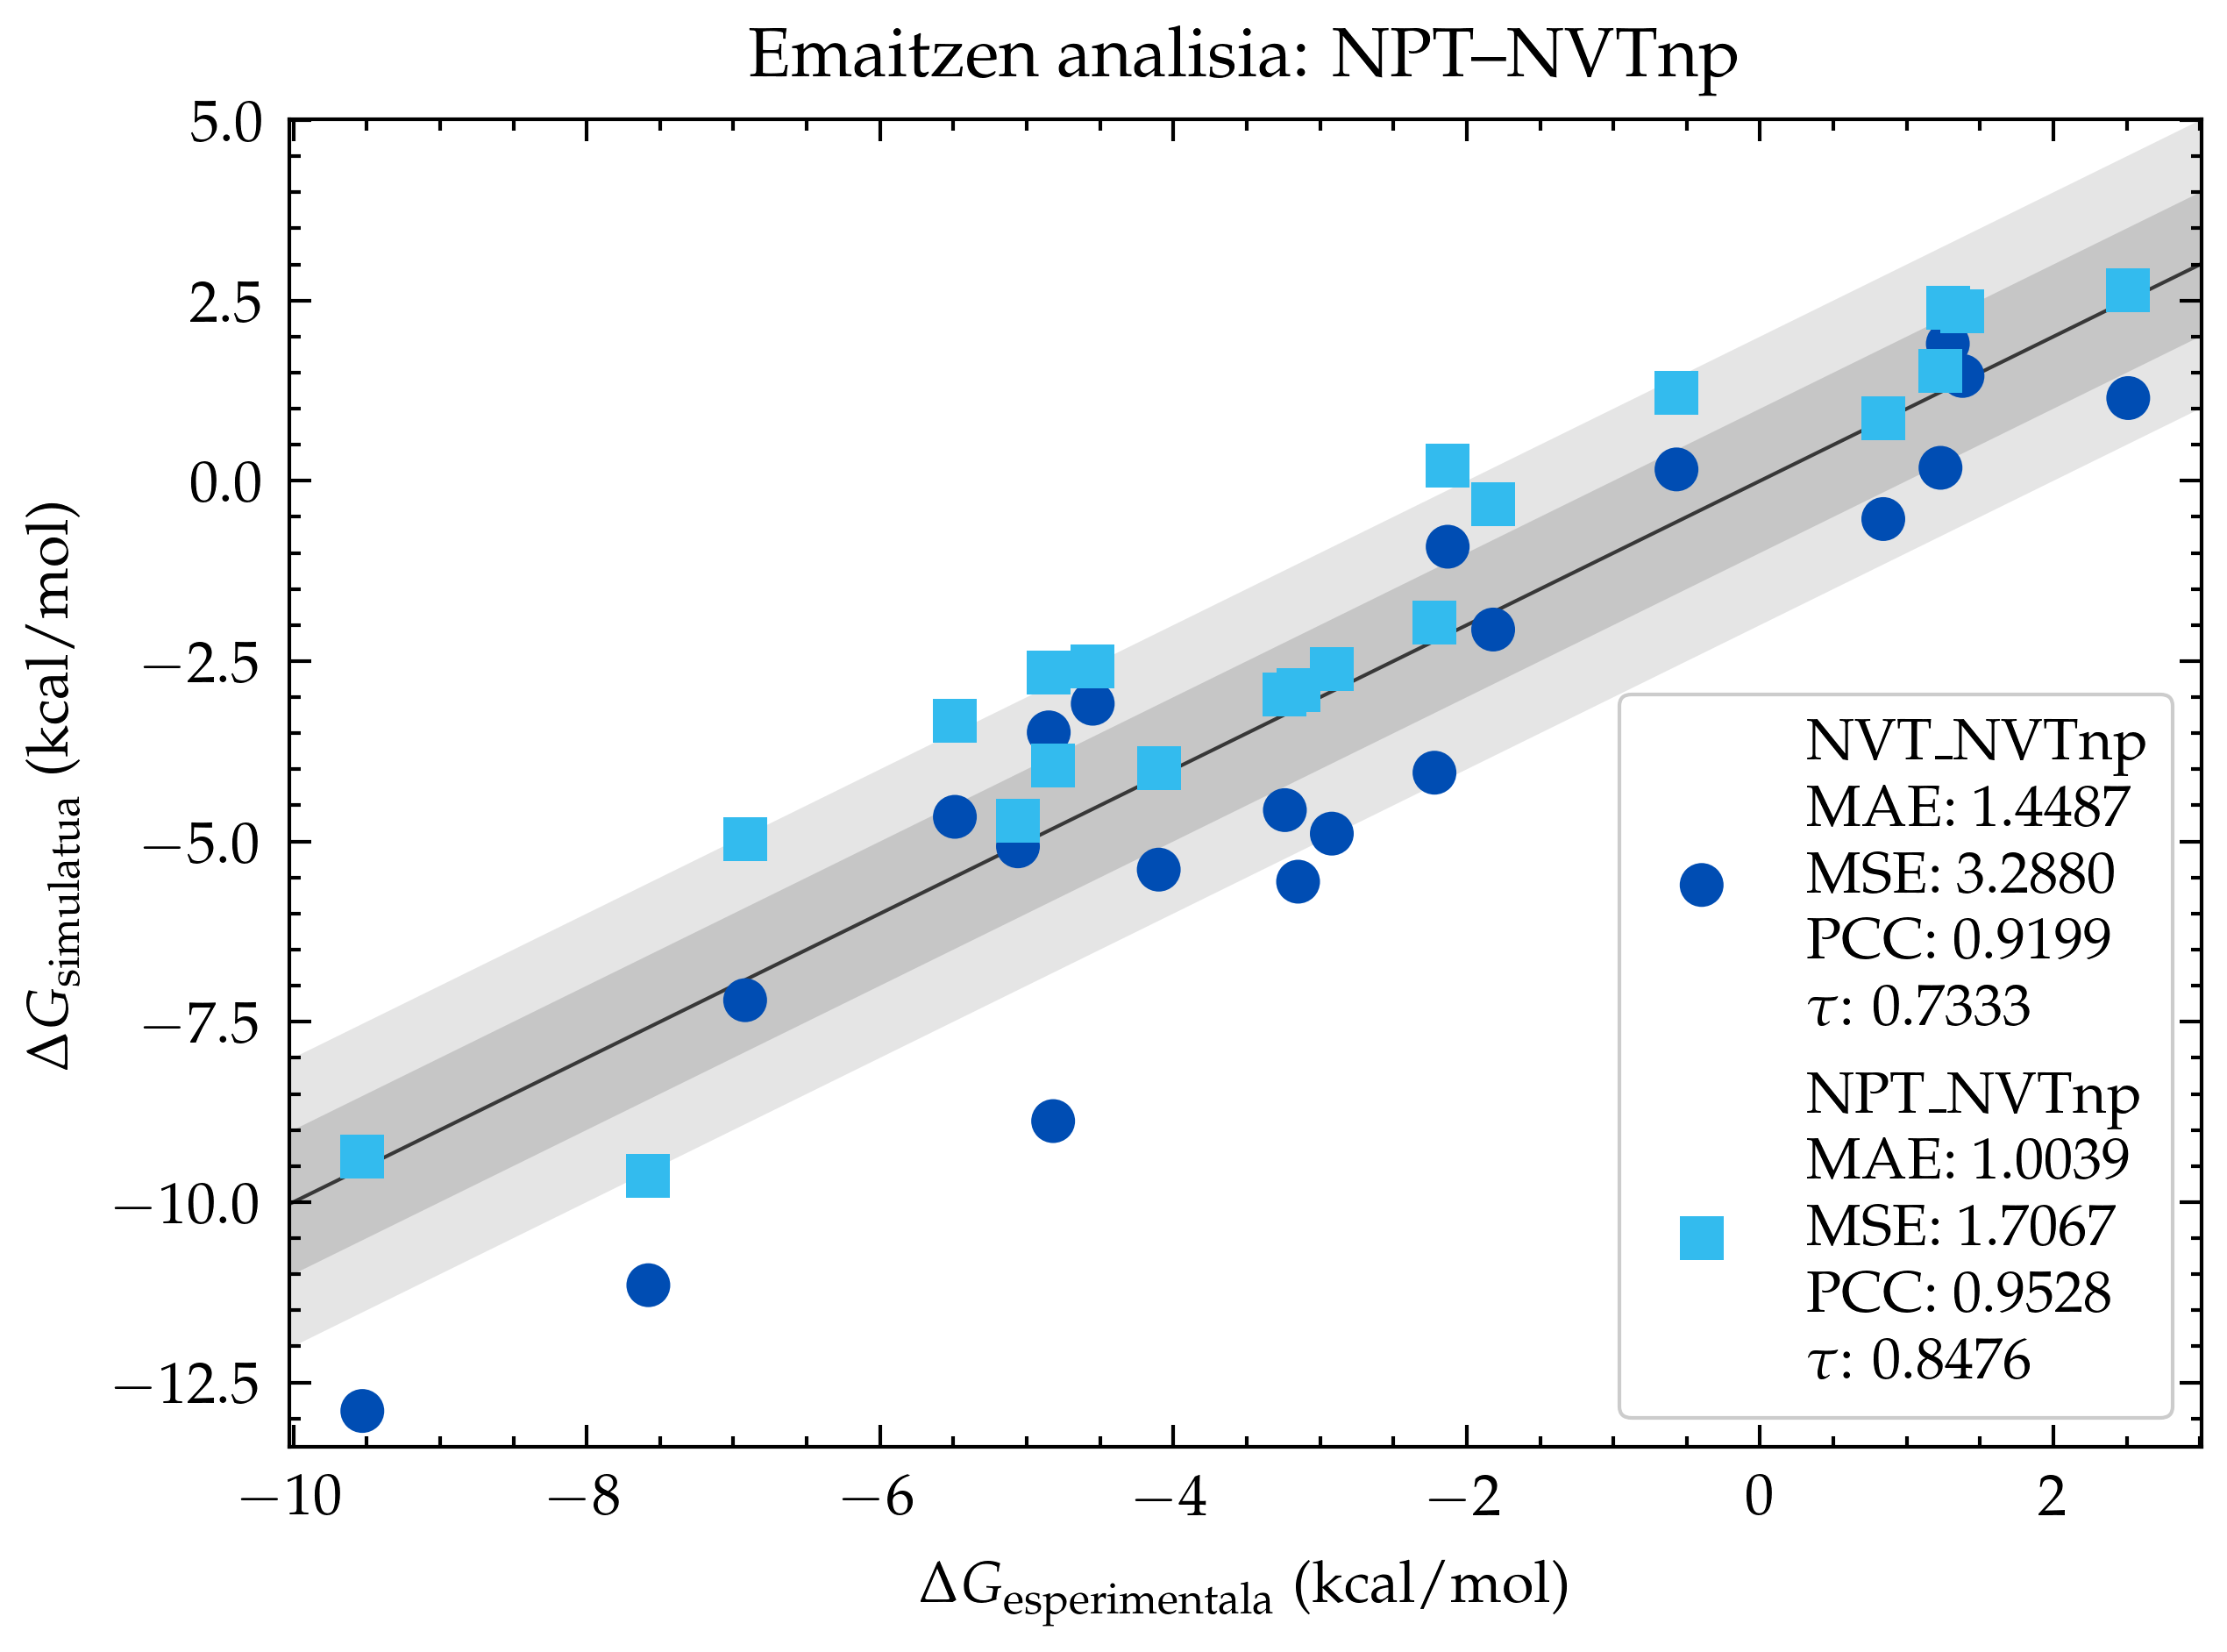

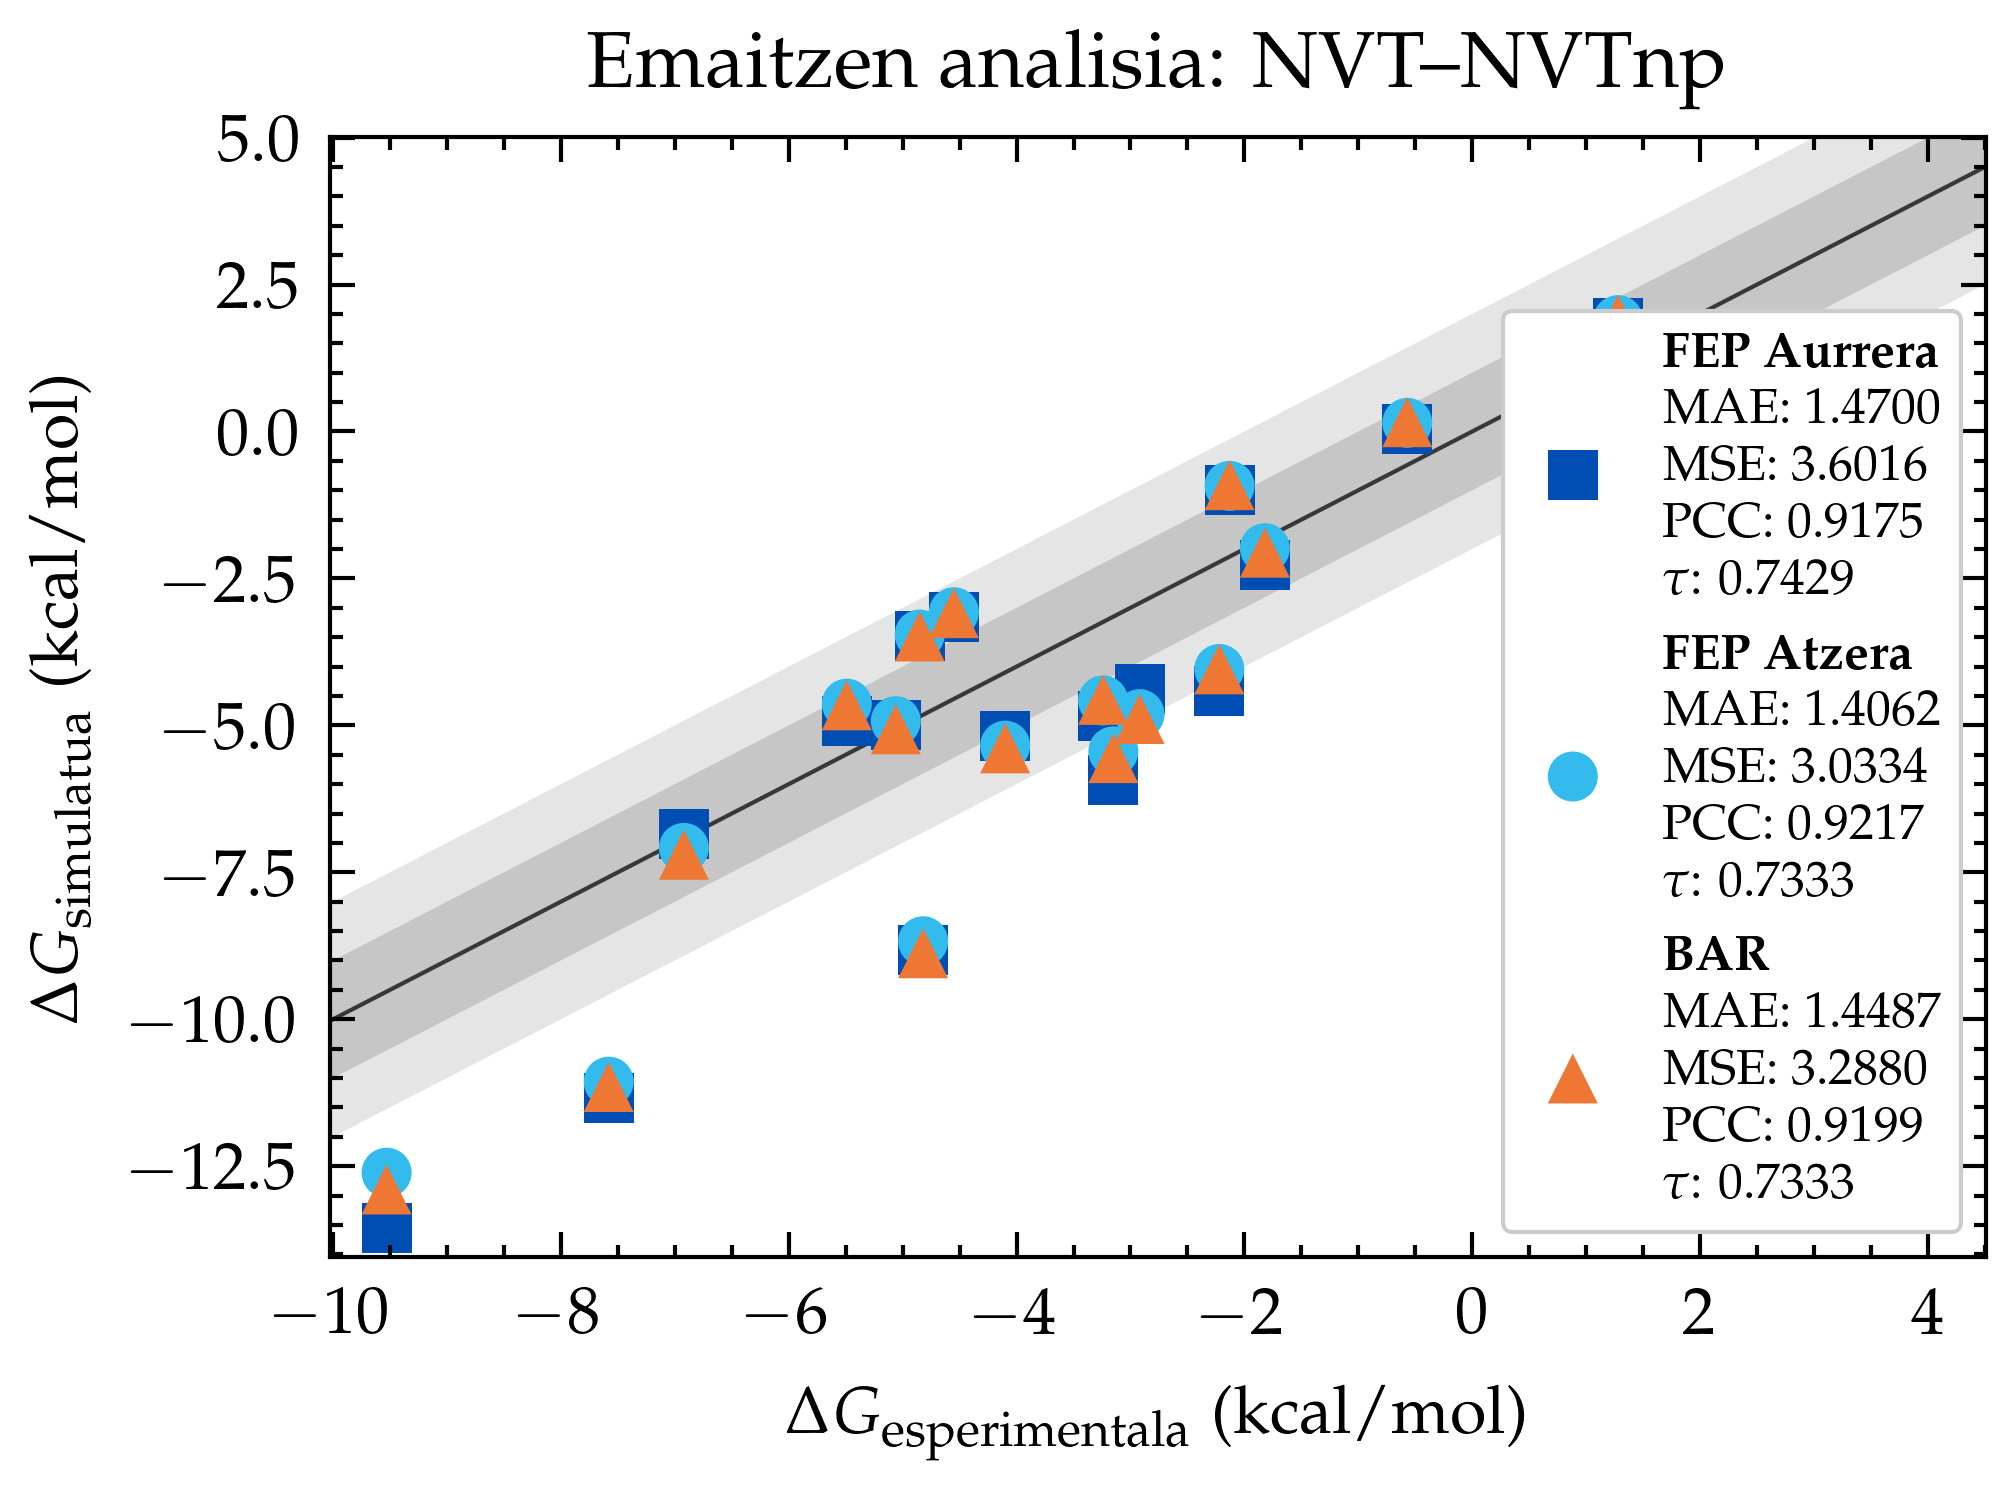

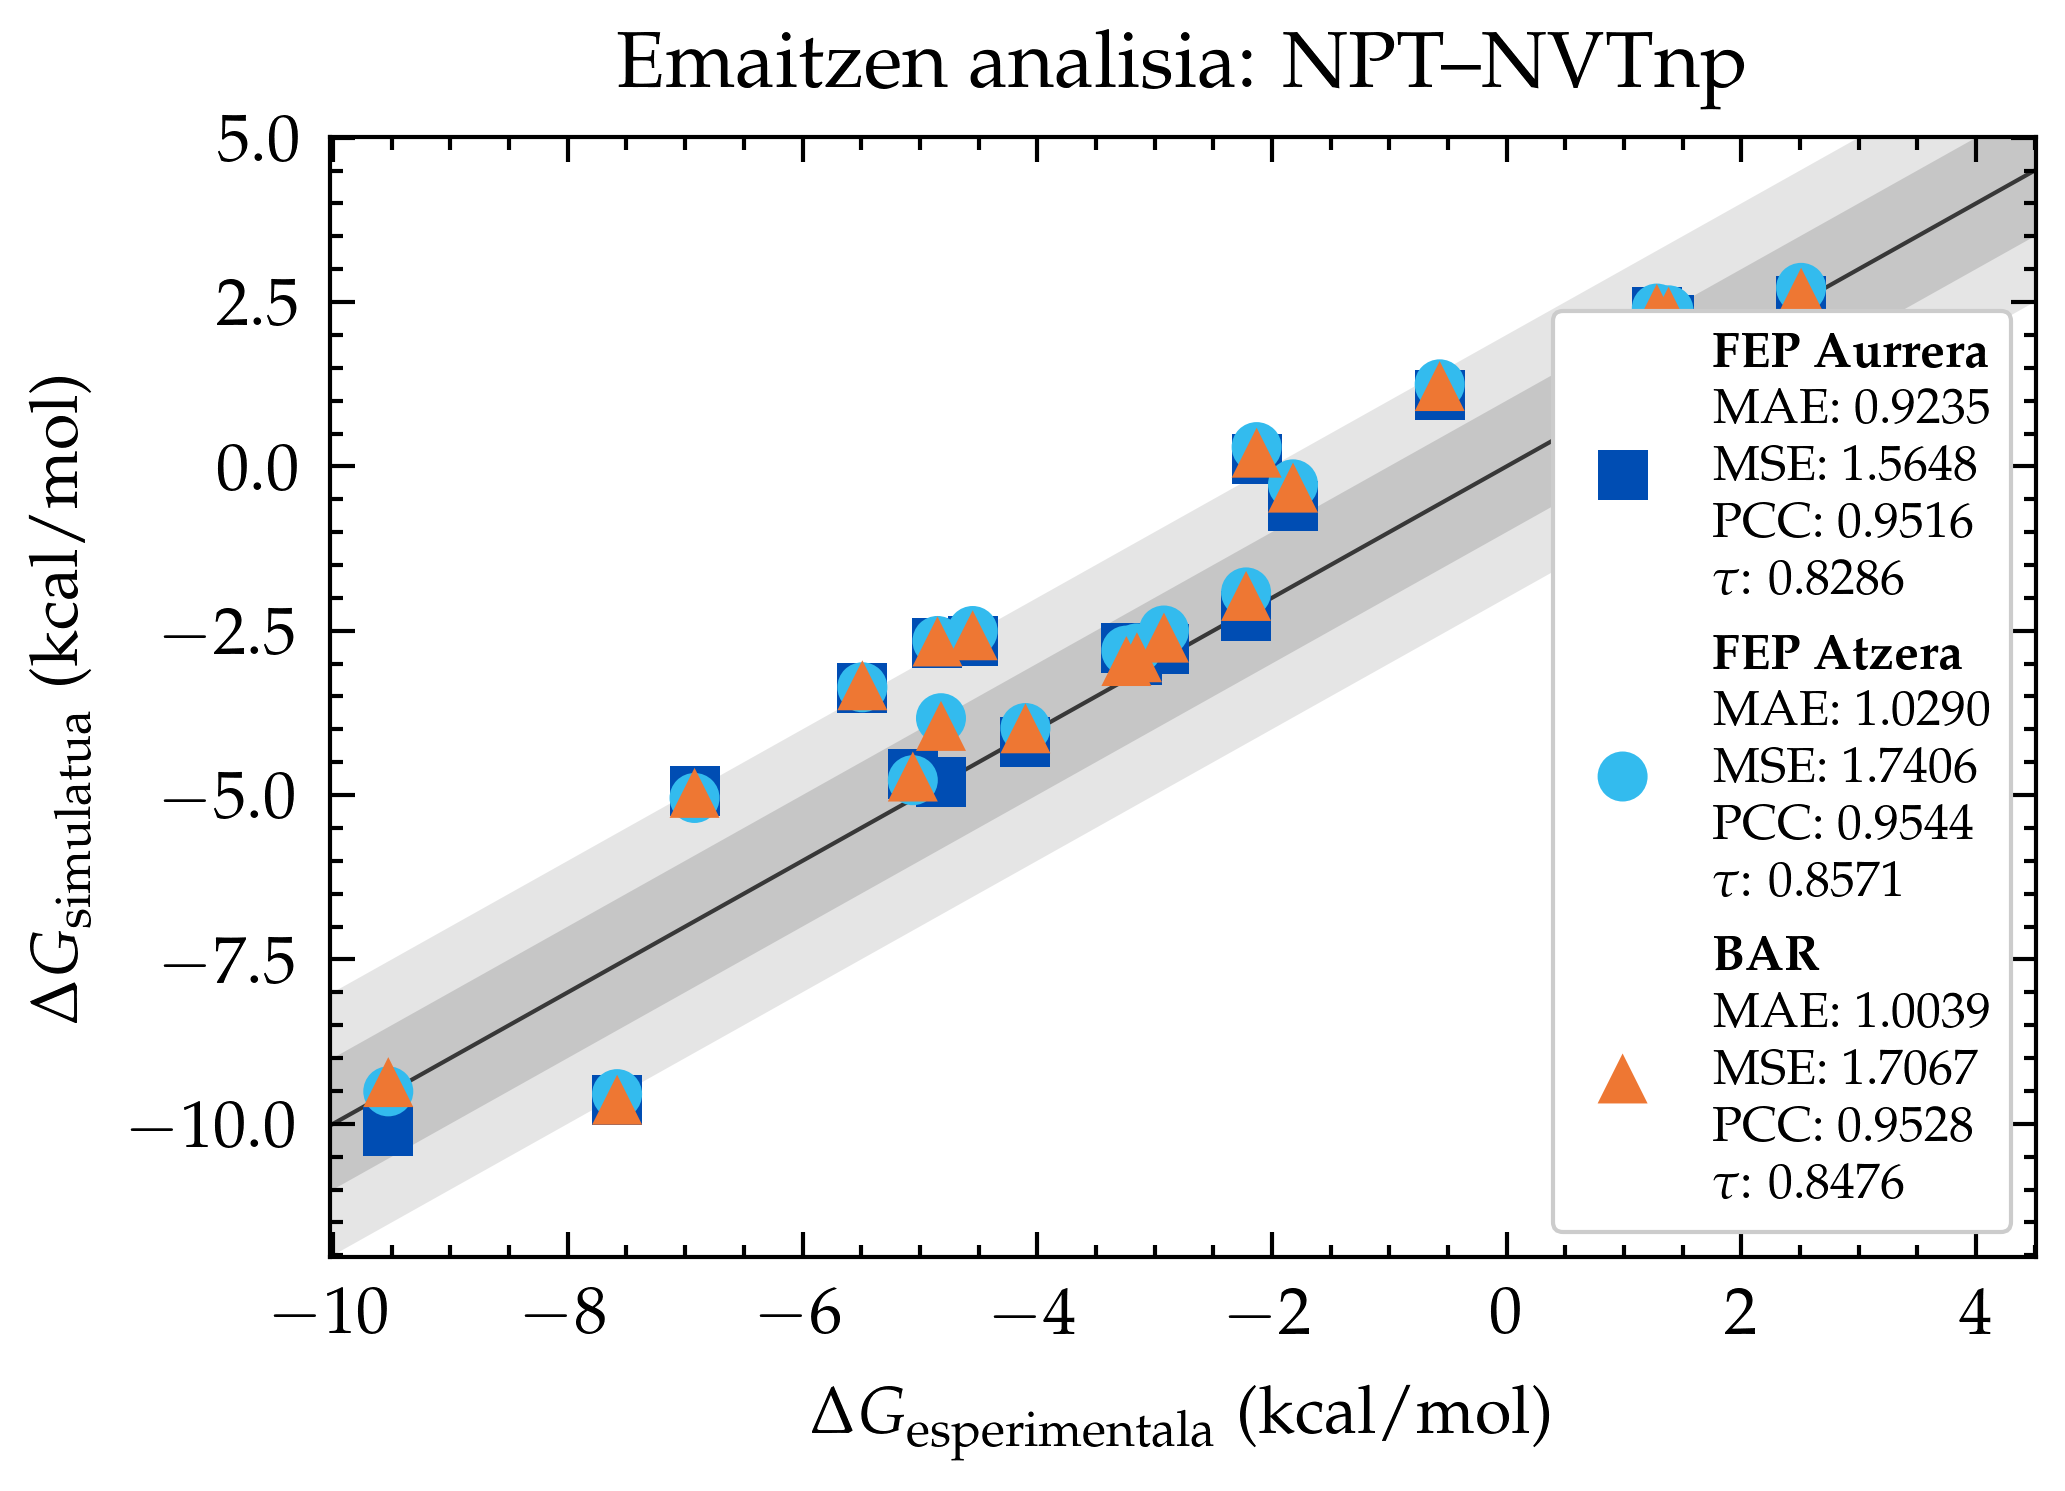

In [30]:
molecule_names = list(erraza_df.name)
for (comb_key, _, __) in combinations[1:]:
    plot_combination(data_dict_erraza['forward'], metrics_dict_erraza['forward'], comb_key).savefig(OUTPUT_PATH+'errazak/'+f"Metrikak_errazak_forward.pdf", dpi=500)
    plot_combination(data_dict_erraza['backward'], metrics_dict_erraza['backward'], comb_key).savefig(OUTPUT_PATH+'errazak/'+f"Metrikak_errazak_backward.pdf", dpi=500)
    plot_combination(data_dict_erraza['BAR'], metrics_dict_erraza['BAR'], comb_key).savefig(OUTPUT_PATH+'errazak/'+f"Metrikak_errazak_BAR.pdf", dpi=500)

plot_combination_fbbar(data_dict_erraza, metrics_dict_erraza, combinations[0][0]).savefig(OUTPUT_PATH+'errazak/'+f"Metrikak_errazak_denak_NVT_NVTnp.pdf", dpi=500)
plot_combination_fbbar(data_dict_erraza, metrics_dict_erraza, combinations[1][0]).savefig(OUTPUT_PATH+'errazak/'+f"Metrikak_errazak_denak_NPT_NVTnp.pdf", dpi=500)

### Molekula zailak

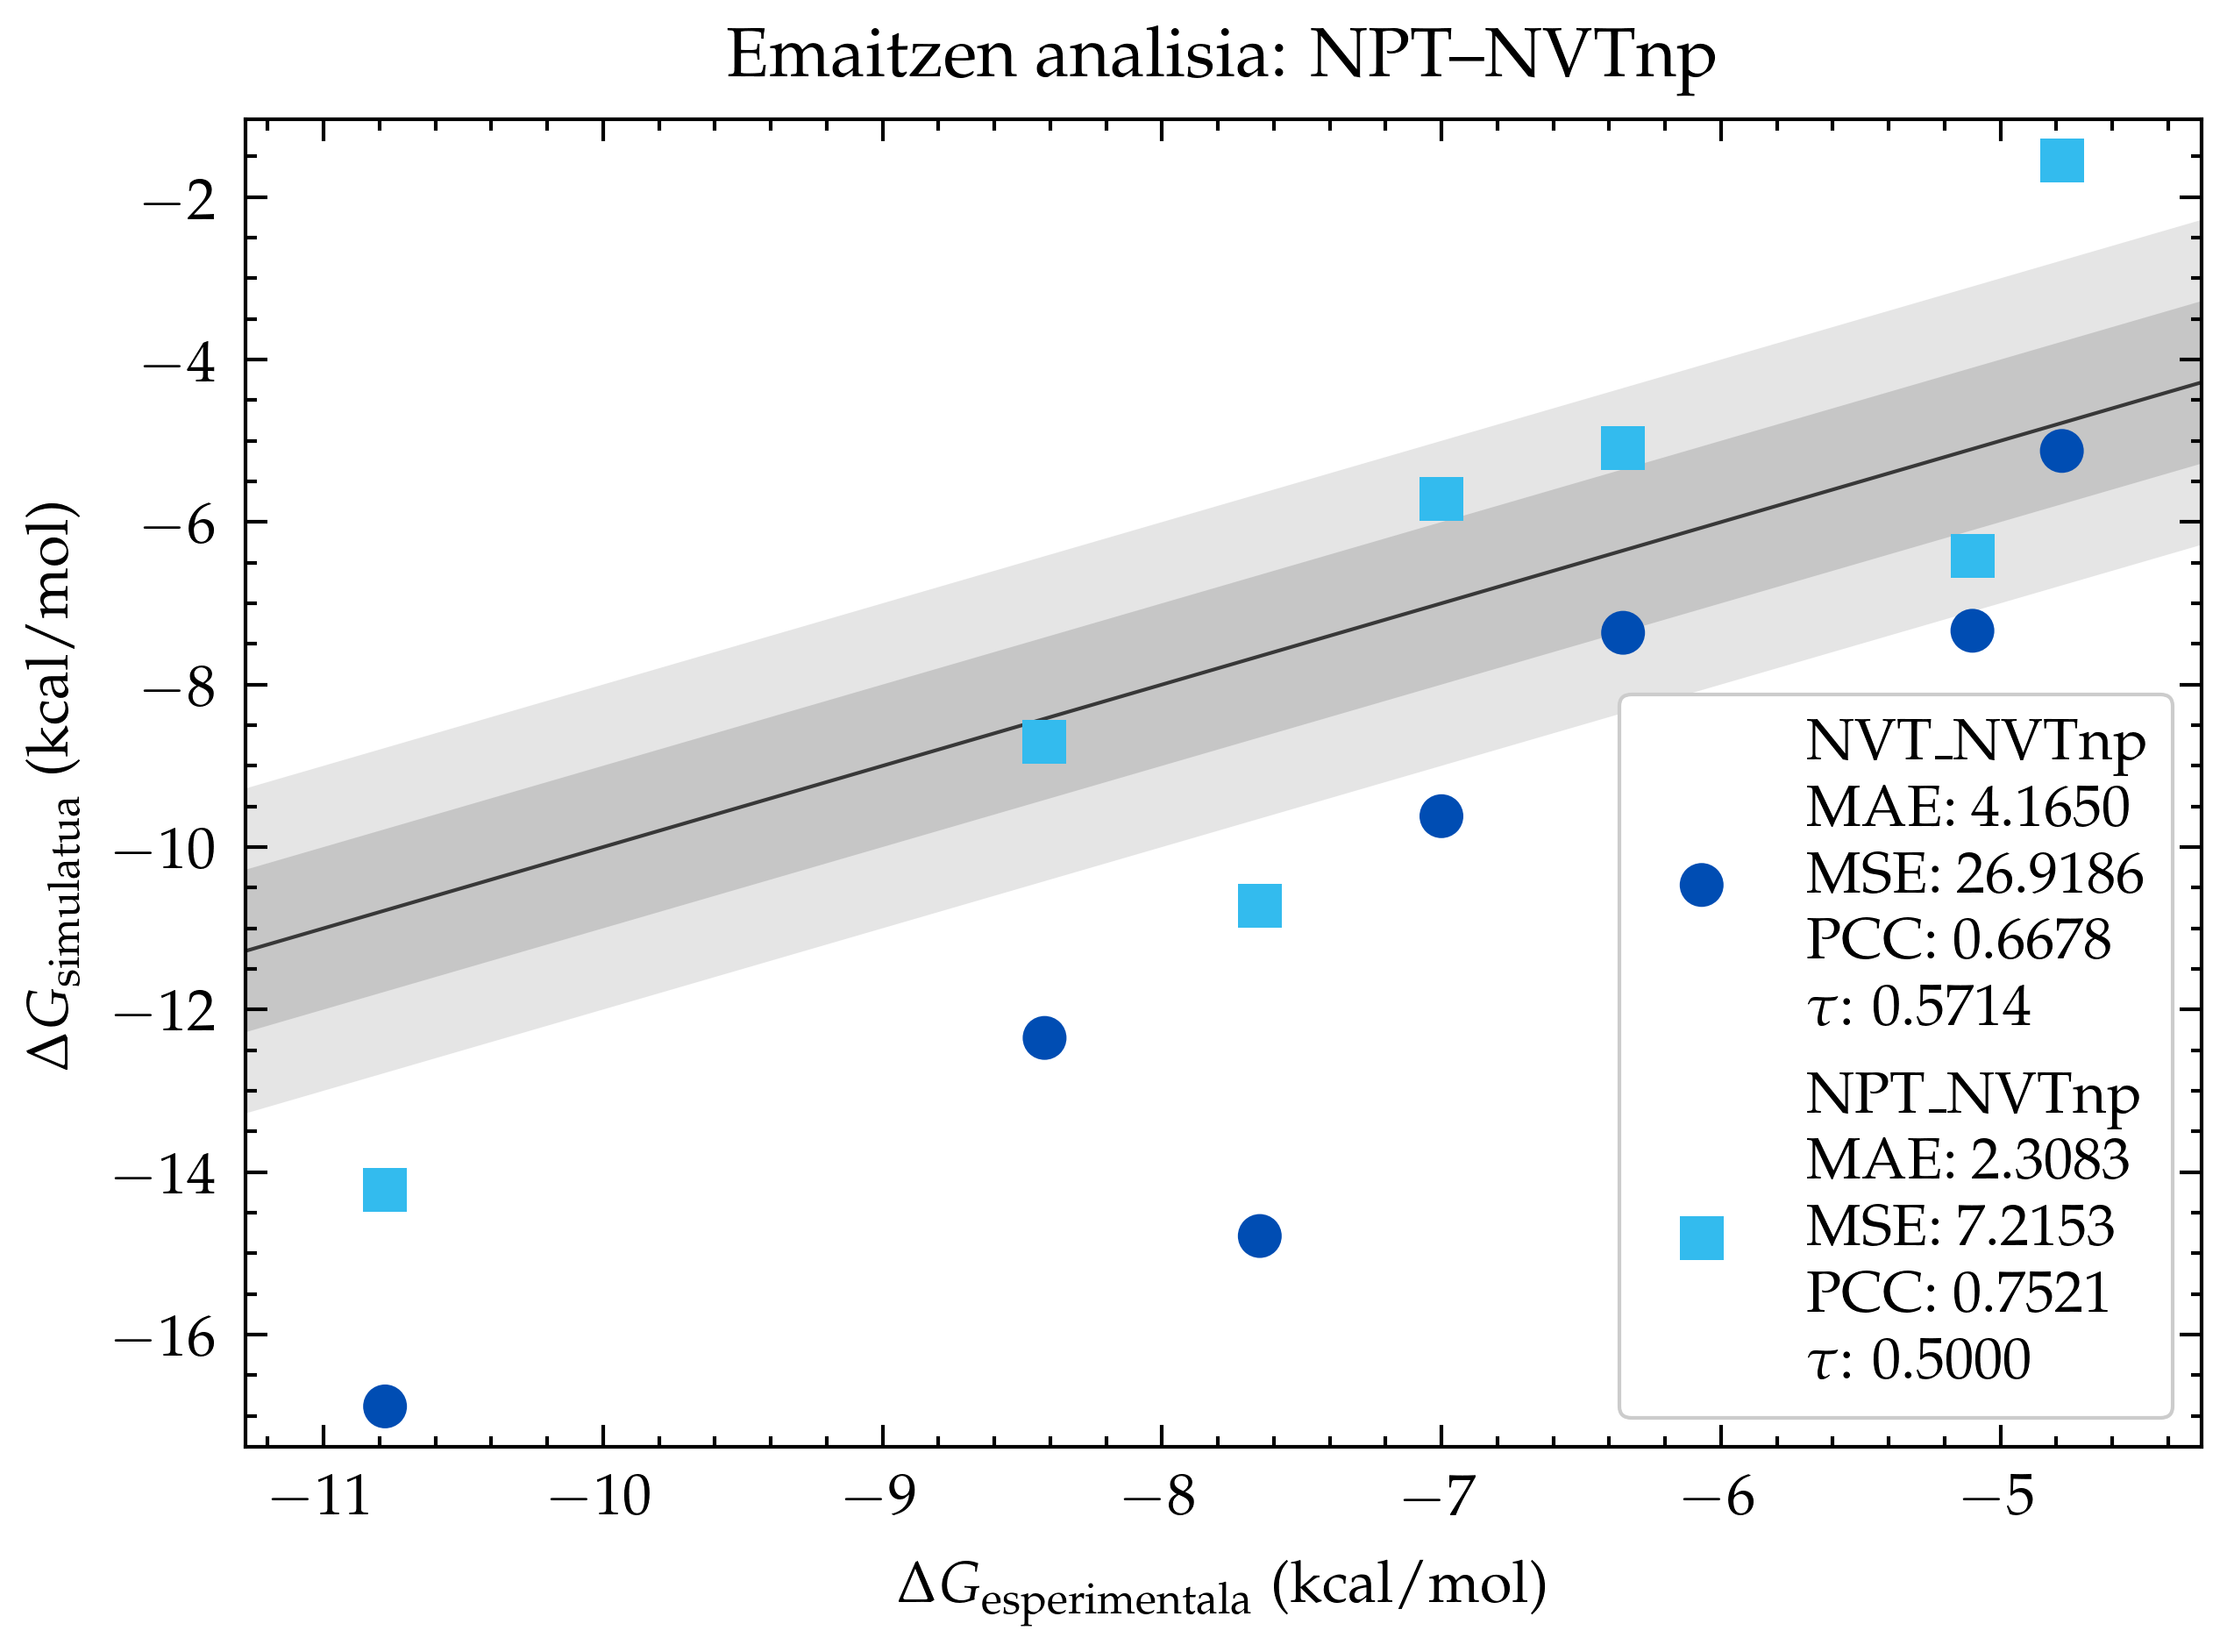

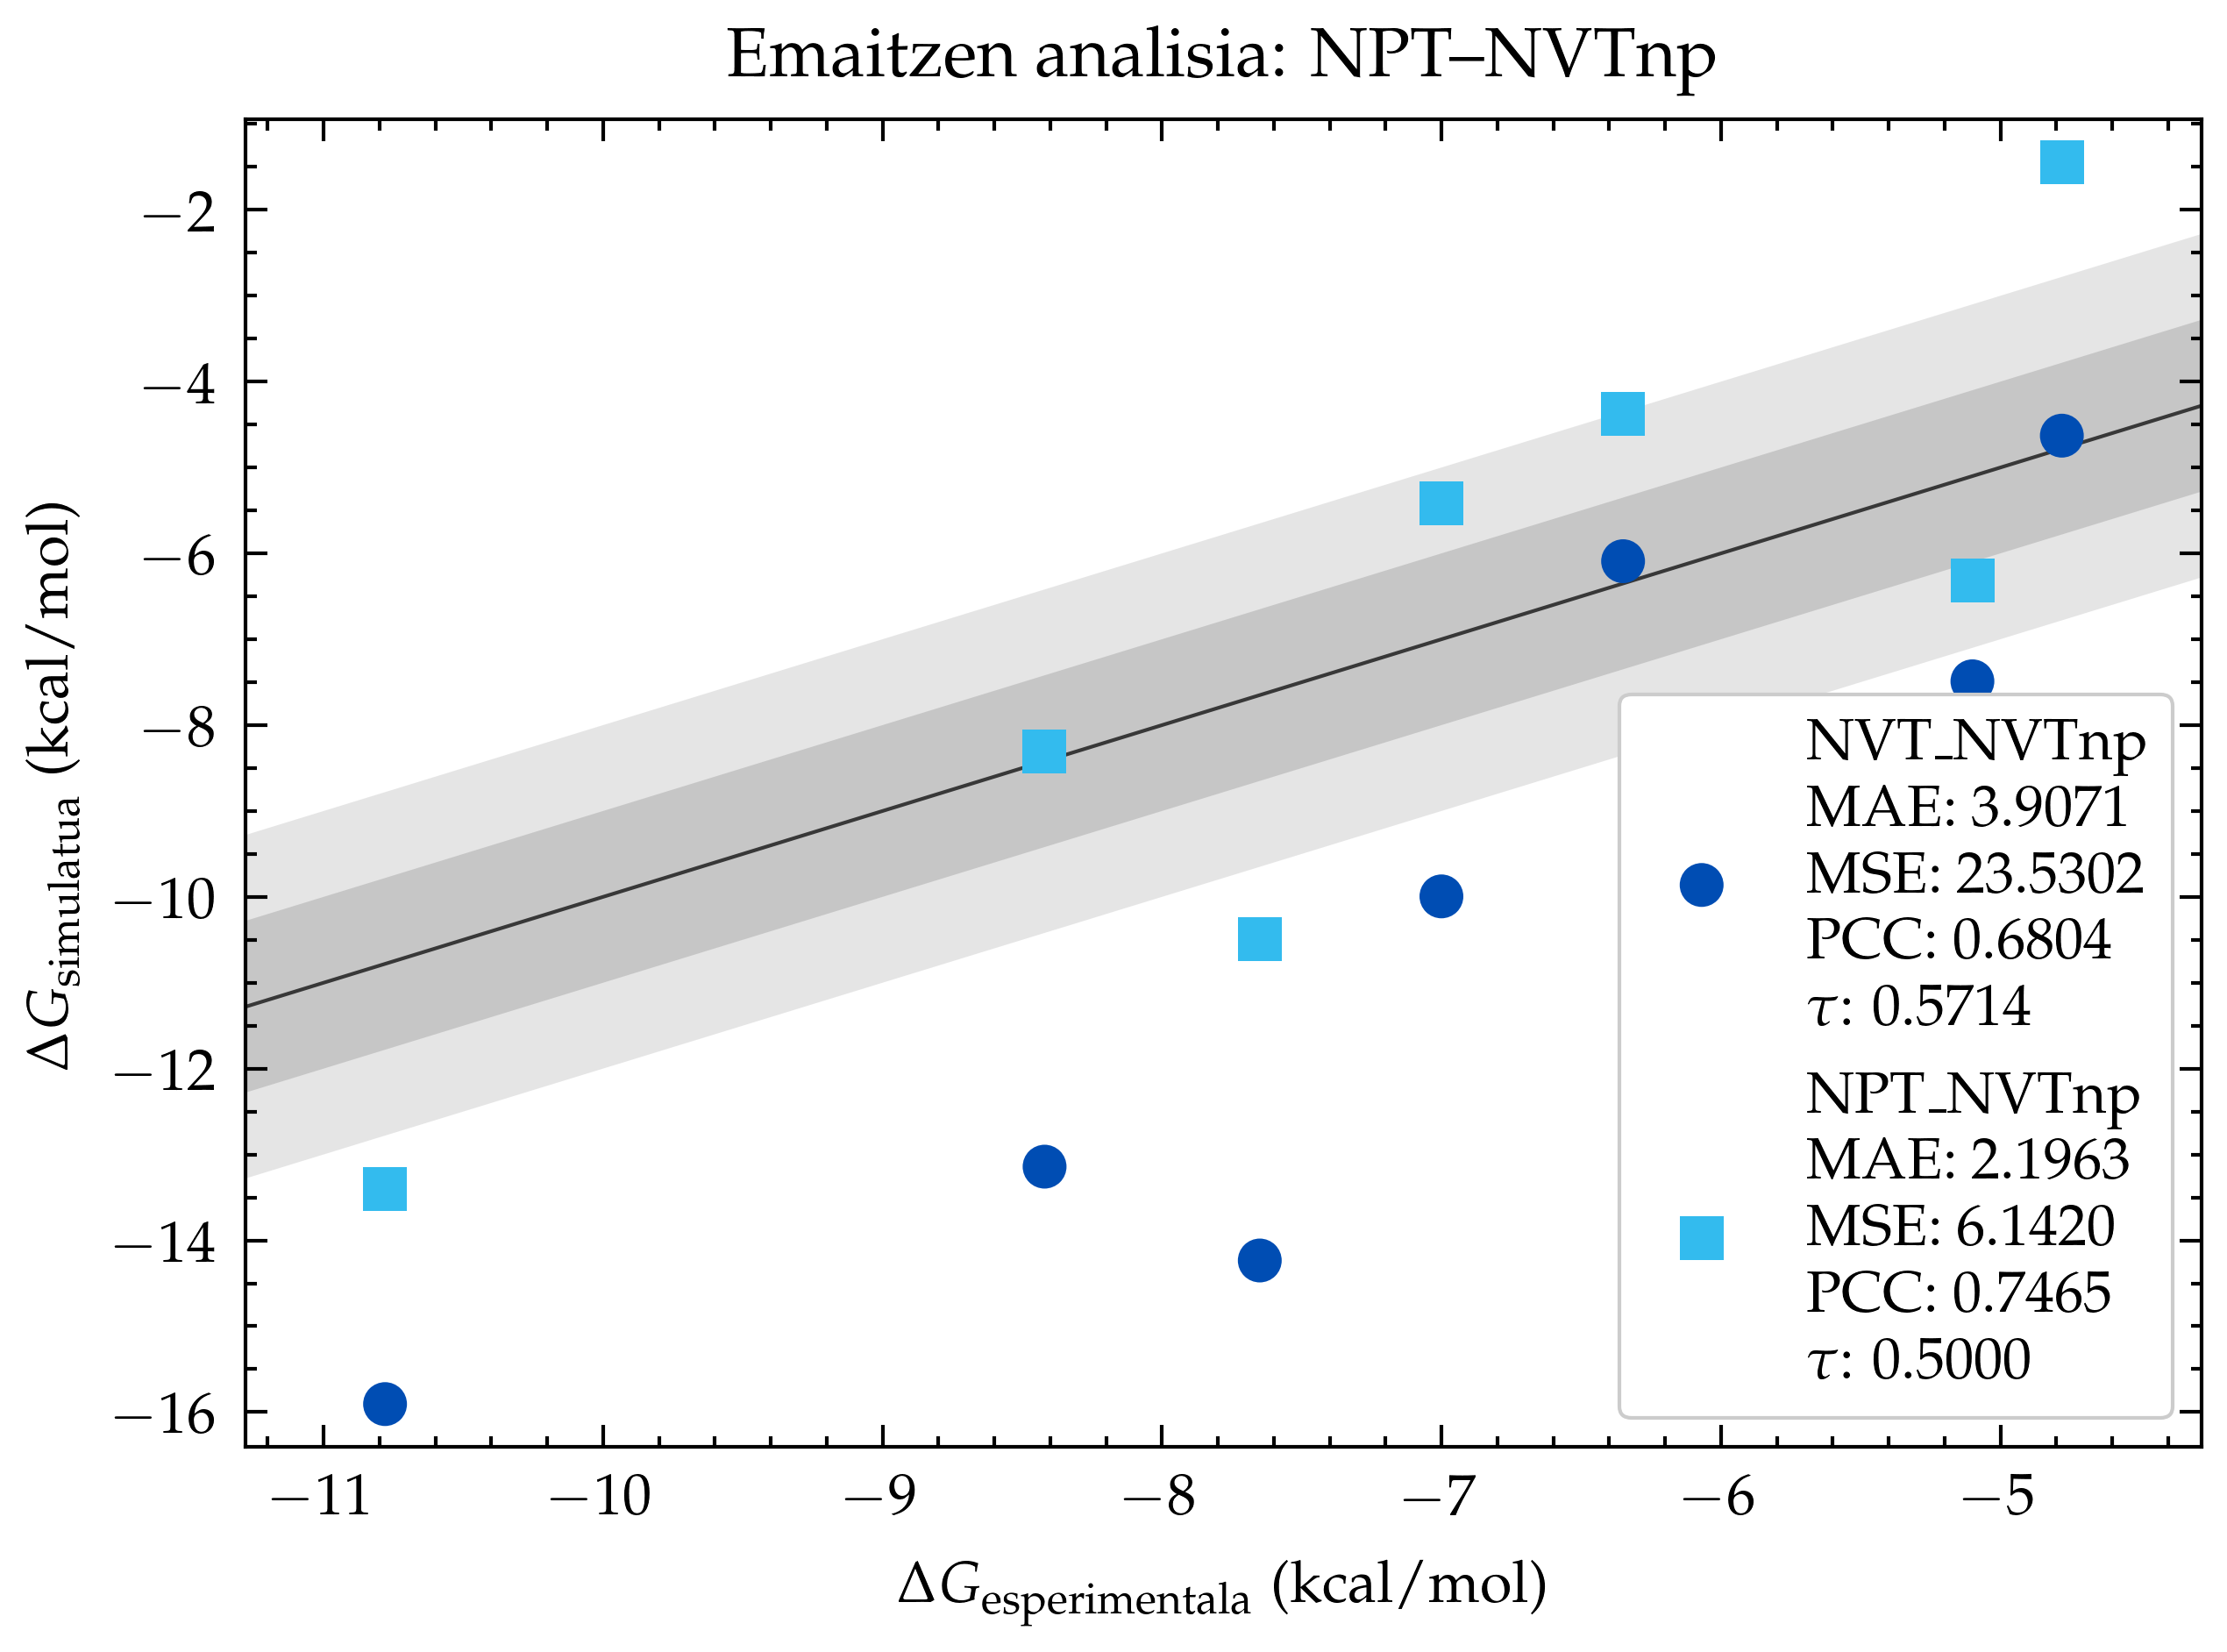

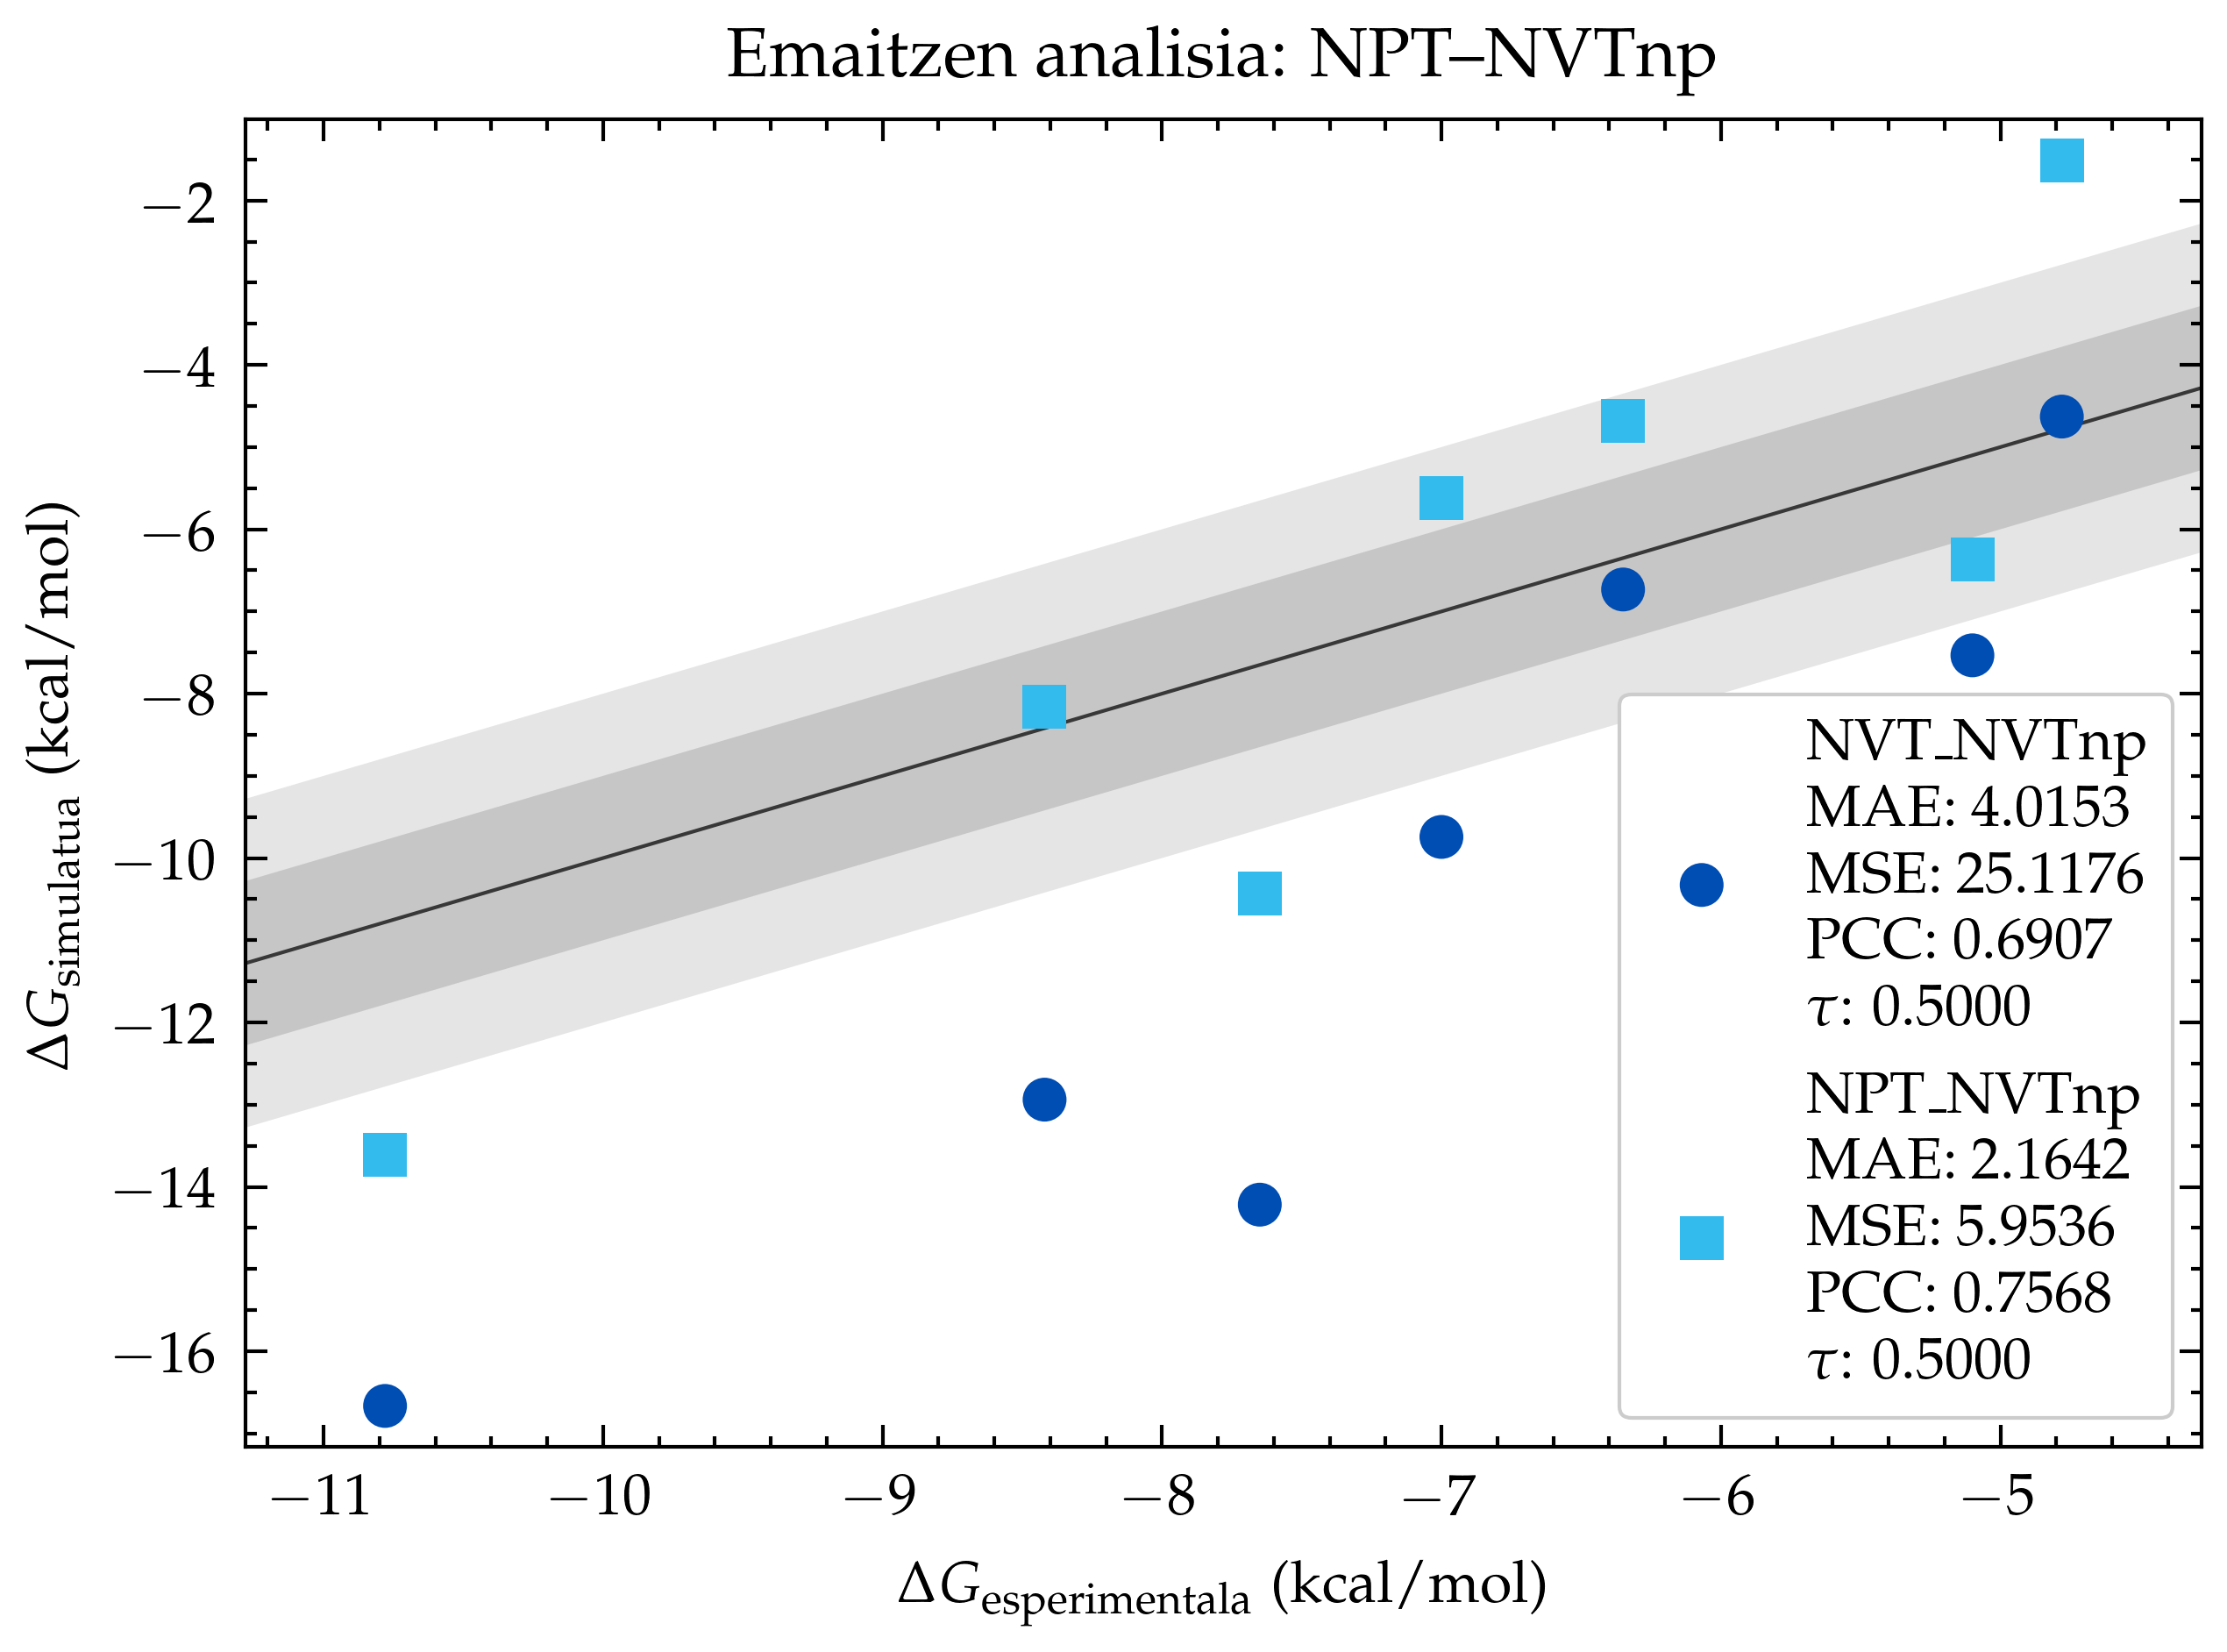

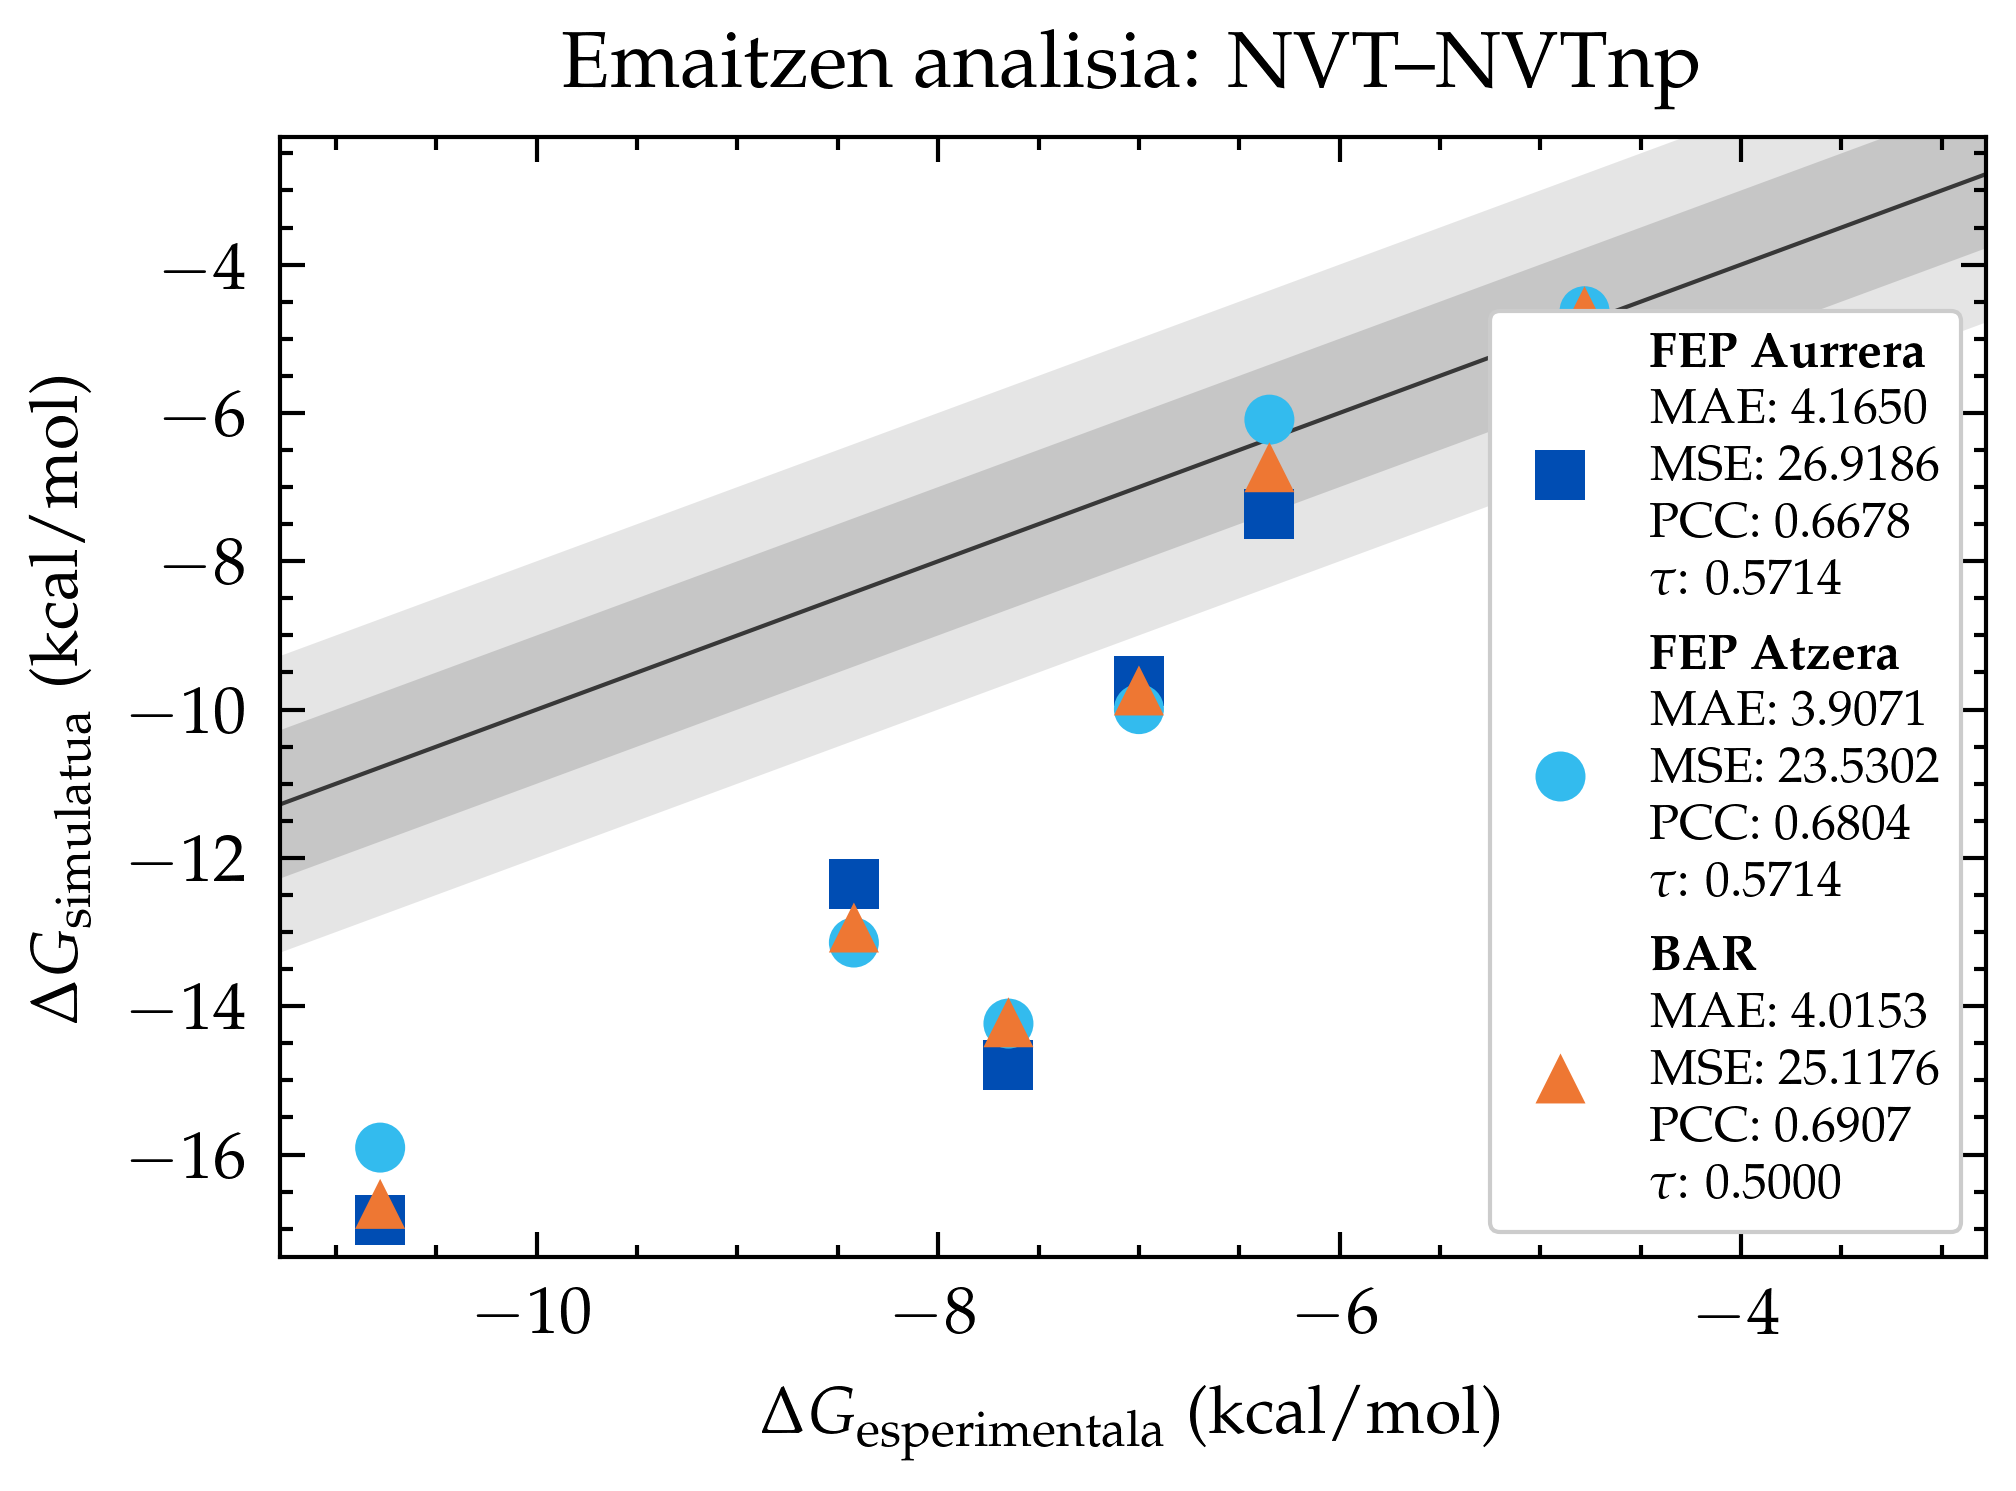

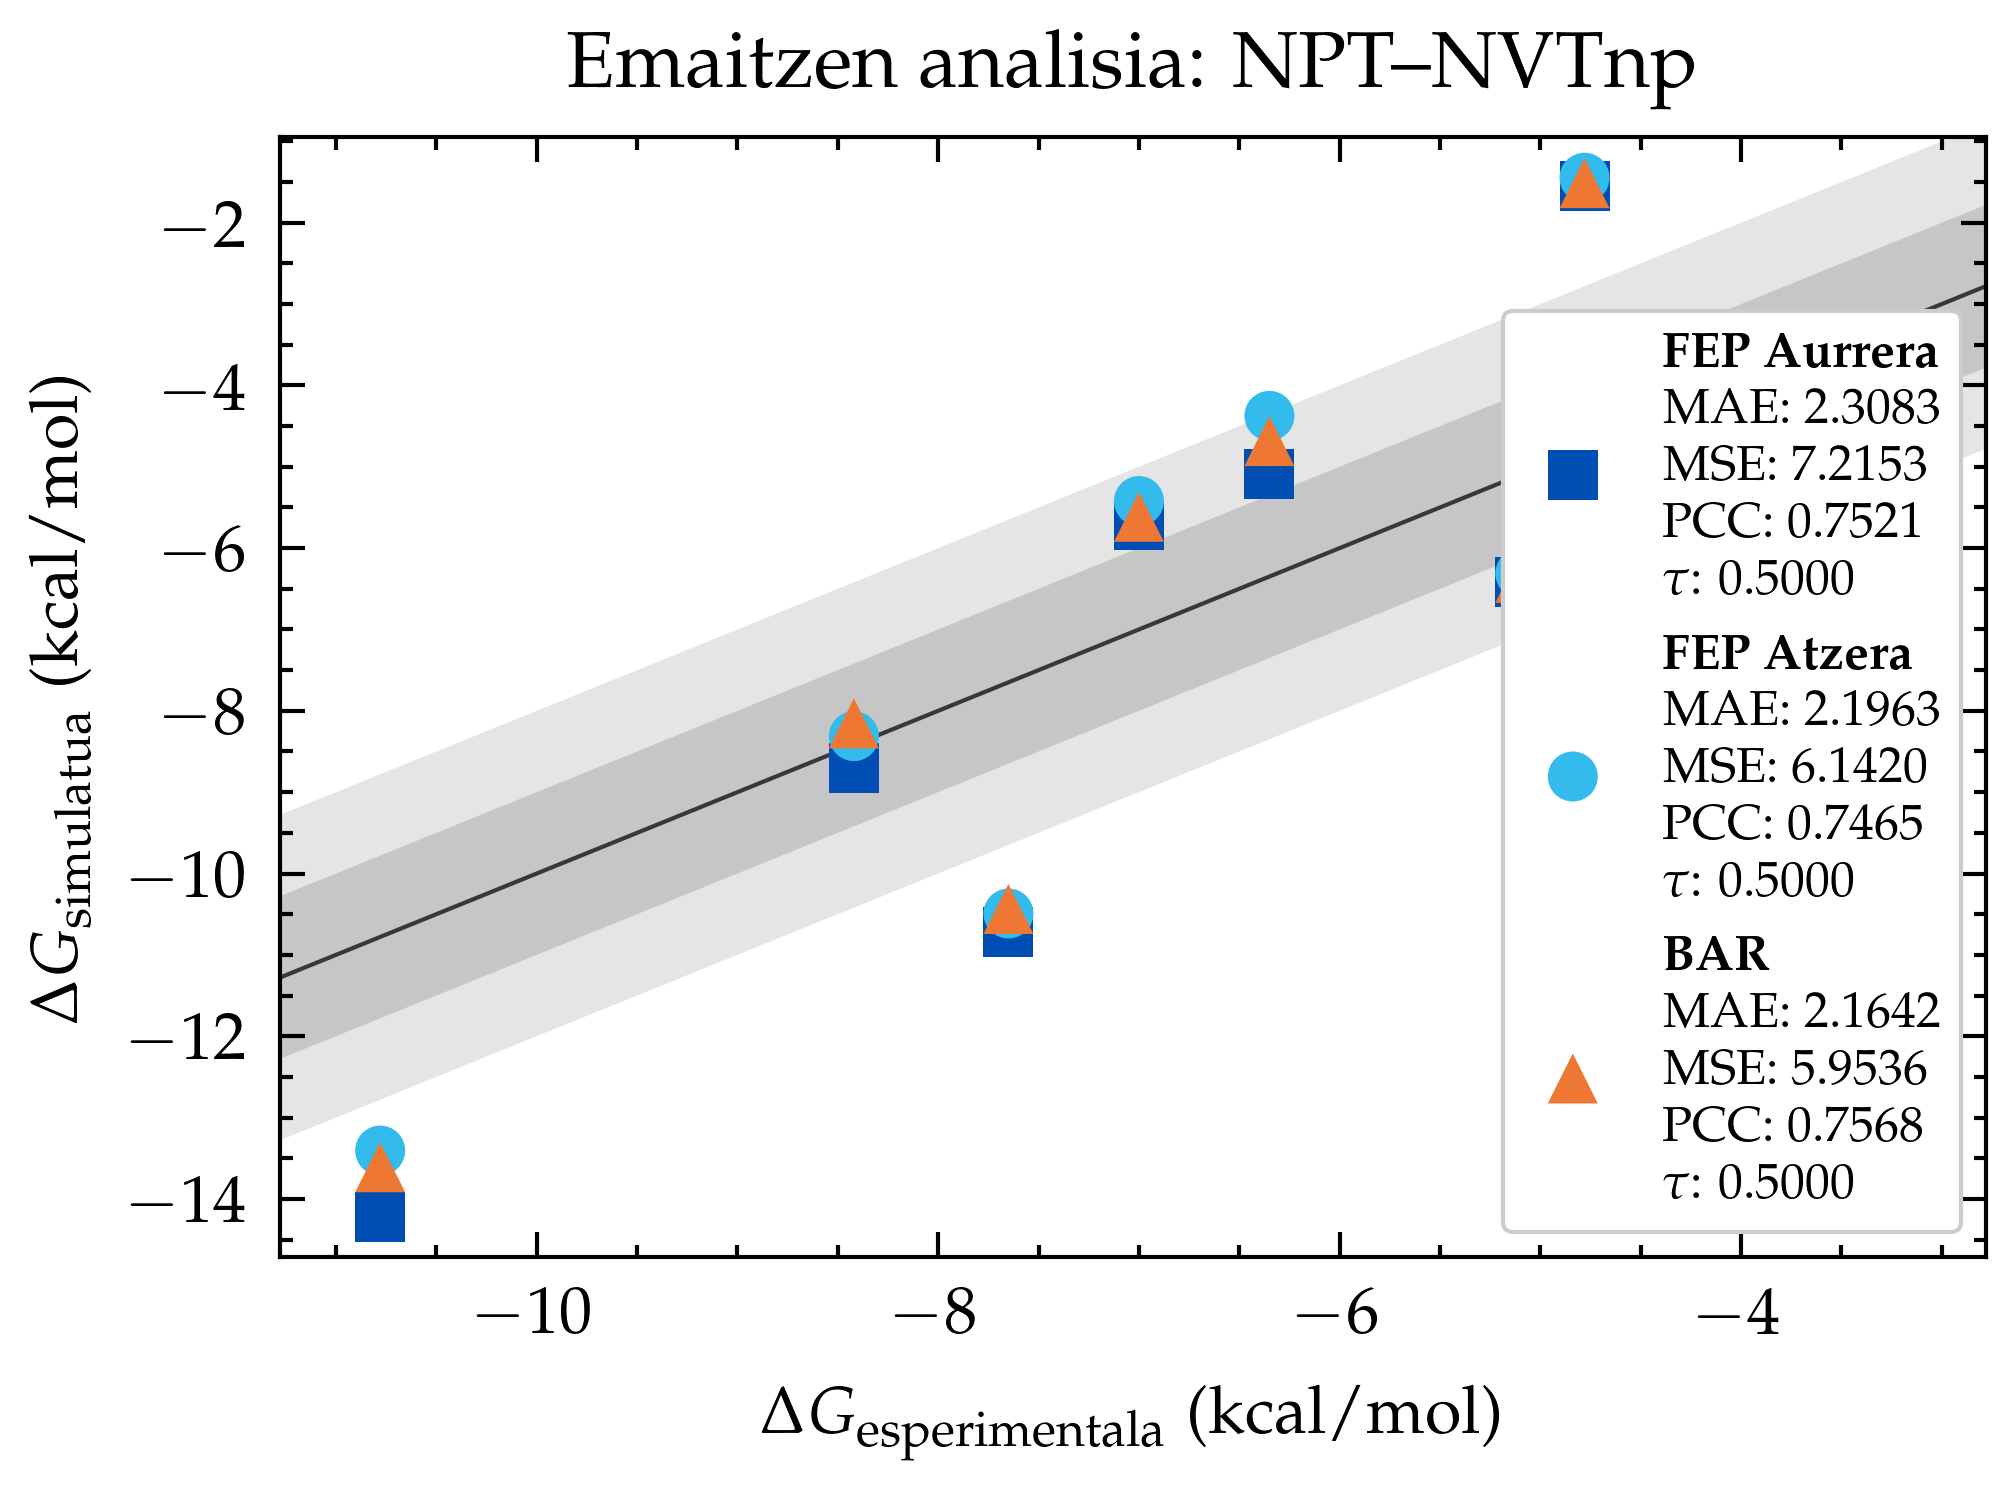

In [31]:
molecule_names = list(zaila_df.name)
for (comb_key, _, __) in combinations[1:]:
    plot_combination(data_dict_zaila['forward'], metrics_dict_zaila['forward'], comb_key).savefig(OUTPUT_PATH+'zailak/'+f"Metrikak_zailak_forward.pdf", dpi=500)
    plot_combination(data_dict_zaila['backward'], metrics_dict_zaila['backward'], comb_key).savefig(OUTPUT_PATH+'zailak/'+f"Metrikak_zailak_backward.pdf", dpi=500)
    plot_combination(data_dict_zaila['BAR'], metrics_dict_zaila['BAR'], comb_key).savefig(OUTPUT_PATH+'zailak/'+f"Metrikak_zailak_BAR.pdf", dpi=500)

plot_combination_fbbar(data_dict_zaila, metrics_dict_zaila, combinations[0][0]).savefig(OUTPUT_PATH+'zailak/'+f"Metrikak_zailak_denak_NVT_NVTnp.pdf", dpi=500)
plot_combination_fbbar(data_dict_zaila, metrics_dict_zaila, combinations[1][0]).savefig(OUTPUT_PATH+'zailak/'+f"Metrikak_zailak_denak_NPT_NVTnp.pdf", dpi=500)

## Zailak eta errazak, denak batera

In [21]:
import copy

data_dict_full = copy.deepcopy(data_dict_zaila)
data_dict_full

for method in data_dict_full:
    data_dict_full[method].update(data_dict_erraza[method])

metrics_dict_full = dict()

# Datu egitura hutsa sortu, eta balio esperimentalak sartu.
# Create the dictionary to store all the data.
# Estimators: forward, backward, BAR
metrics_dict_full['forward'] = dict()
metrics_dict_full['backward'] = dict()
metrics_dict_full['BAR'] = dict()

merged_df = pd.concat([erraza_df, zaila_df], ignore_index=True)
molecule_names = list(merged_df.name)
for (comb_key, _, __) in combinations:
    metrics_dict_full['forward'][comb_key] = {'MAE' : calc_MAE(data_dict_full['forward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict_full['forward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict_full['forward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict_full['forward'], comb_key, molecule_names)}
    metrics_dict_full['backward'][comb_key] = {'MAE' : calc_MAE(data_dict_full['backward'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict_full['backward'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict_full['backward'], comb_key, molecule_names), 'tau' : calc_tau(data_dict_full['backward'], comb_key, molecule_names)}
    metrics_dict_full['BAR'][comb_key] = {'MAE' : calc_MAE(data_dict_full['BAR'], comb_key, molecule_names), 'MSE' : calc_MSE(data_dict_full['BAR'], comb_key, molecule_names), 'PCC' : calc_PCC(data_dict_full['BAR'], comb_key, molecule_names), 'tau' : calc_tau(data_dict_full['BAR'], comb_key, molecule_names)}


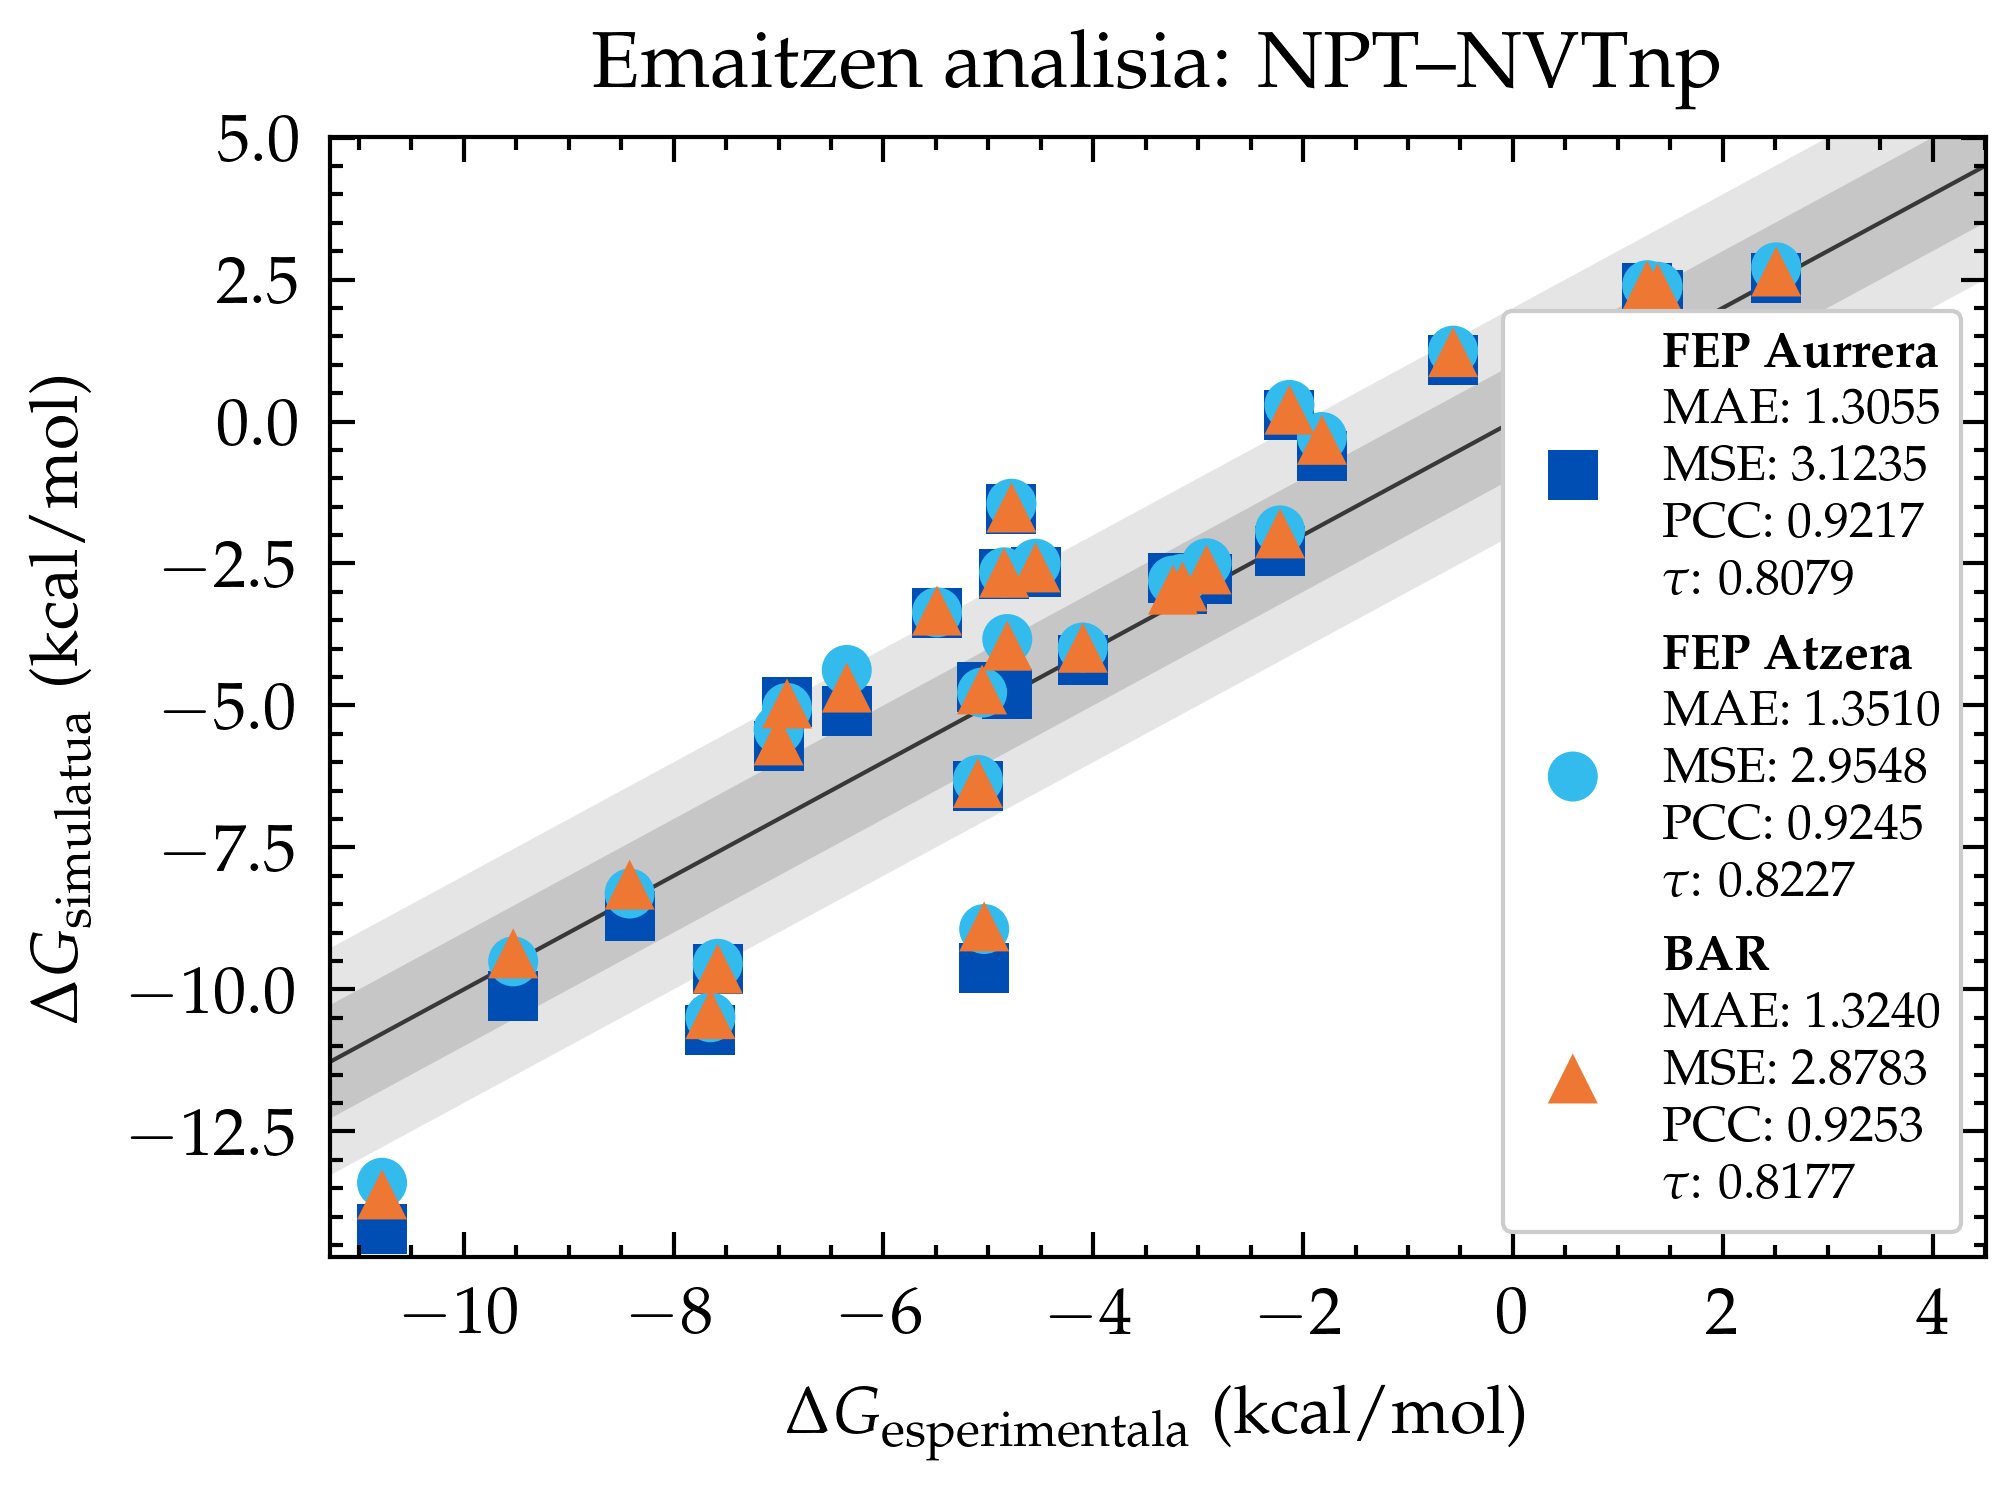

In [33]:
plot_combination_fbbar(data_dict_full, metrics_dict_full, combinations[1][0]).savefig(OUTPUT_PATH+f"Metrikak_den_denak_NPT_NVTnp.pdf")

## Molekula errazak eta zailak, batera

Grafiko berean irurdikatuta, kolore/ikur ezberdinak erabilita. 

In [13]:
dict_boostrap_erraza = dict()
for molecule_name in erraza_df.name:
    dict_boostrap_erraza[molecule_name] = free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', molecule_name)

Maximum number of iterations has been reached


In [14]:
free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', 'endrin')

{'forward': {'mean': -4.822015719323792, 'std': 0.19750694025028503},
 'backward': {'mean': -3.821436326238869, 'std': 0.18859878119541465},
 'BAR': {'mean': -3.9517931250277907, 'std': 0.055226001888447195}}

In [35]:
free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', 'endrin')

{'forward': {'mean': -4.806473758801143, 'std': 0.22958568420216285},
 'backward': {'mean': -3.825087959552464, 'std': 0.1839318447988885},
 'BAR': {'mean': -3.938551810745884, 'std': 0.053508205395082185}}

In [24]:
for molecule in dict_boostrap_erraza.keys():
    for method in ['forward', 'backward', 'BAR']:
        for key, value in dict_boostrap_erraza[molecule][method].items():
            dict_boostrap_erraza[molecule][method][key] = round(value, 3)


pd.DataFrame(dict_boostrap_erraza)

neopentane                dibenzo-p-dioxin  \
forward    {'mean': 2.499, 'std': 0.12}  {'mean': -2.992, 'std': 0.184}   
backward  {'mean': 2.717, 'std': 0.045}  {'mean': -2.749, 'std': 0.139}   
BAR       {'mean': 2.642, 'std': 0.034}  {'mean': -2.902, 'std': 0.051}   

                            cyclohexane                   ethoxybenzene  \
forward   {'mean': 1.367, 'std': 0.113}  {'mean': -2.292, 'std': 0.109}   
backward  {'mean': 1.522, 'std': 0.047}  {'mean': -1.921, 'std': 0.076}   
BAR       {'mean': 1.529, 'std': 0.036}  {'mean': -1.966, 'std': 0.046}   

                             propan-1-ol          1,4-dimethylpiperazine  \
forward   {'mean': -2.679, 'std': 0.078}  {'mean': -9.691, 'std': 0.179}   
backward  {'mean': -2.655, 'std': 0.043}   {'mean': -9.556, 'std': 0.08}   
BAR       {'mean': -2.664, 'std': 0.036}  {'mean': -9.636, 'std': 0.048}   

          methyl_cyclopropanecarboxylate                       ethylene  \
forward   {'mean': -4.198, 'std': 0.088}  {'mean': 2.351, 'std': 0.041}   
backward   {'mean': -3.97, 'std': 0.054}  {'mean': 2.397, 'std': 0.022}   
BAR       {'mean': -3.984, 'std': 0.038}  {'mean': 2.393, 'std': 0.022}   

                             methanamine             3-chloroprop-1-ene  ...  \
forward   {'mean': -2.652, 'std': 0.046}  {'mean': 1.077, 'std': 0.073}  ...   
backward  {'mean': -2.508, 'std': 0.035}  {'mean': 1.252, 'std': 0.034}  ...   
BAR        {'mean': -2.57, 'std': 0.026}  {'mean': 1.222, 'std': 0.028}  ...   

                                  endrin                     1,4-dioxane  \
forward   {'mean': -4.846, 'std': 0.189}  {'mean': -4.966, 'std': 0.092}   
backward  {'mean': -3.836, 'std': 0.168}  {'mean': -4.981, 'std': 0.052}   
BAR       {'mean': -3.956, 'std': 0.054}  {'mean': -4.962, 'std': 0.041}   

               [(2S)-butan-2-yl]-nitrate                      but-1-ene  \
forward   {'mean': -0.622, 'std': 0.099}  {'mean': 2.221, 'std': 0.059}   
backward   {'mean': -0.27, 'std': 0.055}  {'mean': 2.372, 'std': 0.033}   
BAR       {'mean': -0.322, 'std': 0.036}   {'mean': 2.35, 'std': 0.026}   

                           cyclopentanol             3-methylbutan-2-one  \
forward   {'mean': -3.381, 'std': 0.116}  {'mean': -2.796, 'std': 0.172}   
backward  {'mean': -3.358, 'std': 0.054}  {'mean': -2.799, 'std': 0.055}   
BAR        {'mean': -3.331, 'std': 0.04}  {'mean': -2.962, 'std': 0.043}   

                            heptan-4-one             3-phenylpropan-1-ol  \
forward   {'mean': -2.803, 'std': 0.157}  {'mean': -4.992, 'std': 0.208}   
backward  {'mean': -2.502, 'std': 0.103}   {'mean': -5.03, 'std': 0.091}   
BAR       {'mean': -2.606, 'std': 0.044}   {'mean': -4.97, 'std': 0.052}   

               2-bromo-2-methyl-propane 1-amino-4-hydroxy-9,10-anthracenedione  
forward   {'mean': 0.852, 'std': 0.123}        {'mean': -10.158, 'std': 0.196}  
backward  {'mean': 0.881, 'std': 0.049}         {'mean': -9.479, 'std': 0.203}  
BAR       {'mean': 0.864, 'std': 0.039}          {'mean': -9.359, 'std': 0.07}  

[3 rows x 21 columns]

In [15]:
dict_boostrap_zaila = dict()
for molecule_name in zaila_df.name:
    dict_boostrap_zaila[molecule_name] = free_energy_std('outputs/outputs_NPT/', 'outputs/outputs_NVT/', molecule_name)

In [16]:
for molecule in dict_boostrap_zaila.keys():
    for method in ['forward', 'backward', 'BAR']:
        for key, value in dict_boostrap_zaila[molecule][method].items():
            dict_boostrap_zaila[molecule][method][key] = round(value, 3)


pd.DataFrame(dict_boostrap_zaila)

flurbiprofen                       ibuprofen  \
forward   {'mean': -8.735, 'std': 0.181}   {'mean': -5.744, 'std': 0.36}   
backward  {'mean': -8.196, 'std': 0.306}  {'mean': -5.381, 'std': 0.143}   
BAR       {'mean': -8.149, 'std': 0.061}  {'mean': -5.607, 'std': 0.069}   

                               ketoprofen  \
forward   {'mean': -14.251, 'std': 0.173}   
backward  {'mean': -13.297, 'std': 0.396}   
BAR       {'mean': -13.615, 'std': 0.075}   

         2-N-ethyl-6-(methylsulfanyl)-4-N-(propan-2-yl)-1,3,5-triazine-2,4-diamine  \
forward                     {'mean': -10.721, 'std': 0.225}                          
backward                    {'mean': -10.471, 'std': 0.187}                          
BAR                         {'mean': -10.433, 'std': 0.081}                          

                        dimethyl_sulfate                    chlorpyrifos  \
forward   {'mean': -6.427, 'std': 0.096}  {'mean': -9.671, 'std': 0.257}   
backward  {'mean': -6.312, 'std': 0.064}  {'mean': -8.844, 'std': 0.297}   
BAR        {'mean': -6.374, 'std': 0.04}  {'mean': -8.896, 'std': 0.074}   

                            butyric_acid (2Z)-3,7-dimethylocta-2,6-dien-1-ol  
forward   {'mean': -5.139, 'std': 0.132}       {'mean': -1.56, 'std': 0.163}  
backward  {'mean': -4.366, 'std': 0.086}      {'mean': -1.445, 'std': 0.107}  
BAR        {'mean': -4.688, 'std': 0.06}      {'mean': -1.516, 'std': 0.049}

In [16]:
def plot_errazak_zailak(metodoa, data_dict_erraza, data_dict_zaila, izenb=''):
    comb_key = 'D_NPT_NVTnp'
    fig, ax = plt.subplots(figsize=(3.5, 2.625))
    
    X_erraza = []      # X -> balio esperimentalak
    X_zaila = []      # X -> balio esperimentalak
    Y_erraza = []    # Y -> kalkulatutako balioak, errazak
    Y_zaila = []      # Y -> kalkulatutako balioak, zailak
    std_erraza = []
    std_zaila = []

    for molecule_name in erraza_df.name:
        X_erraza.append(data_dict_erraza[metodoa][molecule_name]['0_experimental_value'])
        Y_erraza.append(data_dict_erraza[metodoa][molecule_name][comb_key])
        std_erraza.append(dict_boostrap_erraza[molecule_name][metodoa]['std'])

    for molecule_name in zaila_df.name:
        X_zaila.append(data_dict_zaila[metodoa][molecule_name]['0_experimental_value'])
        Y_zaila.append(data_dict_zaila[metodoa][molecule_name][comb_key])
        std_zaila.append(dict_boostrap_zaila[molecule_name][metodoa]['std'])

    X = X_erraza + X_zaila
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = set(Y_erraza+Y_zaila+list(X_range))
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen analisia: {comb_key[2:].replace('_','--')} {izenb}")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)
        

    legend_erraza = r"\textbf{Errazak}"+f"\nMAE: {metrics_dict_erraza[metodoa][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict_erraza[metodoa][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict_erraza[metodoa][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict_erraza[metodoa][comb_key]['tau']:>8.4f}"
    legend_zaila = r"\textbf{Zailak}"+f"\nMAE: {metrics_dict_zaila[metodoa][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict_zaila[metodoa][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict_zaila[metodoa][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict_zaila[metodoa][comb_key]['tau']:>8.4f}"

    ax.scatter(X_erraza, Y_erraza, label=legend_erraza, marker='o', color='C0', zorder=1, edgecolor='none')
    ax.scatter(X_zaila, Y_zaila, label=legend_zaila, marker='s', color='C1', zorder=1, edgecolor='none') 

    ax.errorbar(X_erraza, Y_erraza, yerr=[10*i for i in std_erraza], fmt='none', color='C0', zorder=1, capsize=1)
    ax.errorbar(X_zaila, Y_zaila, yerr=[10*i for i in std_zaila], fmt='none', color='C1', zorder=1, capsize=1)

    legend = ax.legend(frameon=True, loc=4, fontsize=6)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig

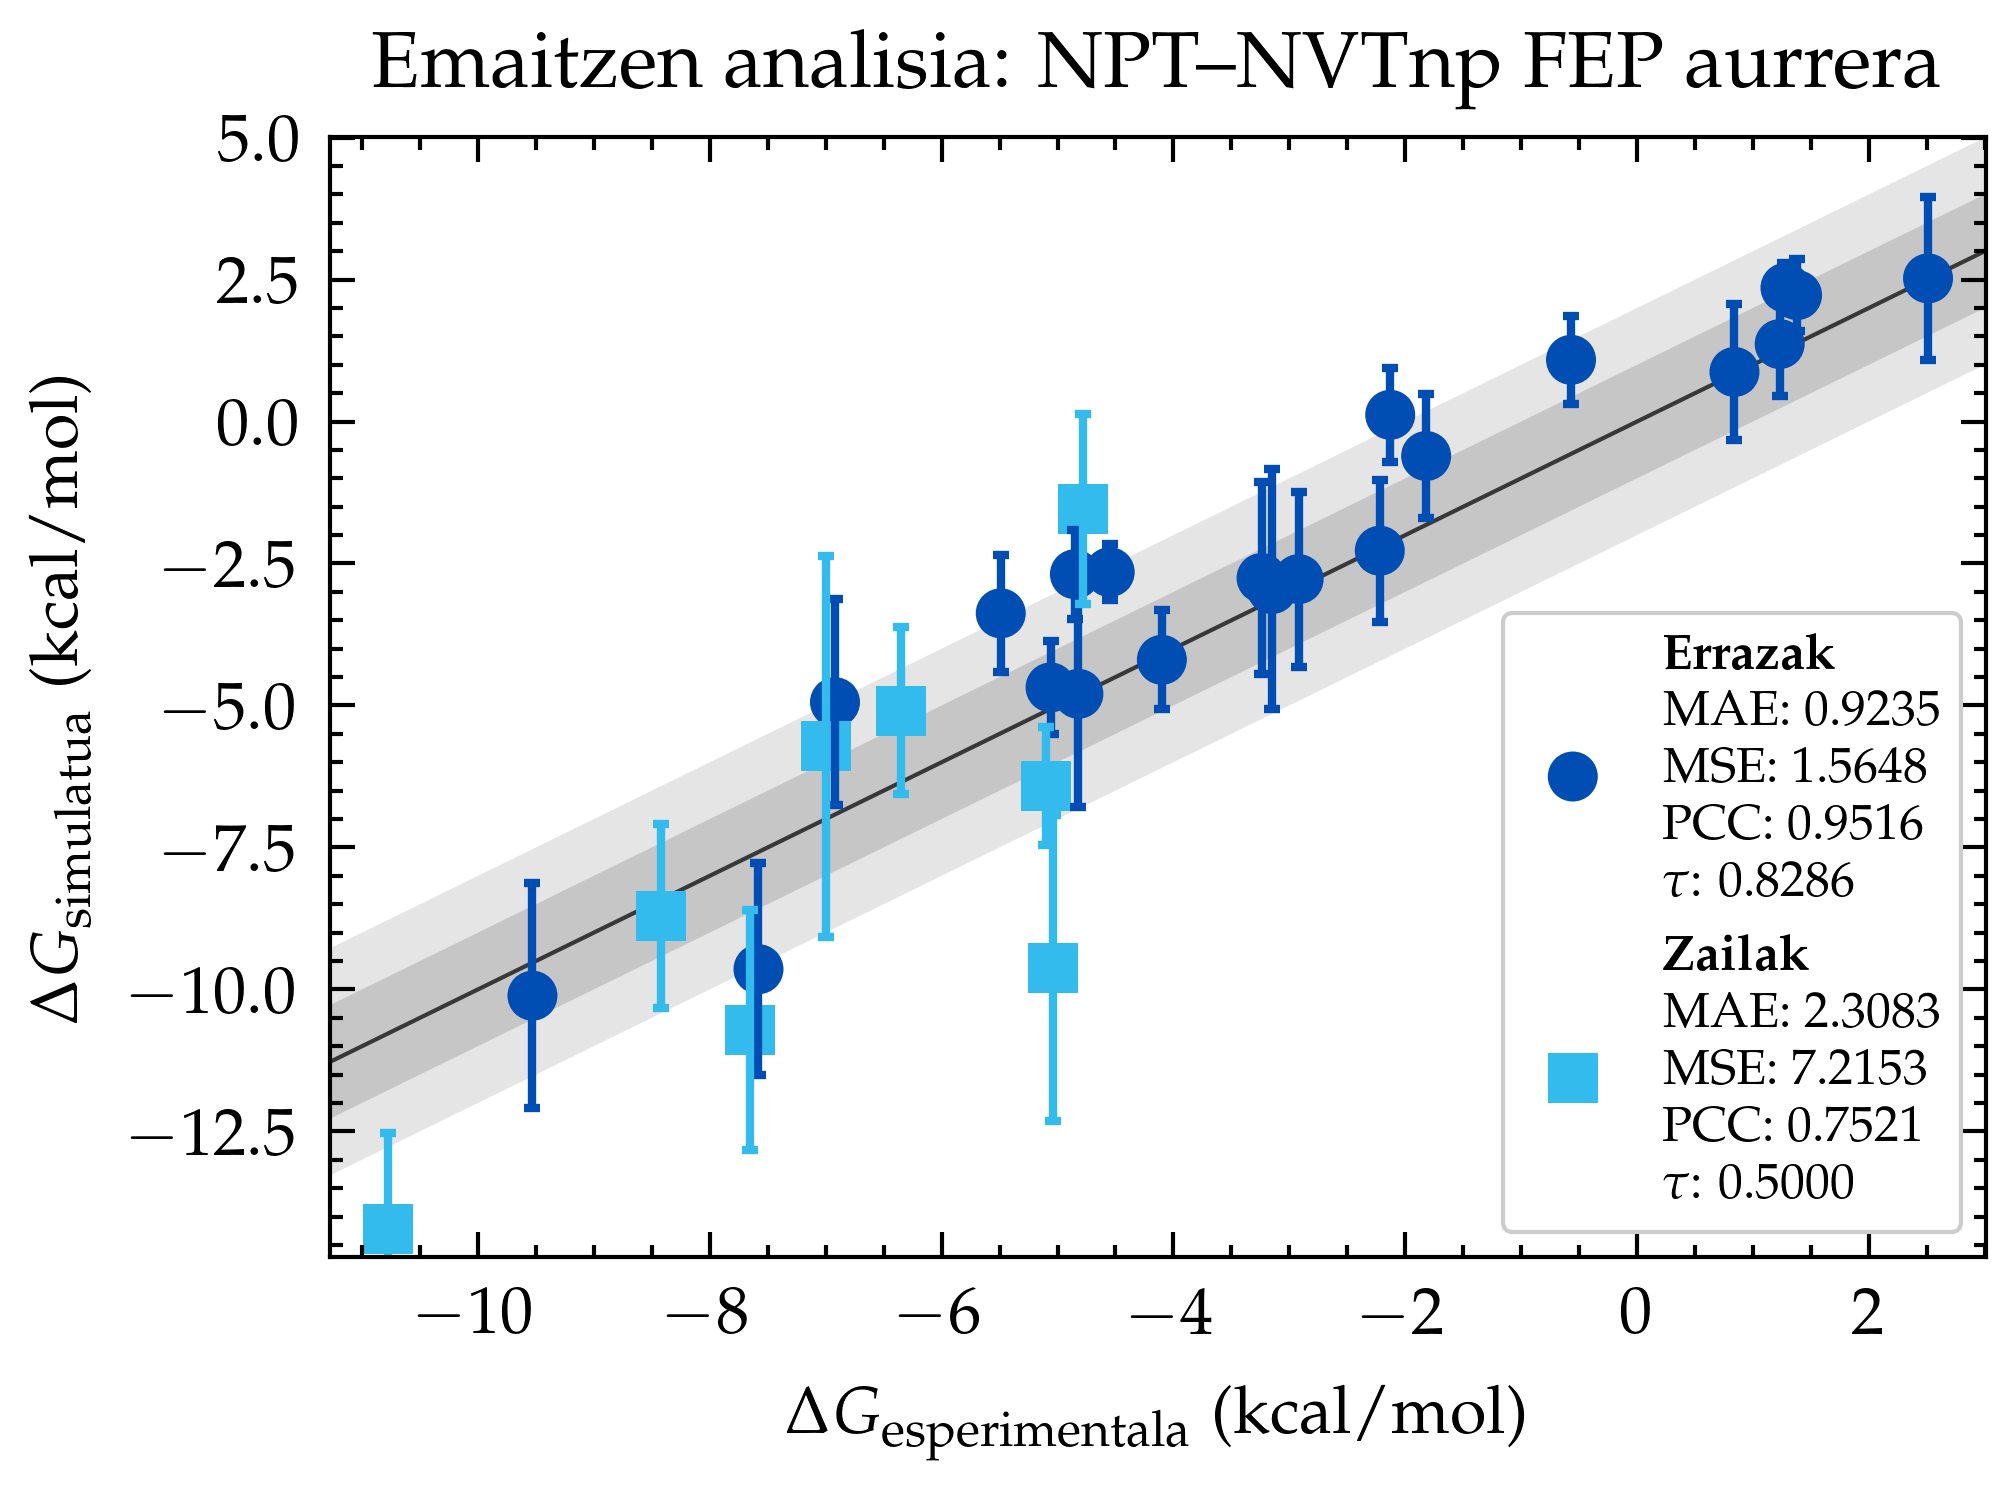

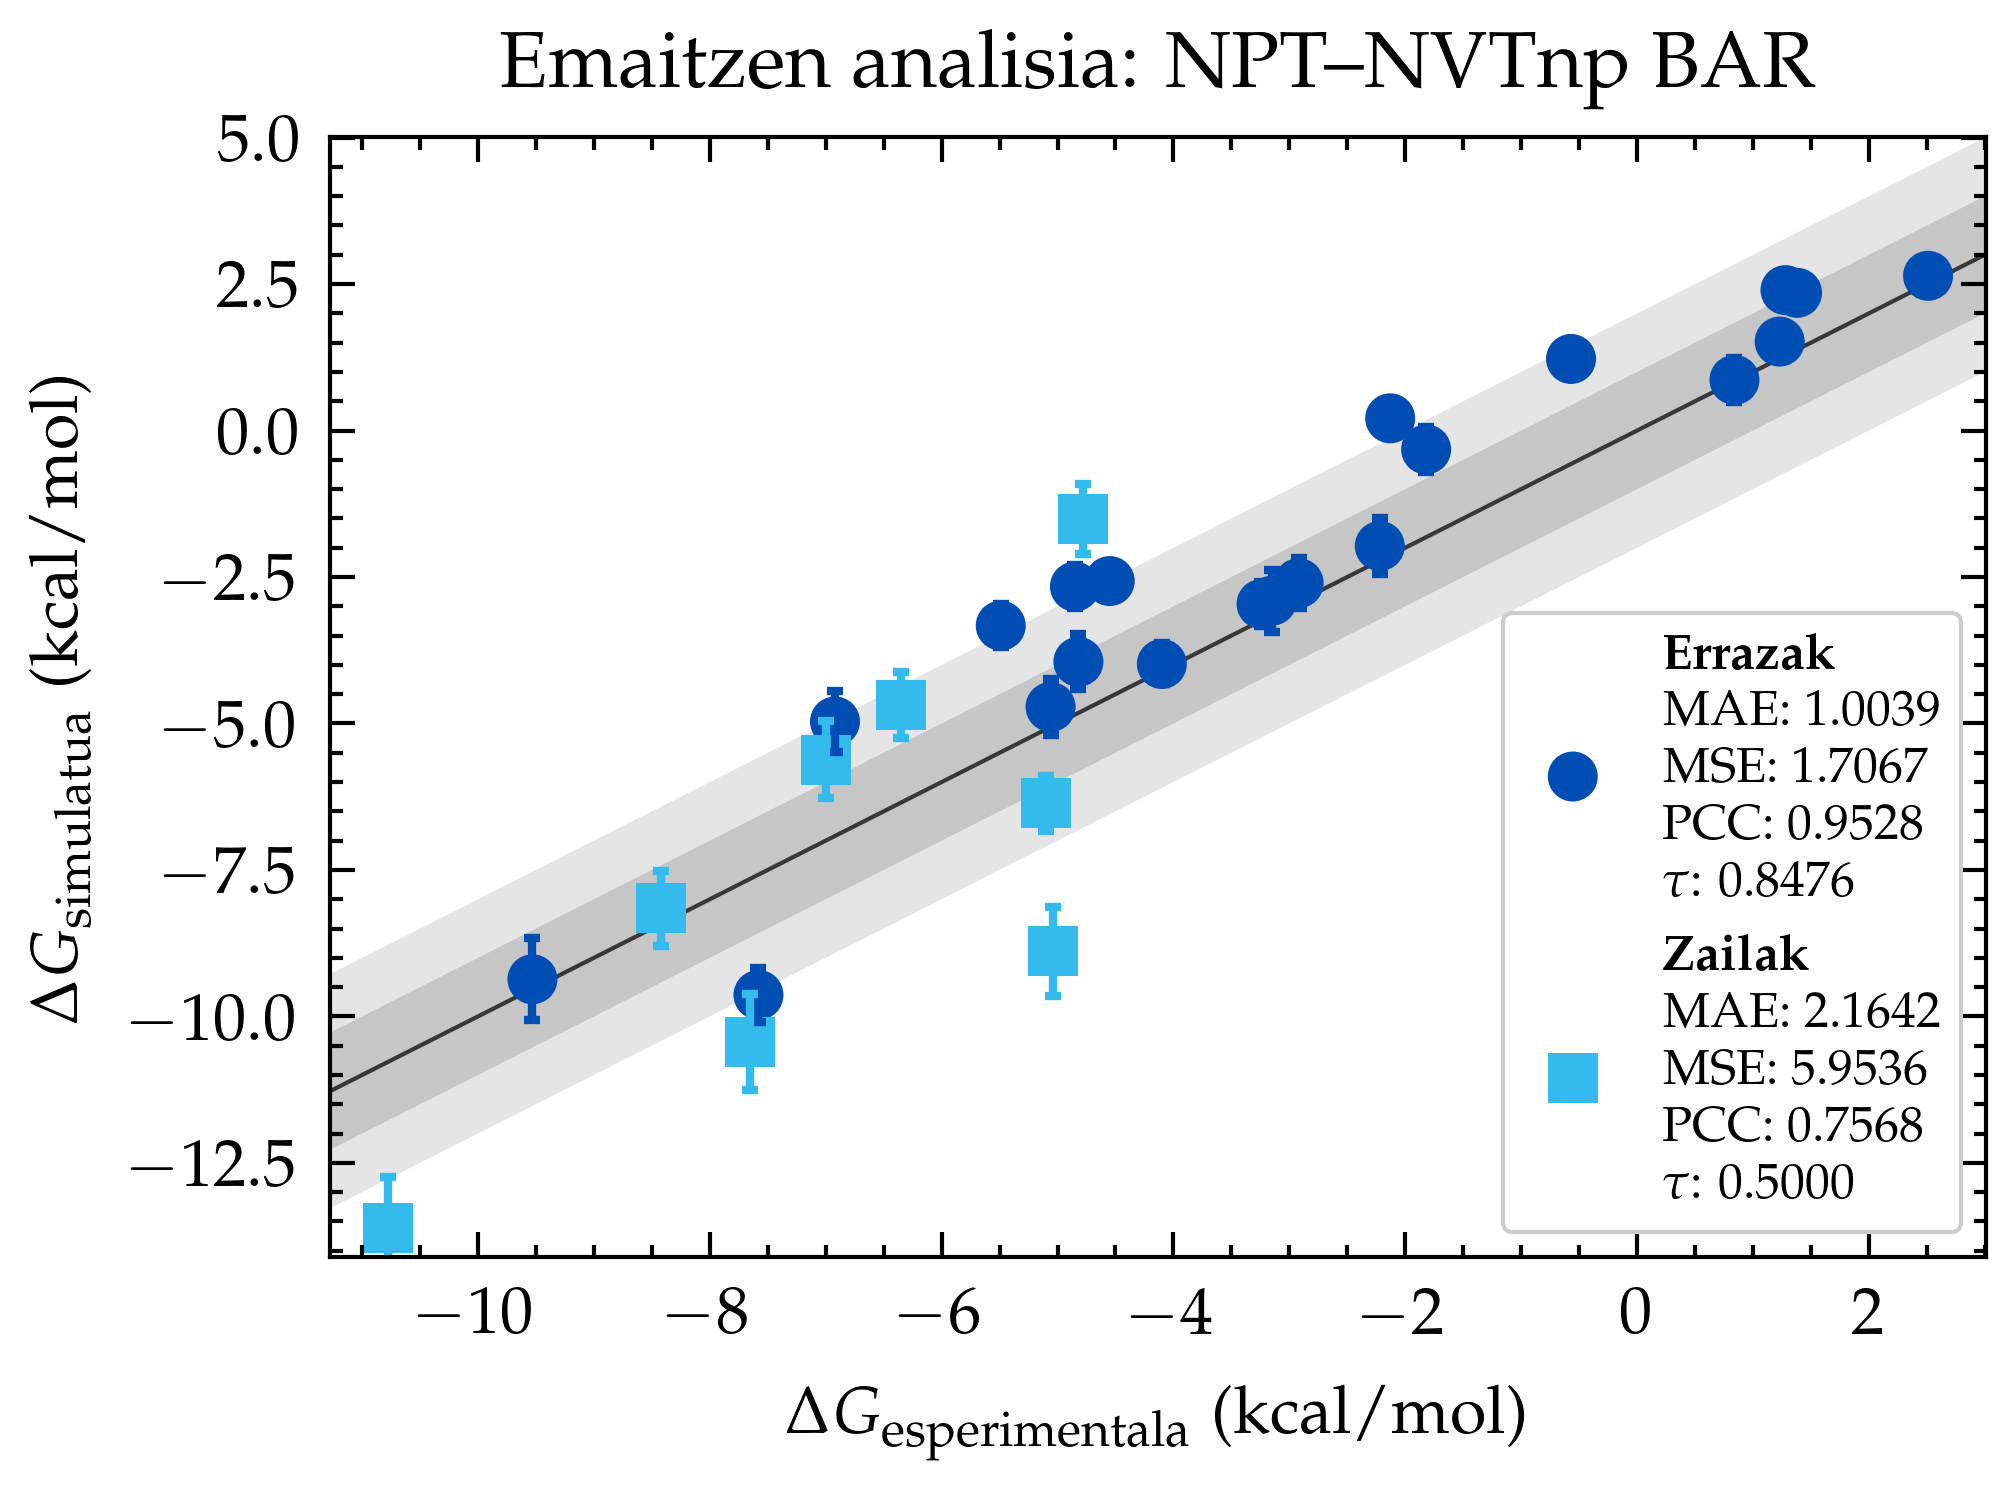

In [18]:
OUTPUT_PATH = 'outputs/outputs_metrikak/'
plot_errazak_zailak('forward', data_dict_erraza, data_dict_zaila, izenb='FEP aurrera').savefig(OUTPUT_PATH+f"Metrikak_zailak_errazak_forward.pdf", dpi=500)
plot_errazak_zailak('BAR', data_dict_erraza, data_dict_zaila, izenb='BAR').savefig(OUTPUT_PATH+f"Metrikak_zailak_errazak_BAR.pdf", dpi=500)

## Azkeneko grafikoa: emaitza guztiak batera

In [27]:
def plot_errazak_zailak_osorik(data_dict_erraza, data_dict_zaila, metodoa='foward'):
    comb_key = 'D_NPT_NVTnp'
    fig, ax = plt.subplots(figsize=(1.5*3.5, 2.625))
    
    X_erraza = []      # X -> balio esperimentalak
    X_zaila = []      # X -> balio esperimentalak
    Y_erraza = []    # Y -> kalkulatutako balioak, errazak
    Y_zaila = []      # Y -> kalkulatutako balioak, zailak
    std_erraza = []
    std_zaila = []
    std_exp_erraza = []
    std_exp_zaila = []

    for molecule_name in erraza_df.name:
        X_erraza.append(data_dict_erraza[metodoa][molecule_name]['0_experimental_value'])
        Y_erraza.append(data_dict_erraza[metodoa][molecule_name][comb_key])
        std_erraza.append(dict_boostrap_erraza[molecule_name][metodoa]['std'])
        std_exp_erraza.append(data_dict_erraza[metodoa][molecule_name]['0_experimental uncertainty'])

    for molecule_name in zaila_df.name:
        X_zaila.append(data_dict_zaila[metodoa][molecule_name]['0_experimental_value'])
        Y_zaila.append(data_dict_zaila[metodoa][molecule_name][comb_key])
        std_zaila.append(dict_boostrap_zaila[molecule_name][metodoa]['std'])
        std_exp_zaila.append(data_dict_zaila[metodoa][molecule_name]['0_experimental uncertainty'])

    X = X_erraza + X_zaila
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = set(Y_erraza+Y_zaila+list(X_range))
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen laburpena")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)

    legend_erraza = r"\textbf{Metrikak}"+f"\nMAE: {metrics_dict_full[metodoa][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict_full[metodoa][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict_full[metodoa][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict_full[metodoa][comb_key]['tau']:>8.4f}"

    ax.scatter(X_erraza, Y_erraza, label=legend_erraza, marker='o', color='C0', zorder=1, edgecolor='none')
    ax.scatter(X_zaila, Y_zaila, marker='o', color='C0', zorder=1, edgecolor='none') 

    #ax.errorbar(X_erraza, Y_erraza, xerr=[1*i for i in std_exp_erraza], yerr=[10*i for i in std_erraza], fmt='none', color='C0', zorder=1, capsize=1)
    #ax.errorbar(X_zaila, Y_zaila, xerr=[1*i for i in std_exp_zaila], yerr=[10*i for i in std_zaila], fmt='none', color='C0', zorder=1, capsize=1)

    ax.errorbar(X_erraza, Y_erraza, yerr=[10*i for i in std_erraza], fmt='none', color='C0', zorder=1, capsize=1)
    ax.errorbar(X_zaila, Y_zaila, yerr=[10*i for i in std_zaila], fmt='none', color='C0', zorder=1, capsize=1)


    legend = ax.legend(frameon=True, loc=4)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig

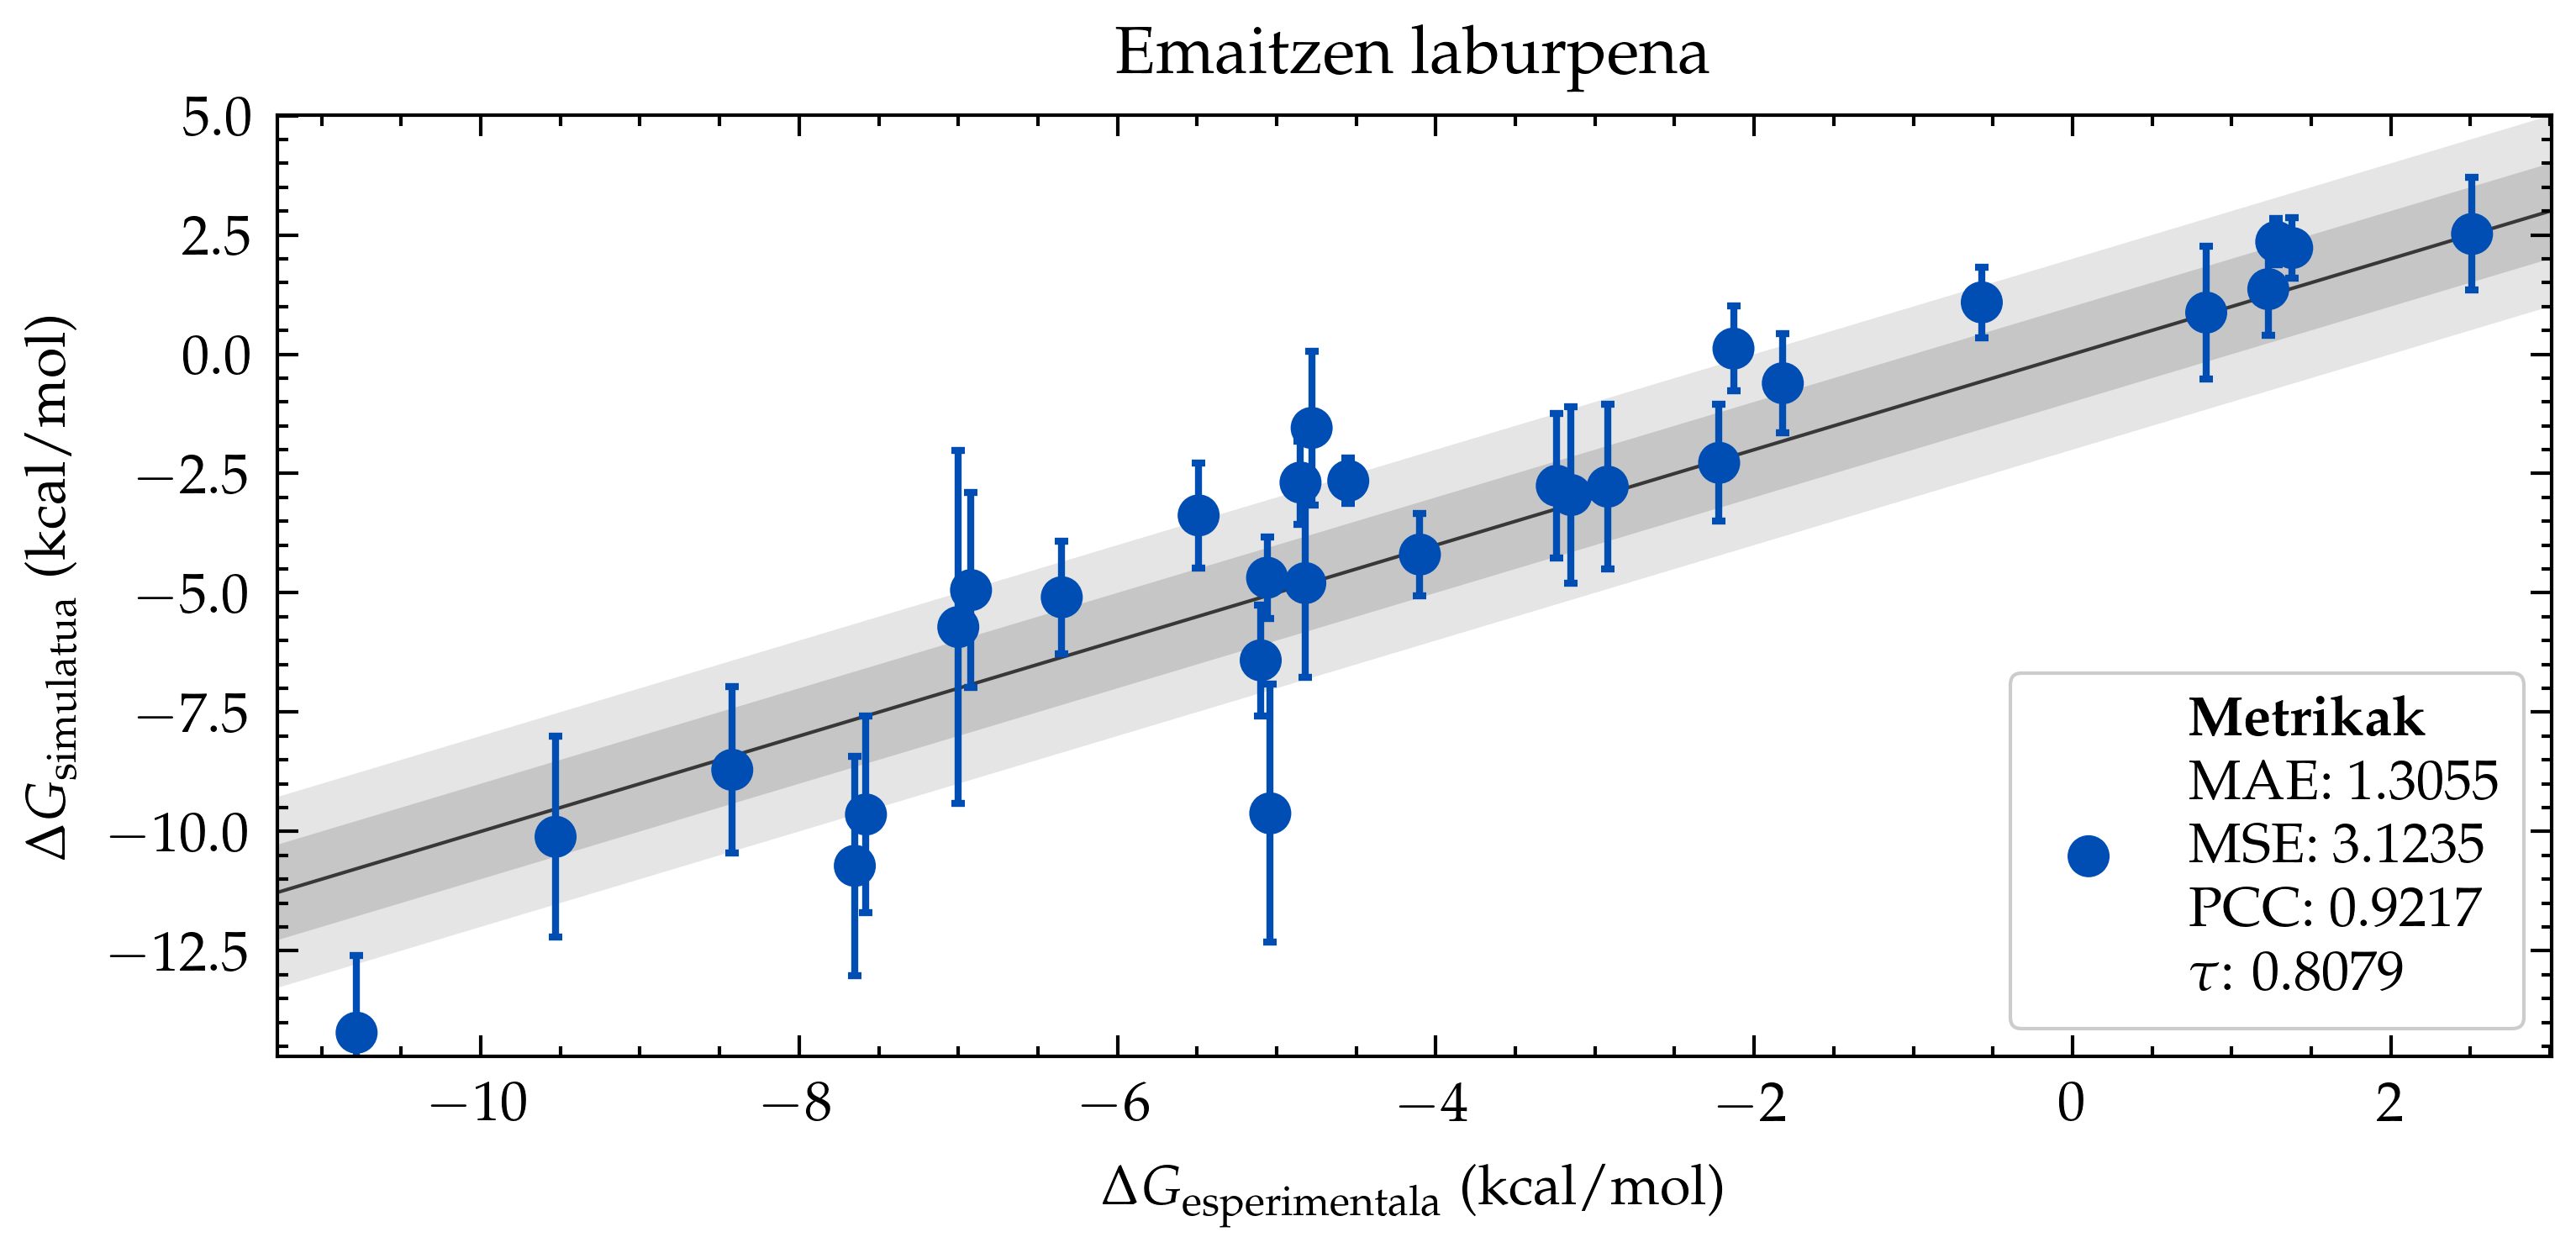

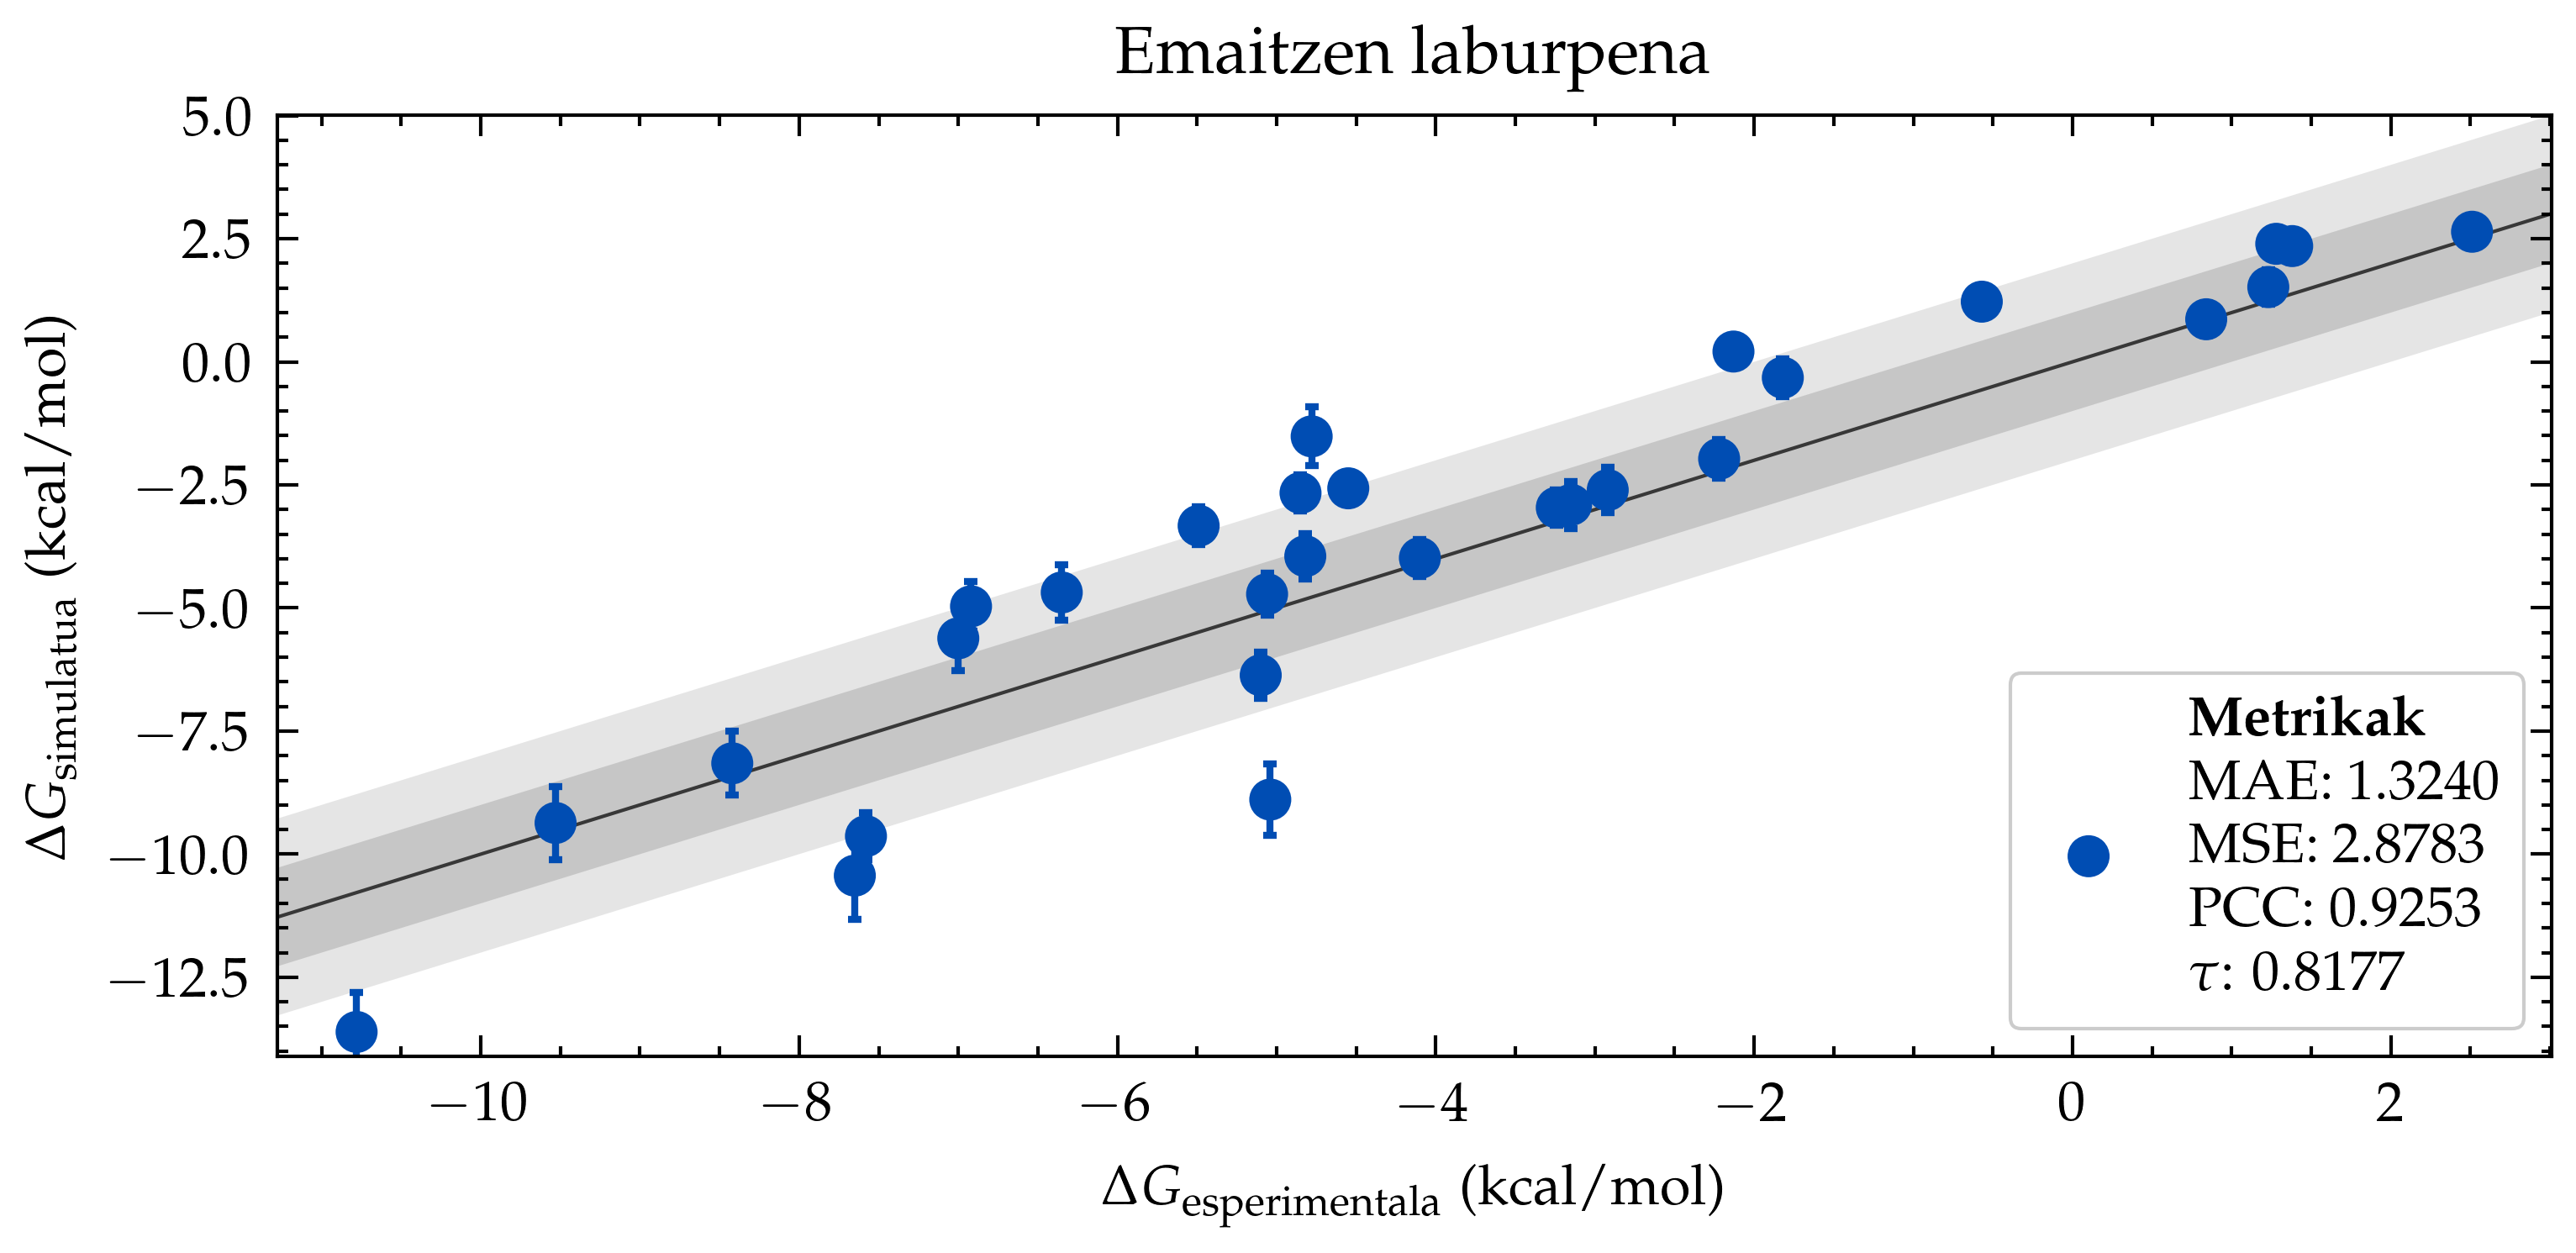

In [28]:
OUTPUT_PATH = 'outputs/outputs_metrikak/'
plot_errazak_zailak_osorik(data_dict_erraza, data_dict_zaila, metodoa='forward').savefig(OUTPUT_PATH+f"Metrikak_guztiak_forward.pdf")
plot_errazak_zailak_osorik(data_dict_erraza, data_dict_zaila, metodoa='BAR').savefig(OUTPUT_PATH+f"Metrikak_guztiak_BAR.pdf")

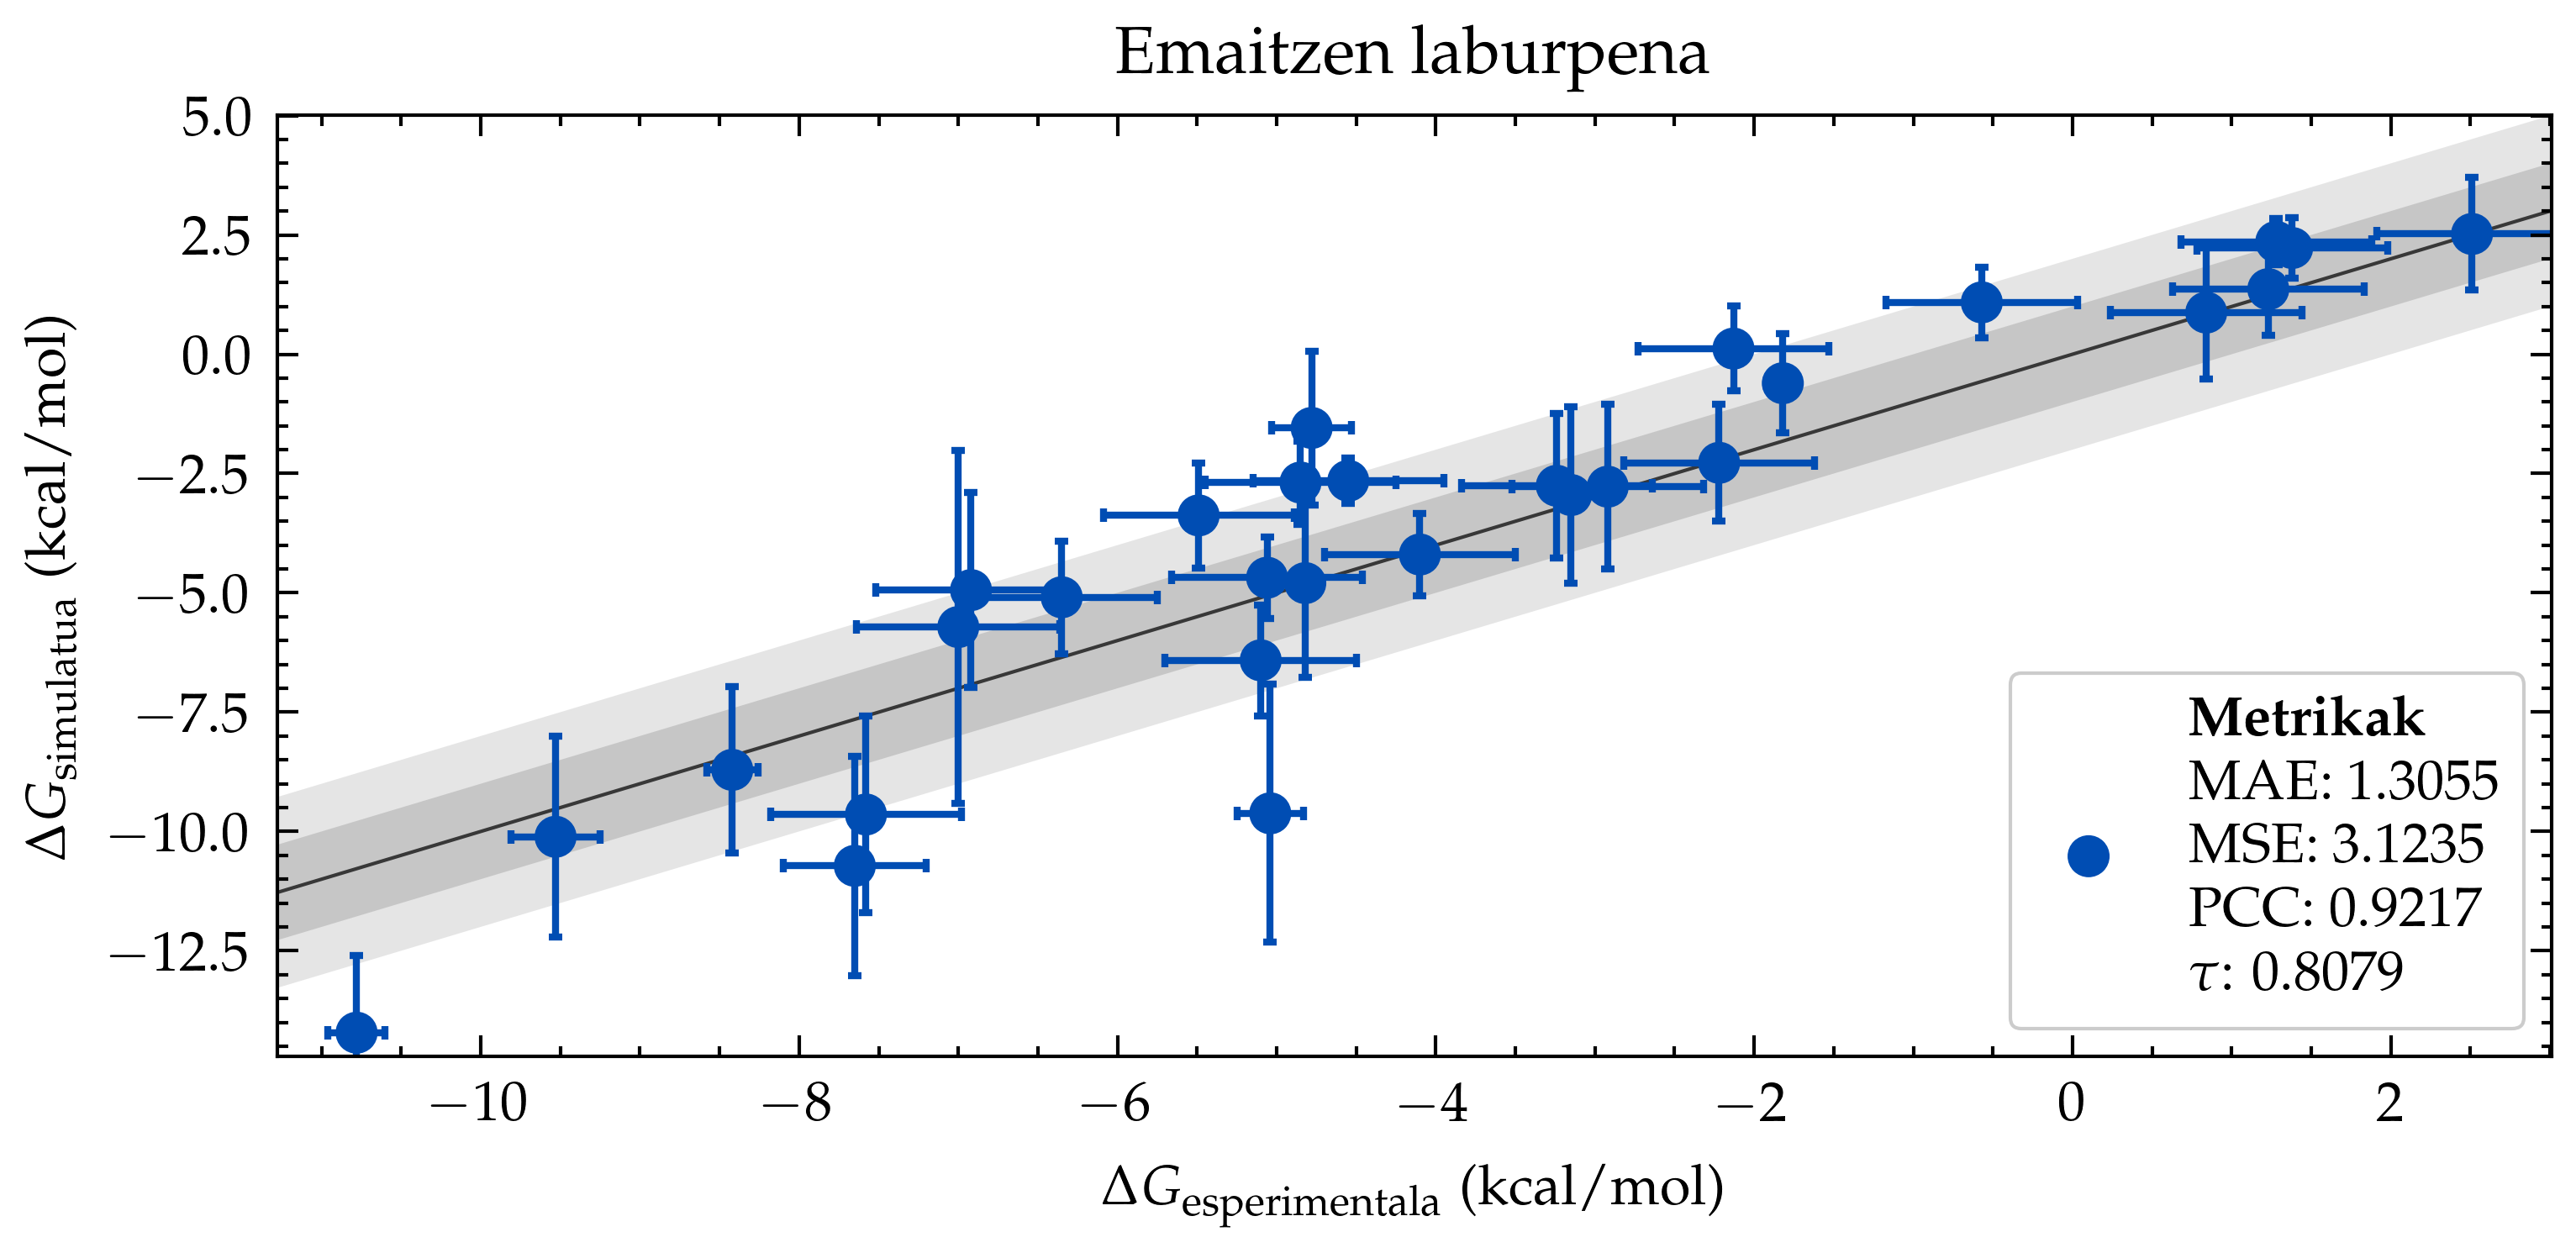

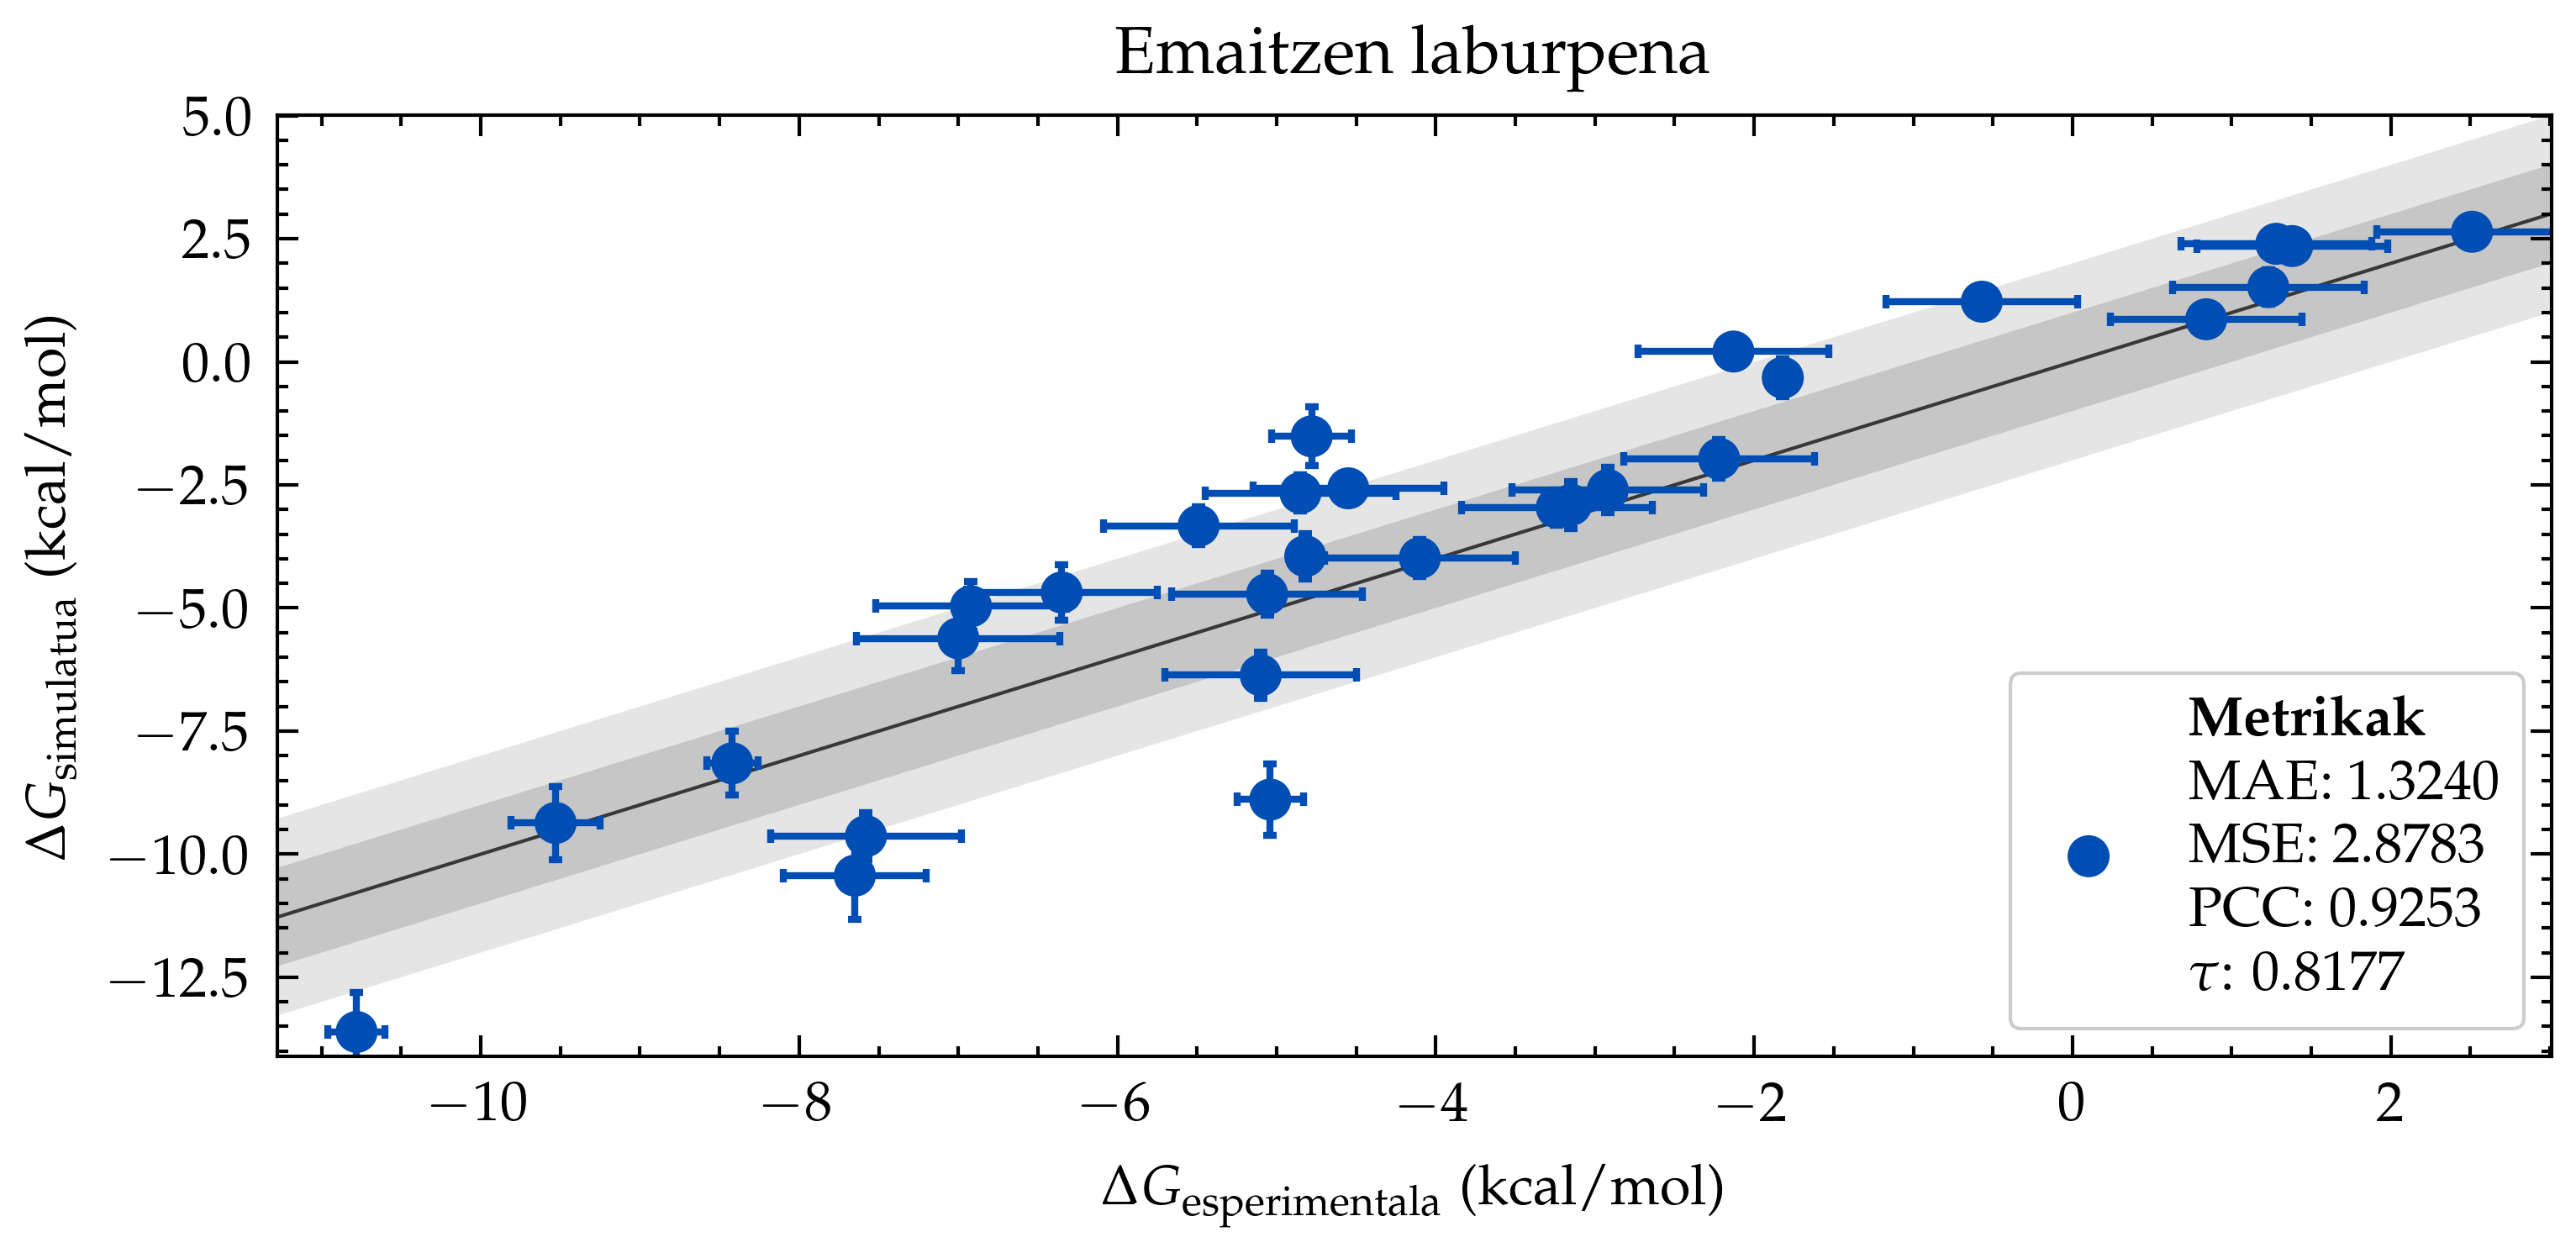

In [26]:
OUTPUT_PATH = 'outputs/outputs_metrikak/'
plot_errazak_zailak_osorik(data_dict_erraza, data_dict_zaila, metodoa='forward').savefig(OUTPUT_PATH+f"Metrikak_guztiak_forward_2err.pdf")
plot_errazak_zailak_osorik(data_dict_erraza, data_dict_zaila, metodoa='BAR').savefig(OUTPUT_PATH+f"Metrikak_guztiak_BAR_2err.pdf")

### Azkeneko irudia, eskala moldatuta, MOBLEY lab taldearen emaitzekin konparagarria izateko:

In [24]:
def plot_errazak_zailak_ESKALA_ALDATUTA(data_dict_erraza, data_dict_zaila, metodoa='foward'):
    comb_key = 'D_NPT_NVTnp'
    fig, ax = plt.subplots(figsize=(1.5*3.5, 2.625))
    
    X_erraza = []      # X -> balio esperimentalak
    X_zaila = []      # X -> balio esperimentalak
    Y_erraza = []    # Y -> kalkulatutako balioak, errazak
    Y_zaila = []      # Y -> kalkulatutako balioak, zailak
    std_erraza = []
    std_zaila = []
    std_exp_erraza = []
    std_exp_zaila = []

    for molecule_name in erraza_df.name:
        X_erraza.append(data_dict_erraza[metodoa][molecule_name]['0_experimental_value'])
        Y_erraza.append(data_dict_erraza[metodoa][molecule_name][comb_key])
        std_erraza.append(dict_boostrap_erraza[molecule_name][metodoa]['std'])
        std_exp_erraza.append(data_dict_erraza[metodoa][molecule_name]['0_experimental uncertainty'])

    for molecule_name in zaila_df.name:
        X_zaila.append(data_dict_zaila[metodoa][molecule_name]['0_experimental_value'])
        Y_zaila.append(data_dict_zaila[metodoa][molecule_name][comb_key])
        std_zaila.append(dict_boostrap_zaila[molecule_name][metodoa]['std'])
        std_exp_zaila.append(data_dict_zaila[metodoa][molecule_name]['0_experimental uncertainty'])

    X = X_erraza + X_zaila
    # MOBLEY Lab-en datuen eskala bera izateko
    X.extend([-10.78, 2.51])
    X_range = np.array([min(X)-2, max(X)+2])
    ax.set_xlim([min(X)-0.5, max(X)+0.5])
    y_all = list(set(Y_erraza+Y_zaila+list(X_range)))
    # MOBLEY Lab-en datuen eskala bera izateko
    y_all.extend([-17.24, 2.51])
    ax.set_ylim([min(y_all)-0.5, max(y_all)+0.5])

    ax.set_xlabel(r'$\Delta G_\text{esperimentala}$ (kcal/mol)')
    ax.set_ylabel(r'$\Delta G_\text{simulatua}$ (kcal/mol)')
    ax.set_title(f"Emaitzen laburpena")

    ax.fill_between(X_range, X_range-2, X_range+2, alpha=0.2, color='gray', edgecolor='none')
    ax.fill_between(X_range, X_range-1, X_range+1, alpha=0.3, color='gray', edgecolor='none')
    ax.plot(X_range, X_range, '-', color='black', linewidth=0.5, zorder=0)

    legend_erraza = r"\textbf{Metrikak}"+f"\nMAE: {metrics_dict_full[metodoa][comb_key]['MAE']:>8.4f}\nMSE: {metrics_dict_full[metodoa][comb_key]['MSE']:>8.4f}\nPCC:  {metrics_dict_full[metodoa][comb_key]['PCC']:>8.4f}\n    $\\tau$:  {metrics_dict_full[metodoa][comb_key]['tau']:>8.4f}"

    ax.scatter(X_erraza, Y_erraza, label=legend_erraza, marker='o', color='C0', zorder=1, edgecolor='none')
    ax.scatter(X_zaila, Y_zaila, marker='o', color='C0', zorder=1, edgecolor='none') 

    ax.errorbar(X_erraza, Y_erraza, xerr=[1*i for i in std_exp_erraza], yerr=[10*i for i in std_erraza], fmt='none', color='C0', zorder=1, capsize=1)
    ax.errorbar(X_zaila, Y_zaila, xerr=[1*i for i in std_exp_zaila], yerr=[10*i for i in std_zaila], fmt='none', color='C0', zorder=1, capsize=1)

    #ax.errorbar(X_erraza, Y_erraza, yerr=[10*i for i in std_erraza], fmt='none', color='C0', zorder=1, capsize=1)
    #ax.errorbar(X_zaila, Y_zaila, yerr=[10*i for i in std_zaila], fmt='none', color='C0', zorder=1, capsize=1)


    legend = ax.legend(frameon=True, loc=4)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_alpha(1.0) 

    fig.tight_layout()
    return fig

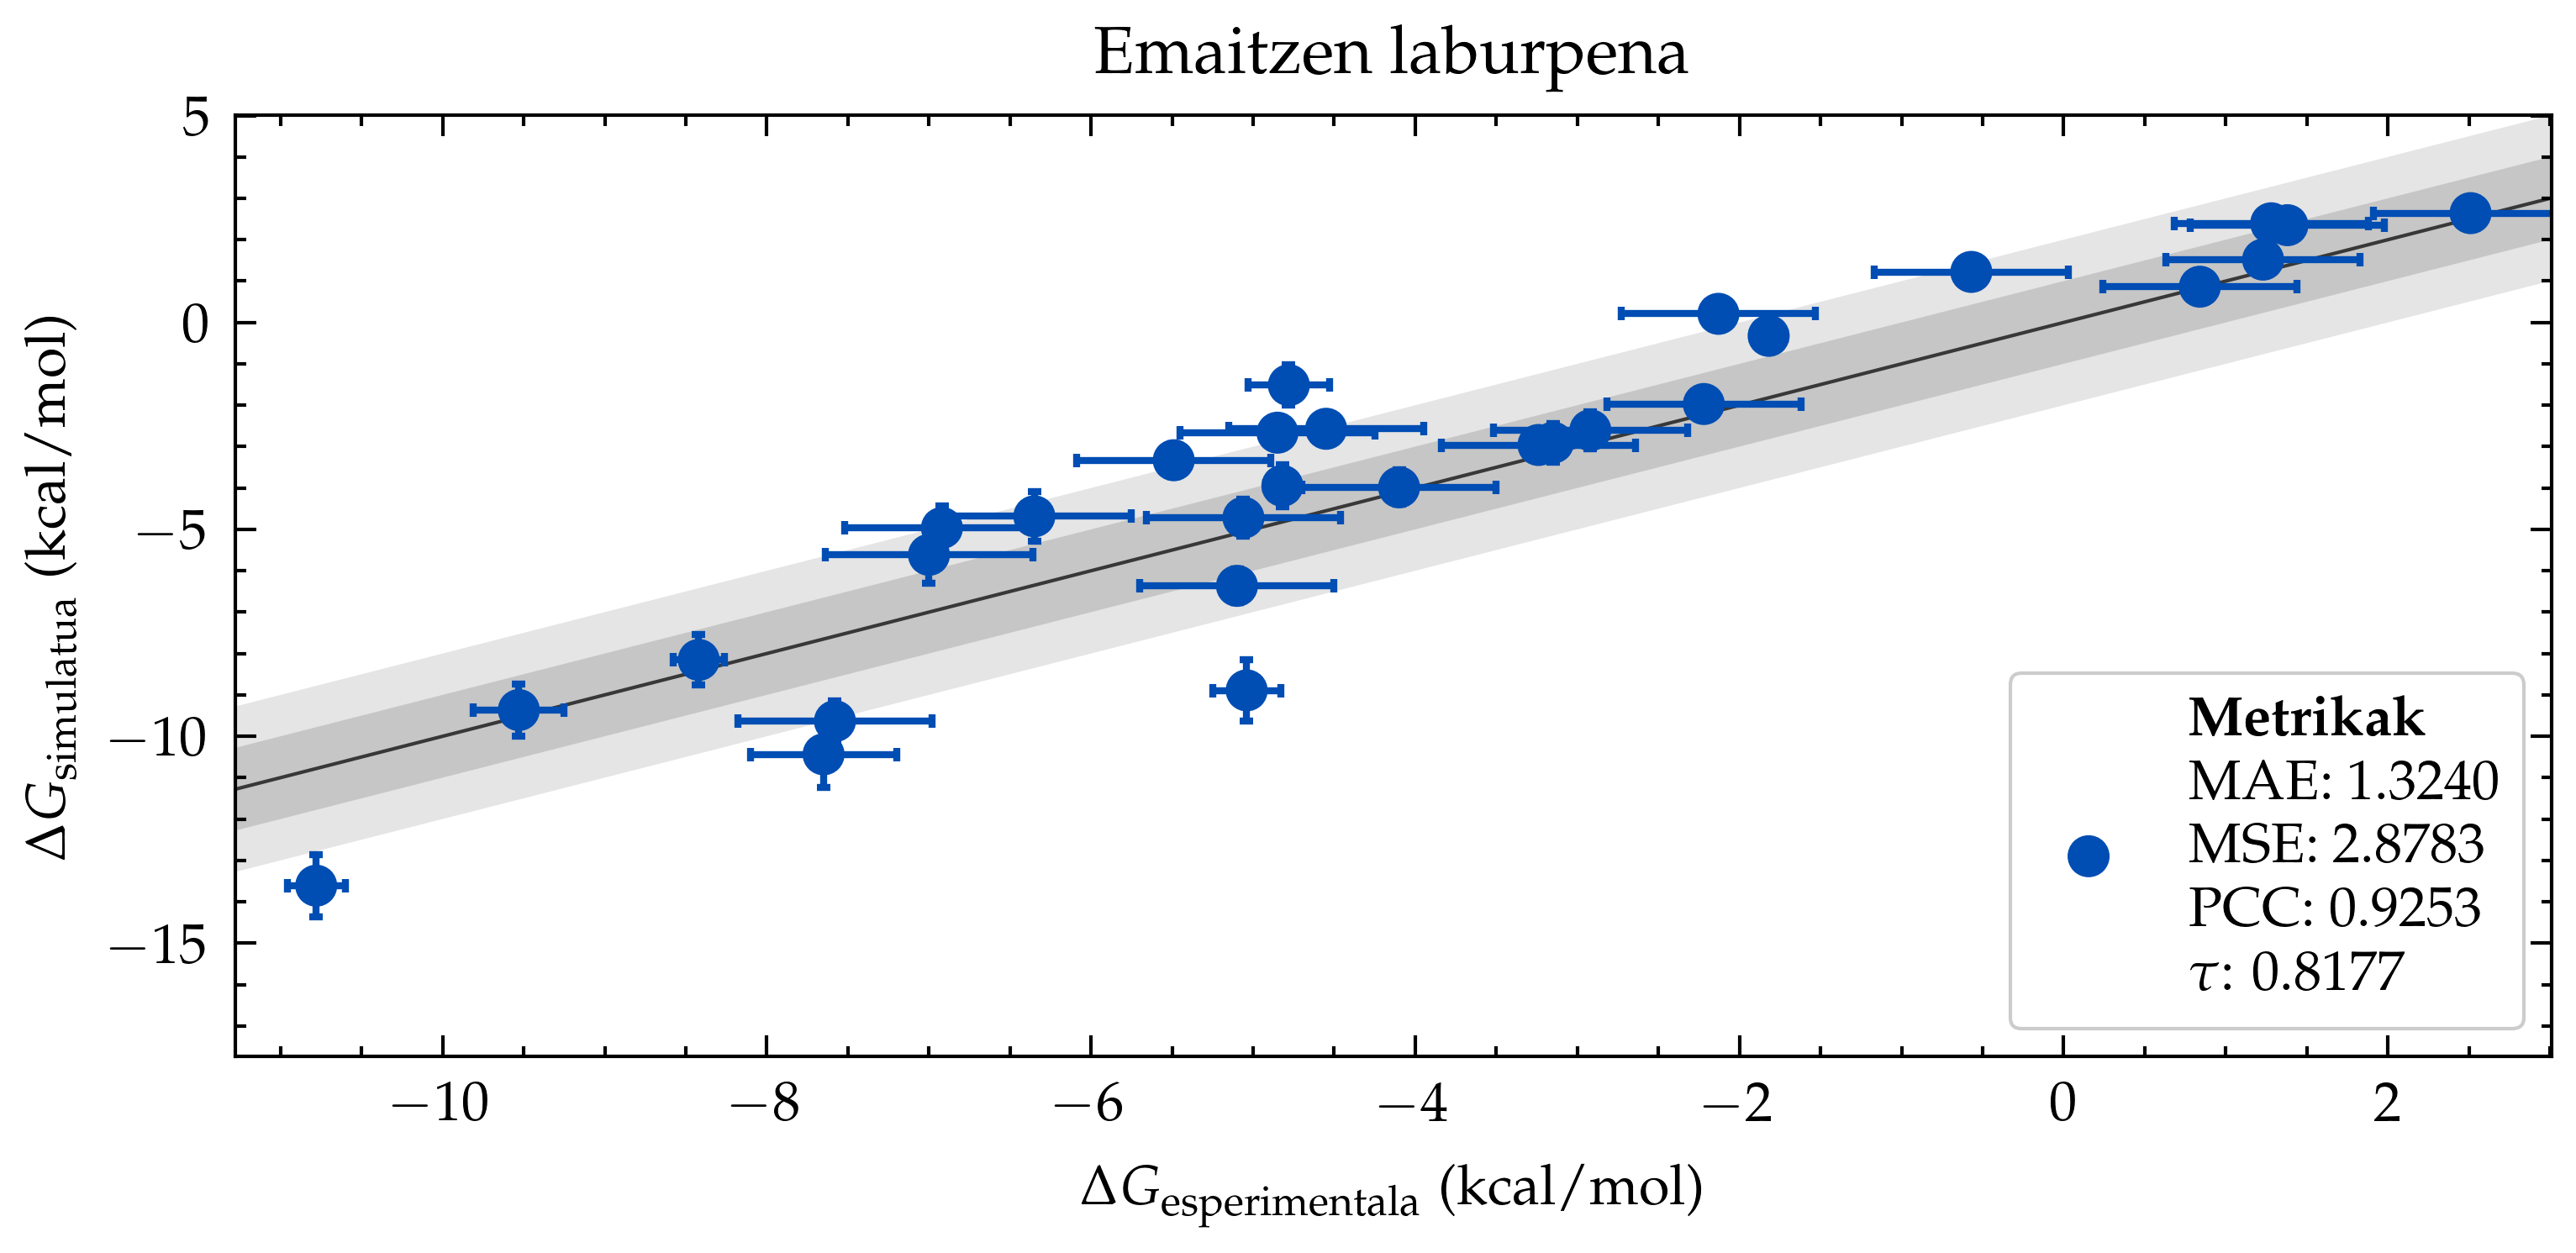

In [25]:
OUTPUT_PATH = 'outputs/outputs_metrikak/'
plot_errazak_zailak_ESKALA_ALDATUTA(data_dict_erraza, data_dict_zaila, metodoa='BAR').savefig(OUTPUT_PATH+f"Metrikak_guztiak_BAR_2err_SCALED.pdf")

## Balio numerikoak gordetzeko .csv fitxategia

In [45]:
import pandas as pd

column_names = ['exp_value (kcal/mol)', 'exp_uncertainty (kcal/mol)', 'sim_value_BAR (kcal/mol)', 'sim_uncertainty_BAR (kcal/mol)', 'sim_value_forward (kcal/mol)', 'sim_uncertainty_forward (kcal/mol)', 'sim_value_backward (kcal/mol)', 'sim_uncertainty_backward (kcal/mol)']

df = pd.DataFrame(columns=column_names)
comb_key = 'D_NPT_NVTnp'

for molecule_name in erraza_df.name:
    df.loc[molecule_name] = [
    data_dict_erraza['forward'][molecule_name]['0_experimental_value'],
    data_dict_erraza['forward'][molecule_name]['0_experimental uncertainty'],
    data_dict_erraza['BAR'][molecule_name][comb_key],
    dict_boostrap_erraza[molecule_name]['BAR']['std'],
    data_dict_erraza['forward'][molecule_name][comb_key],
    dict_boostrap_erraza[molecule_name]['forward']['std'],
    data_dict_erraza['backward'][molecule_name][comb_key],
    dict_boostrap_erraza[molecule_name]['backward']['std']
]

for molecule_name in zaila_df.name:
    df.loc[str(molecule_name)] = [
        data_dict_zaila['forward'][molecule_name]['0_experimental_value'],
        data_dict_zaila['forward'][molecule_name]['0_experimental uncertainty'],
        data_dict_zaila['BAR'][molecule_name][comb_key],
        dict_boostrap_zaila[molecule_name]['BAR']['std'],
        data_dict_zaila['forward'][molecule_name][comb_key],
        dict_boostrap_zaila[molecule_name]['forward']['std'],
        data_dict_zaila['backward'][molecule_name][comb_key],
        dict_boostrap_zaila[molecule_name]['backward']['std']
    ]

df = df.reset_index().rename(columns={'index': 'molecule'})
df.to_csv('emaitzen_laburpena_NPT_NVTnp.csv')